In [2]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


In [2]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

<IPython.core.display.Javascript object>

Total number of training images = 5680


<IPython.core.display.Javascript object>


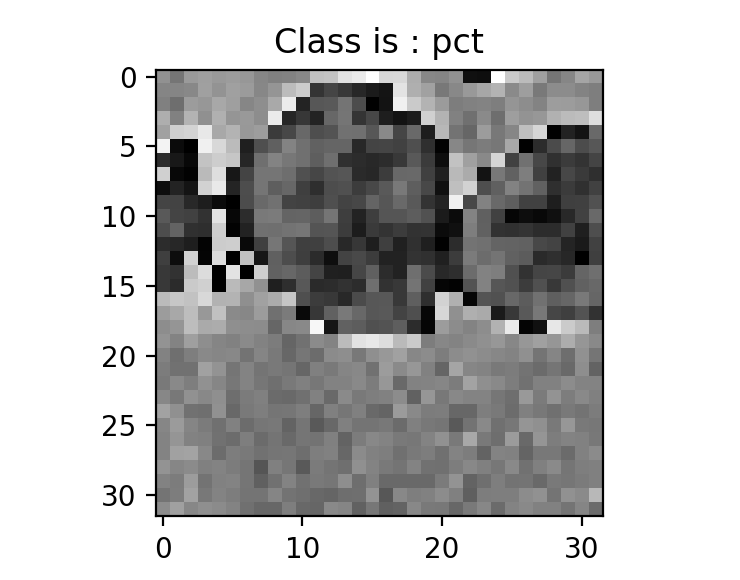

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

In [12]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [3]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [4]:
config_file = '../configs/config_hdf5_overlaySV1.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [5]:
# Train the network
main(config, None)

Total number of training images = 801
threeDmodel_update(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(6, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(6, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, t

/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
    epoch          : 1
    loss           : 1.2669760259714993
    my_metric      : 0.5049196230598669
    f1             : 0.5013390021908598
    balanced_accuracy: 0.48477784598727425
    precision      : 0.5058572304929437
    recall         : 0.5049196230598669
    val_loss       : 0.7071547508239746
    val_my_metric  : 0.42410714285714285
    val_f1         : 0.2784698025551684
    val_balanced_accuracy: 0.5178571428571428
    val_precision  : 0.42845775462962965
  

Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 0.8593542684208263
    my_metric      : 0.6141213968957872
    f1             : 0.6151249192821853
    balanced_accuracy: 0.611361317370759
    precision      : 0.6212638501458522
    recall         : 0.6141213968957872
    val_loss       : 0.6198740601539612
    val_my_metric  : 0.6484375
    val_f1         : 0.6491154486998967
    val_balanced_accuracy: 0.6377541299280429
    val_precision  : 0.6514529817608862
    val_recall     : 0.6484375


Model has not improved in -------------| 2 epochs


    epoch          : 6
    loss           : 0.8130895766344938
    my_metric      : 0.6324833702882483
    f1             : 0.6339321531242307
    balanced_accuracy: 0.6318489488583642
    precision      : 0.6423199247068496
    recall         : 0.6324833702882483
    val_loss       : 0.5457929819822311
    val_my_metric  : 0.6863839285714286
    val_f1         : 0.6894706157640436
    val_balanced_accuracy: 0.6904469443599879
    val_precision  : 0.7022616543612638
    val_recall     : 0.6863839285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 0.7585360299457203
    my_metric      : 0.6475886917960089
    f1             : 0.6478015176634743
    balanced_accuracy: 0.6427932478411175
    precision      : 0.6521231466324419
    recall         : 0.6475886917960089
    val_loss       : 0.6097979545593262
    val_my_metric  : 0.6439732142857143
    

Model has not improved in -------------| 1 epochs


    epoch          : 8
    loss           : 0.8164787021550265
    my_metric      : 0.6292960088691796
    f1             : 0.6299115998509003
    balanced_accuracy: 0.6259404842699766
    precision      : 0.6386716351196232
    recall         : 0.6292960088691796
    val_loss       : 0.5277447551488876
    val_my_metric  : 0.703125
    val_f1         : 0.7057829332325816
    val_balanced_accuracy: 0.7075218075218075
    val_precision  : 0.7180113636363636
    val_recall     : 0.703125
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch8.pth ...
Saving current best: model_best.pth ...
    epoch          : 9
    loss           : 0.7602966644547202
    my_metric      : 0.6488359201773836
    f1             : 0.6487010851019552
    balanced_accuracy: 0.6494853300247186
    precision      : 0.6620970626751718
    recall         : 0.6488359201773836
    val_loss       : 0.522554337978363
    val_my_metric  : 0.7154017857142857
    val_f1         : 0.71

Model has not improved in -------------| 1 epochs


    epoch          : 14
    loss           : 0.6646157882430337
    my_metric      : 0.694359756097561
    f1             : 0.695246498548721
    balanced_accuracy: 0.6921406293536954
    precision      : 0.7006423892766519
    recall         : 0.694359756097561
    val_loss       : 0.43001367151737213
    val_my_metric  : 0.7622767857142857
    val_f1         : 0.7641731611712649
    val_balanced_accuracy: 0.7822777068133105
    val_precision  : 0.7969602595680181
    val_recall     : 0.7622767857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 0.6409734948114916
    my_metric      : 0.708910753880266
    f1             : 0.7109100403438314
    balanced_accuracy: 0.7108580847623464
    precision      : 0.7196575701626797
    recall         : 0.708910753880266
    val_loss       : 0.44566822052001953
    val_my_metric  : 0.7857142857142857
    

Model has not improved in -------------| 1 epochs


    epoch          : 16
    loss           : 0.6937256943095814
    my_metric      : 0.6858370288248337
    f1             : 0.6886485516662015
    balanced_accuracy: 0.692258517787265
    precision      : 0.708456551043042
    recall         : 0.6858370288248337
    val_loss       : 0.48063962161540985
    val_my_metric  : 0.734375
    val_f1         : 0.7366120928620928
    val_balanced_accuracy: 0.7506993006993007
    val_precision  : 0.7721580464572193
    val_recall     : 0.734375


Model has not improved in -------------| 2 epochs


    epoch          : 17
    loss           : 0.6413283727385781
    my_metric      : 0.6827536031042128
    f1             : 0.6847719508164946
    balanced_accuracy: 0.6867681890596986
    precision      : 0.6957767167003768
    recall         : 0.6827536031042128
    val_loss       : 0.4233555346727371
    val_my_metric  : 0.7879464285714286
    val_f1         : 0.7898216323818766
    val_balanced_accuracy: 0.8082582582582583
    val_precision  : 0.8238770008553273
    val_recall     : 0.7879464285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch17.pth ...
Saving current best: model_best.pth ...
    epoch          : 18
    loss           : 0.6495333964174445
    my_metric      : 0.7065202328159645
    f1             : 0.708155965503519
    balanced_accuracy: 0.7094600508279968
    precision      : 0.7180926140940965
    recall         : 0.7065202328159645
    val_loss       : 0.5248221606016159
    val_my_metric  : 0.7220982142857143
  

Model has not improved in -------------| 1 epochs


    epoch          : 19
    loss           : 0.6865605197169564
    my_metric      : 0.6673711197339246
    f1             : 0.6680183446412314
    balanced_accuracy: 0.6708572658337638
    precision      : 0.6862659540952474
    recall         : 0.6673711197339246
    val_loss       : 0.4637242257595062
    val_my_metric  : 0.7745535714285714
    val_f1         : 0.7749450204086133
    val_balanced_accuracy: 0.8
    val_precision  : 0.8259153661464587
    val_recall     : 0.7745535714285714


Model has not improved in -------------| 2 epochs


    epoch          : 20
    loss           : 0.6794176318428733
    my_metric      : 0.6722560975609756
    f1             : 0.674700203954703
    balanced_accuracy: 0.677779855215709
    precision      : 0.6894918806409662
    recall         : 0.6722560975609756
    val_loss       : 0.6448623538017273
    val_my_metric  : 0.7600446428571428
    val_f1         : 0.7615003052503053
    val_balanced_accuracy: 0.7827918985039728
    val_precision  : 0.801327941952942
    val_recall     : 0.7600446428571428


Model has not improved in -------------| 3 epochs


    epoch          : 21
    loss           : 0.6186479573900049
    my_metric      : 0.7248129157427937
    f1             : 0.7257074597877521
    balanced_accuracy: 0.7281061929083997
    precision      : 0.7352097602273608
    recall         : 0.7248129157427937
    val_loss       : 0.48841889202594757
    val_my_metric  : 0.7455357142857143
    val_f1         : 0.7476649598133265
    val_balanced_accuracy: 0.7636292692814433
    val_precision  : 0.7817174844644603
    val_recall     : 0.7455357142857143


Model has not improved in -------------| 4 epochs


    epoch          : 22
    loss           : 0.6468839509920641
    my_metric      : 0.699244733924612
    f1             : 0.7011899525376329
    balanced_accuracy: 0.7081452448099138
    precision      : 0.7191301006777561
    recall         : 0.699244733924612
    val_loss       : 0.47684191167354584
    val_my_metric  : 0.7109375
    val_f1         : 0.7139907578381834
    val_balanced_accuracy: 0.7197916666666667
    val_precision  : 0.7336500864726672
    val_recall     : 0.7109375


Model has not improved in -------------| 5 epochs


    epoch          : 23
    loss           : 0.6523178788748655
    my_metric      : 0.704129711751663
    f1             : 0.7058606614419074
    balanced_accuracy: 0.7124733761440272
    precision      : 0.7246241197316067
    recall         : 0.704129711751663
    val_loss       : 0.571748897433281
    val_my_metric  : 0.7299107142857143
    val_f1         : 0.7323988175802693
    val_balanced_accuracy: 0.7502788502788502
    val_precision  : 0.7691249205466391
    val_recall     : 0.7299107142857143


Model has not improved in -------------| 6 epochs


    epoch          : 24
    loss           : 0.6224137002771551
    my_metric      : 0.7085643015521064
    f1             : 0.7109446547866124
    balanced_accuracy: 0.7158261582783705
    precision      : 0.7284794309147
    recall         : 0.7085643015521064
    val_loss       : 0.544249951839447
    val_my_metric  : 0.7399553571428572
    val_f1         : 0.7395172495875821
    val_balanced_accuracy: 0.7582792207792208
    val_precision  : 0.7864494906621393
    val_recall     : 0.7399553571428572


Model has not improved in -------------| 7 epochs


    epoch          : 25
    loss           : 0.6234417720274492
    my_metric      : 0.6976510532150776
    f1             : 0.6988817818894525
    balanced_accuracy: 0.7060685465299623
    precision      : 0.7174622341546045
    recall         : 0.6976510532150776
    val_loss       : 0.5098305195569992
    val_my_metric  : 0.7433035714285714
    val_f1         : 0.7432158279978658
    val_balanced_accuracy: 0.7662305162305163
    val_precision  : 0.7921006286926224
    val_recall     : 0.7433035714285714


Model has not improved in -------------| 8 epochs


    epoch          : 26
    loss           : 0.676712225783955
    my_metric      : 0.68157566518847
    f1             : 0.6840376915536013
    balanced_accuracy: 0.6857536266113979
    precision      : 0.7019949564065114
    recall         : 0.68157566518847
    val_loss       : 0.44626596570014954
    val_my_metric  : 0.7700892857142857
    val_f1         : 0.7718803192593515
    val_balanced_accuracy: 0.7878787878787878
    val_precision  : 0.819304935515873
    val_recall     : 0.7700892857142857


Model has not improved in -------------| 9 epochs


    epoch          : 27
    loss           : 0.5897486995566975
    my_metric      : 0.7223184589800443
    f1             : 0.7241758400878775
    balanced_accuracy: 0.726267870906957
    precision      : 0.7388849621265687
    recall         : 0.7223184589800443
    val_loss       : 0.5625445693731308
    val_my_metric  : 0.7511160714285714
    val_f1         : 0.7500390365825458
    val_balanced_accuracy: 0.7785714285714286
    val_precision  : 0.8136682800626265
    val_recall     : 0.7511160714285714


Model has not improved in -------------| 10 epochs


    epoch          : 28
    loss           : 0.6098175807432695
    my_metric      : 0.707940687361419
    f1             : 0.7094589097869983
    balanced_accuracy: 0.7157762887799307
    precision      : 0.7265390165968122
    recall         : 0.707940687361419
    val_loss       : 0.42348065972328186
    val_my_metric  : 0.78125
    val_f1         : 0.7839018026565465
    val_balanced_accuracy: 0.8176986584107326
    val_precision  : 0.8475771761133604
    val_recall     : 0.78125


Model has not improved in -------------| 11 epochs


    epoch          : 29
    loss           : 0.5770059363408522
    my_metric      : 0.7112319844789357
    f1             : 0.7126439269409667
    balanced_accuracy: 0.7168827784214353
    precision      : 0.7266600375954785
    recall         : 0.7112319844789357
    val_loss       : 0.4535314440727234
    val_my_metric  : 0.7667410714285714
    val_f1         : 0.7695992133083217
    val_balanced_accuracy: 0.7920766453244401
    val_precision  : 0.8102908350840337
    val_recall     : 0.7667410714285714


Model has not improved in -------------| 12 epochs


    epoch          : 30
    loss           : 0.6474092684008859
    my_metric      : 0.6925928492239467
    f1             : 0.6948401361887911
    balanced_accuracy: 0.6986276436503557
    precision      : 0.7116692571372606
    recall         : 0.6925928492239467
    val_loss       : 0.42231065034866333
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8065926822187434
    val_balanced_accuracy: 0.8346115958345061
    val_precision  : 0.8589490596963423
    val_recall     : 0.8058035714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch30.pth ...
Saving current best: model_best.pth ...
    epoch          : 31
    loss           : 0.6390722719105807
    my_metric      : 0.6846937361419069
    f1             : 0.6867398235720171
    balanced_accuracy: 0.691262420748215
    precision      : 0.7025430356517318
    recall         : 0.6846937361419069
    val_loss       : 0.4895758628845215
    val_my_metric  : 0.7488839285714286
 

Model has not improved in -------------| 1 epochs


    epoch          : 32
    loss           : 0.5751140930435874
    my_metric      : 0.7205515521064302
    f1             : 0.7223431412349319
    balanced_accuracy: 0.7261454045976333
    precision      : 0.7358430131136348
    recall         : 0.7205515521064302
    val_loss       : 0.4415644109249115
    val_my_metric  : 0.7779017857142857
    val_f1         : 0.7796205503167557
    val_balanced_accuracy: 0.7964098594903549
    val_precision  : 0.8125621857980729
    val_recall     : 0.7779017857142857


Model has not improved in -------------| 2 epochs


    epoch          : 33
    loss           : 0.5531365546313199
    my_metric      : 0.7165673503325942
    f1             : 0.7174653190661513
    balanced_accuracy: 0.72250199679873
    precision      : 0.7309147555238198
    recall         : 0.7165673503325942
    val_loss       : 0.5356711745262146
    val_my_metric  : 0.6908482142857143
    val_f1         : 0.6964620396953527
    val_balanced_accuracy: 0.7203125
    val_precision  : 0.7530036630036631
    val_recall     : 0.6908482142857143


Model has not improved in -------------| 3 epochs


    epoch          : 34
    loss           : 0.6238658590750261
    my_metric      : 0.7170870288248337
    f1             : 0.7190023049207022
    balanced_accuracy: 0.7239533955253775
    precision      : 0.7330040663501545
    recall         : 0.7170870288248337
    val_loss       : 0.4441647529602051
    val_my_metric  : 0.7845982142857143
    val_f1         : 0.7861143667910213
    val_balanced_accuracy: 0.8035754113501864
    val_precision  : 0.8243554612896296
    val_recall     : 0.7845982142857143


Model has not improved in -------------| 4 epochs


    epoch          : 35
    loss           : 0.5912505306980826
    my_metric      : 0.7276538248337029
    f1             : 0.7298458293065601
    balanced_accuracy: 0.7378626881793745
    precision      : 0.748998918003453
    recall         : 0.7276538248337029
    val_loss       : 0.48320774734020233
    val_my_metric  : 0.7421875
    val_f1         : 0.7417010073260073
    val_balanced_accuracy: 0.7747876760920239
    val_precision  : 0.8088832448122529
    val_recall     : 0.7421875


Model has not improved in -------------| 5 epochs


    epoch          : 36
    loss           : 0.5526532449505546
    my_metric      : 0.7368001662971175
    f1             : 0.738392483226587
    balanced_accuracy: 0.7407407655655152
    precision      : 0.7501948425179666
    recall         : 0.7368001662971175
    val_loss       : 0.4642992913722992
    val_my_metric  : 0.7377232142857143
    val_f1         : 0.7389529060326874
    val_balanced_accuracy: 0.7563585689672646
    val_precision  : 0.7720369424789432
    val_recall     : 0.7377232142857143


Model has not improved in -------------| 6 epochs


    epoch          : 37
    loss           : 0.5759668485684828
    my_metric      : 0.7233924611973392
    f1             : 0.7256197277516981
    balanced_accuracy: 0.7282572807600535
    precision      : 0.7386841705632302
    recall         : 0.7233924611973392
    val_loss       : 0.4743688851594925
    val_my_metric  : 0.7477678571428572
    val_f1         : 0.7477678571428572
    val_balanced_accuracy: 0.7791898503972807
    val_precision  : 0.8106118436517042
    val_recall     : 0.7477678571428572


Model has not improved in -------------| 7 epochs


    epoch          : 38
    loss           : 0.5808562392538245
    my_metric      : 0.726579822616408
    f1             : 0.7280295154653708
    balanced_accuracy: 0.7259256923227171
    precision      : 0.7348308400517148
    recall         : 0.726579822616408
    val_loss       : 0.4178141802549362
    val_my_metric  : 0.8102678571428572
    val_f1         : 0.8119859111677458
    val_balanced_accuracy: 0.8283074896118374
    val_precision  : 0.8396375791695989
    val_recall     : 0.8102678571428572
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch38.pth ...
Saving current best: model_best.pth ...
    epoch          : 39
    loss           : 0.5576812760396437
    my_metric      : 0.7254365299334812
    f1             : 0.728733322265689
    balanced_accuracy: 0.7352825820368953
    precision      : 0.7499597783346993
    recall         : 0.7254365299334812
    val_loss       : 0.47242847084999084
    val_my_metric  : 0.7321428571428572
   

Model has not improved in -------------| 1 epochs


    epoch          : 40
    loss           : 0.5826333977959373
    my_metric      : 0.7390174611973392
    f1             : 0.7409890287697111
    balanced_accuracy: 0.7431827174595771
    precision      : 0.7513953065610316
    recall         : 0.7390174611973392
    val_loss       : 0.4590907543897629
    val_my_metric  : 0.7678571428571428
    val_f1         : 0.7704058303163164
    val_balanced_accuracy: 0.7921740626074991
    val_precision  : 0.8098663554490622
    val_recall     : 0.7678571428571428


Model has not improved in -------------| 2 epochs


    epoch          : 41
    loss           : 0.5747154409235175
    my_metric      : 0.7243625277161863
    f1             : 0.7254712719604985
    balanced_accuracy: 0.7301355152901777
    precision      : 0.739883725233674
    recall         : 0.7243625277161863
    val_loss       : 0.427725687623024
    val_my_metric  : 0.7901785714285714
    val_f1         : 0.7903211566305793
    val_balanced_accuracy: 0.821298266950441
    val_precision  : 0.8507835566659097
    val_recall     : 0.7901785714285714


Model has not improved in -------------| 3 epochs


    epoch          : 42
    loss           : 0.5444429002024911
    my_metric      : 0.746119733924612
    f1             : 0.7472321362636888
    balanced_accuracy: 0.7521840350122787
    precision      : 0.7611267626279027
    recall         : 0.746119733924612
    val_loss       : 0.4920547306537628
    val_my_metric  : 0.7410714285714286
    val_f1         : 0.7439232919812249
    val_balanced_accuracy: 0.7656493283535026
    val_precision  : 0.7870870183370182
    val_recall     : 0.7410714285714286


Model has not improved in -------------| 4 epochs


    epoch          : 43
    loss           : 0.586898611350493
    my_metric      : 0.7416851441241685
    f1             : 0.7433180956695878
    balanced_accuracy: 0.7489241792038814
    precision      : 0.7579045372093755
    recall         : 0.7416851441241685
    val_loss       : 0.48980624973773956
    val_my_metric  : 0.7377232142857143
    val_f1         : 0.7388458653542479
    val_balanced_accuracy: 0.7599483125570082
    val_precision  : 0.778134713618649
    val_recall     : 0.7377232142857143


Model has not improved in -------------| 5 epochs


    epoch          : 44
    loss           : 0.5865257084369659
    my_metric      : 0.7289010532150776
    f1             : 0.7322772561491117
    balanced_accuracy: 0.7460659981689178
    precision      : 0.7628140341767334
    recall         : 0.7289010532150776
    val_loss       : 0.44114911556243896
    val_my_metric  : 0.7823660714285714
    val_f1         : 0.7839582872867651
    val_balanced_accuracy: 0.798623772852448
    val_precision  : 0.8223550538003663
    val_recall     : 0.7823660714285714


Model has not improved in -------------| 6 epochs


    epoch          : 45
    loss           : 0.5519662607799877
    my_metric      : 0.7436252771618626
    f1             : 0.7446920969078874
    balanced_accuracy: 0.7493333187681274
    precision      : 0.7578390665681701
    recall         : 0.7436252771618626
    val_loss       : 0.42324116826057434
    val_my_metric  : 0.7857142857142857
    val_f1         : 0.7853810879190386
    val_balanced_accuracy: 0.8131989131989132
    val_precision  : 0.8404960798733425
    val_recall     : 0.7857142857142857


Model has not improved in -------------| 7 epochs


    epoch          : 46
    loss           : 0.5284294838255102
    my_metric      : 0.7434520509977827
    f1             : 0.7447861404465058
    balanced_accuracy: 0.7453793961178241
    precision      : 0.752351515180375
    recall         : 0.7434520509977827
    val_loss       : 0.43715451657772064
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8063199485783424
    val_balanced_accuracy: 0.8305290361812101
    val_precision  : 0.8510324767737008
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 8 epochs


    epoch          : 47
    loss           : 0.48446772315285425
    my_metric      : 0.7748752771618626
    f1             : 0.7759047070993766
    balanced_accuracy: 0.7807706867961435
    precision      : 0.7877321680963644
    recall         : 0.7748752771618626
    val_loss       : 0.4544367790222168
    val_my_metric  : 0.7578125
    val_f1         : 0.759132499940571
    val_balanced_accuracy: 0.7889057452578323
    val_precision  : 0.8192258904569891
    val_recall     : 0.7578125


Model has not improved in -------------| 9 epochs


    epoch          : 48
    loss           : 0.5767447460781444
    my_metric      : 0.7241893015521064
    f1             : 0.7259251180860896
    balanced_accuracy: 0.7307277400714338
    precision      : 0.7419481996197276
    recall         : 0.7241893015521064
    val_loss       : 0.4015161246061325
    val_my_metric  : 0.7912946428571428
    val_f1         : 0.7927962545183258
    val_balanced_accuracy: 0.8105425375431874
    val_precision  : 0.8265038750029409
    val_recall     : 0.7912946428571428
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch48.pth ...
Saving current best: model_best.pth ...
    epoch          : 49
    loss           : 0.505041165785356
    my_metric      : 0.7866893015521065
    f1             : 0.787862148339373
    balanced_accuracy: 0.7925294719251997
    precision      : 0.7992849460368526
    recall         : 0.7866893015521065
    val_loss       : 0.39096374809741974
    val_my_metric  : 0.84375
    val_f1   

Model has not improved in -------------| 1 epochs


    epoch          : 51
    loss           : 0.5707439292560924
    my_metric      : 0.7491338691796009
    f1             : 0.7523615080159708
    balanced_accuracy: 0.7584378660116861
    precision      : 0.7712522745859997
    recall         : 0.7491338691796009
    val_loss       : 0.4513259679079056
    val_my_metric  : 0.765625
    val_f1         : 0.7671714183757794
    val_balanced_accuracy: 0.7956349206349207
    val_precision  : 0.8210018382352942
    val_recall     : 0.765625


Model has not improved in -------------| 2 epochs


    epoch          : 52
    loss           : 0.49037442153150385
    my_metric      : 0.7718611419068736
    f1             : 0.7732083087750208
    balanced_accuracy: 0.7778222386984249
    precision      : 0.785936979054963
    recall         : 0.7718611419068736
    val_loss       : 0.4404314309358597
    val_my_metric  : 0.7745535714285714
    val_f1         : 0.7770211133957843
    val_balanced_accuracy: 0.801327526645131
    val_precision  : 0.8216984498234499
    val_recall     : 0.7745535714285714


Model has not improved in -------------| 3 epochs


    epoch          : 53
    loss           : 0.542994271625172
    my_metric      : 0.7320884146341463
    f1             : 0.7340990588706262
    balanced_accuracy: 0.7407786536691467
    precision      : 0.7506901145373976
    recall         : 0.7320884146341463
    val_loss       : 0.40784673392772675
    val_my_metric  : 0.7700892857142857
    val_f1         : 0.7731075248586026
    val_balanced_accuracy: 0.7847042725686724
    val_precision  : 0.7978050156338532
    val_recall     : 0.7700892857142857


Model has not improved in -------------| 4 epochs


    epoch          : 54
    loss           : 0.5191367160190236
    my_metric      : 0.7446992793791574
    f1             : 0.7469531312053785
    balanced_accuracy: 0.7554829427435795
    precision      : 0.767042535359353
    recall         : 0.7446992793791574
    val_loss       : 0.4565615803003311
    val_my_metric  : 0.7712053571428572
    val_f1         : 0.7730900318287335
    val_balanced_accuracy: 0.7896306479897811
    val_precision  : 0.802134076810801
    val_recall     : 0.7712053571428572


Model has not improved in -------------| 5 epochs


    epoch          : 55
    loss           : 0.5162731842561201
    my_metric      : 0.7712375277161864
    f1             : 0.7728041187966997
    balanced_accuracy: 0.7754185237289221
    precision      : 0.7819836548346047
    recall         : 0.7712375277161864
    val_loss       : 0.3840576708316803
    val_my_metric  : 0.8002232142857143
    val_f1         : 0.8006269754354939
    val_balanced_accuracy: 0.8222222222222222
    val_precision  : 0.8489489466939004
    val_recall     : 0.8002232142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch55.pth ...
Saving current best: model_best.pth ...
    epoch          : 56
    loss           : 0.5138301226225767
    my_metric      : 0.76759977827051
    f1             : 0.7696113644095408
    balanced_accuracy: 0.7771595944203633
    precision      : 0.785872134829387
    recall         : 0.76759977827051
    val_loss       : 0.3850911855697632
    val_my_metric  : 0.7845982142857143
    va

Model has not improved in -------------| 1 epochs


    epoch          : 57
    loss           : 0.5046311264688318
    my_metric      : 0.7329891906873613
    f1             : 0.734550339658951
    balanced_accuracy: 0.7434069596669055
    precision      : 0.7566402715170245
    recall         : 0.7329891906873613
    val_loss       : 0.45371104776859283
    val_my_metric  : 0.7399553571428572
    val_f1         : 0.7433616461020425
    val_balanced_accuracy: 0.7525793650793651
    val_precision  : 0.765900238394478
    val_recall     : 0.7399553571428572


Model has not improved in -------------| 2 epochs


    epoch          : 58
    loss           : 0.5155855850739912
    my_metric      : 0.7710643015521065
    f1             : 0.7737339703110643
    balanced_accuracy: 0.7820473316947574
    precision      : 0.7928156148077484
    recall         : 0.7710643015521065
    val_loss       : 0.48681822419166565
    val_my_metric  : 0.7689732142857143
    val_f1         : 0.7709868351793263
    val_balanced_accuracy: 0.7901041666666666
    val_precision  : 0.8076032893691403
    val_recall     : 0.7689732142857143


Model has not improved in -------------| 3 epochs


    epoch          : 59
    loss           : 0.5453318763862957
    my_metric      : 0.7456693458980045
    f1             : 0.7482413046725004
    balanced_accuracy: 0.7564551425852426
    precision      : 0.7666417485724388
    recall         : 0.7456693458980045
    val_loss       : 0.3858998566865921
    val_my_metric  : 0.8136160714285714
    val_f1         : 0.8147265108112615
    val_balanced_accuracy: 0.8372352285395763
    val_precision  : 0.8531545430672269
    val_recall     : 0.8136160714285714


Model has not improved in -------------| 4 epochs


    epoch          : 60
    loss           : 0.5054400292309847
    my_metric      : 0.780210643015521
    f1             : 0.7813048058653821
    balanced_accuracy: 0.7861313305799604
    precision      : 0.7918943749260404
    recall         : 0.780210643015521
    val_loss       : 0.44475239515304565
    val_my_metric  : 0.7555803571428572
    val_f1         : 0.7567829360548585
    val_balanced_accuracy: 0.7791855095269045
    val_precision  : 0.7965983218880437
    val_recall     : 0.7555803571428572


Model has not improved in -------------| 5 epochs


    epoch          : 61
    loss           : 0.49844537539915607
    my_metric      : 0.7758453436807096
    f1             : 0.7774578720006307
    balanced_accuracy: 0.7830408752039159
    precision      : 0.7902086904310551
    recall         : 0.7758453436807096
    val_loss       : 0.44732387363910675
    val_my_metric  : 0.7745535714285714
    val_f1         : 0.776558775105787
    val_balanced_accuracy: 0.796404221177361
    val_precision  : 0.8181711145996862
    val_recall     : 0.7745535714285714


Model has not improved in -------------| 6 epochs


    epoch          : 62
    loss           : 0.46289103681390936
    my_metric      : 0.7761225055432373
    f1             : 0.7778200923044291
    balanced_accuracy: 0.7822833198493669
    precision      : 0.7899742168939494
    recall         : 0.7761225055432373
    val_loss       : 0.4250237047672272
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.8003185471323464
    val_balanced_accuracy: 0.825711763098333
    val_precision  : 0.8492982757374206
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 7 epochs


    epoch          : 63
    loss           : 0.4643140001730485
    my_metric      : 0.7903270509977827
    f1             : 0.7920408171746757
    balanced_accuracy: 0.8025890769729913
    precision      : 0.8122073319057457
    recall         : 0.7903270509977827
    val_loss       : 0.44445478916168213
    val_my_metric  : 0.7823660714285714
    val_f1         : 0.7831914019818571
    val_balanced_accuracy: 0.8063103563103564
    val_precision  : 0.8284459348255432
    val_recall     : 0.7823660714285714


Model has not improved in -------------| 8 epochs


    epoch          : 64
    loss           : 0.5205087824301287
    my_metric      : 0.7690202328159645
    f1             : 0.7700864444381136
    balanced_accuracy: 0.7734232892357934
    precision      : 0.7810927676613079
    recall         : 0.7690202328159645
    val_loss       : 0.4473051428794861
    val_my_metric  : 0.7399553571428572
    val_f1         : 0.7442765567765568
    val_balanced_accuracy: 0.7649208806329549
    val_precision  : 0.7861393993937098
    val_recall     : 0.7399553571428572


Model has not improved in -------------| 9 epochs


    epoch          : 65
    loss           : 0.4816972315311432
    my_metric      : 0.7841948447893571
    f1             : 0.7858634701956517
    balanced_accuracy: 0.7882818092128285
    precision      : 0.7959831242855743
    recall         : 0.7841948447893571
    val_loss       : 0.40573546290397644
    val_my_metric  : 0.7689732142857143
    val_f1         : 0.771214594128166
    val_balanced_accuracy: 0.7845273845273845
    val_precision  : 0.7947851015406163
    val_recall     : 0.7689732142857143


Model has not improved in -------------| 10 epochs


    epoch          : 66
    loss           : 0.4954274215481498
    my_metric      : 0.7856152993348116
    f1             : 0.7872572302587038
    balanced_accuracy: 0.7933232100111218
    precision      : 0.8008686608150924
    recall         : 0.7856152993348116
    val_loss       : 0.42703817784786224
    val_my_metric  : 0.7924107142857143
    val_f1         : 0.7937271761705225
    val_balanced_accuracy: 0.8128954378954378
    val_precision  : 0.8359574298469388
    val_recall     : 0.7924107142857143


Model has not improved in -------------| 11 epochs


    epoch          : 67
    loss           : 0.5086853233250704
    my_metric      : 0.7874861419068736
    f1             : 0.7887292274760109
    balanced_accuracy: 0.7882762955574601
    precision      : 0.7947906980125531
    recall         : 0.7874861419068736
    val_loss       : 0.4515226185321808
    val_my_metric  : 0.7890625
    val_f1         : 0.7913677275529167
    val_balanced_accuracy: 0.8072916666666667
    val_precision  : 0.8216224229155263
    val_recall     : 0.7890625


Model has not improved in -------------| 12 epochs


    epoch          : 68
    loss           : 0.47657307440584357
    my_metric      : 0.7590770509977827
    f1             : 0.7608606937559348
    balanced_accuracy: 0.7644219484945632
    precision      : 0.7776164873959168
    recall         : 0.7590770509977827
    val_loss       : 0.4098437428474426
    val_my_metric  : 0.7566964285714286
    val_f1         : 0.7578528313308054
    val_balanced_accuracy: 0.7825320963865856
    val_precision  : 0.806626161402265
    val_recall     : 0.7566964285714286


Model has not improved in -------------| 13 epochs


    epoch          : 69
    loss           : 0.46800175309181213
    my_metric      : 0.7856152993348116
    f1             : 0.7866306561081615
    balanced_accuracy: 0.7924362825377994
    precision      : 0.7986031925864481
    recall         : 0.7856152993348116
    val_loss       : 0.4309195578098297
    val_my_metric  : 0.7667410714285714
    val_f1         : 0.7680580765306542
    val_balanced_accuracy: 0.7916332893113078
    val_precision  : 0.8126548409008086
    val_recall     : 0.7667410714285714


Model has not improved in -------------| 14 epochs


    epoch          : 70
    loss           : 0.4688950397751548
    my_metric      : 0.7694706208425721
    f1             : 0.7720898549223327
    balanced_accuracy: 0.7819030138459779
    precision      : 0.7932687120783913
    recall         : 0.7694706208425721
    val_loss       : 0.4511301666498184
    val_my_metric  : 0.7566964285714286
    val_f1         : 0.7565698121269615
    val_balanced_accuracy: 0.7859375
    val_precision  : 0.814328231292517
    val_recall     : 0.7566964285714286


Model has not improved in -------------| 15 epochs


    epoch          : 71
    loss           : 0.5033300004222176
    my_metric      : 0.7833980044345897
    f1             : 0.7850039125718079
    balanced_accuracy: 0.791699215593724
    precision      : 0.7993581710347027
    recall         : 0.7833980044345897
    val_loss       : 0.44523486495018005
    val_my_metric  : 0.7912946428571428
    val_f1         : 0.7923954517704517
    val_balanced_accuracy: 0.8191834691834692
    val_precision  : 0.8432381113686822
    val_recall     : 0.7912946428571428


Model has not improved in -------------| 16 epochs


    epoch          : 72
    loss           : 0.4864783097397197
    my_metric      : 0.7611211197339247
    f1             : 0.7635246241247127
    balanced_accuracy: 0.7717024111239702
    precision      : 0.7839662487593447
    recall         : 0.7611211197339247
    val_loss       : 0.39405961334705353
    val_my_metric  : 0.7901785714285714
    val_f1         : 0.7908457172560355
    val_balanced_accuracy: 0.8122627372627373
    val_precision  : 0.832194674744898
    val_recall     : 0.7901785714285714


Model has not improved in -------------| 17 epochs


    epoch          : 73
    loss           : 0.5262144533070651
    my_metric      : 0.7660060975609756
    f1             : 0.7693470689301143
    balanced_accuracy: 0.7766778215684578
    precision      : 0.790163683622279
    recall         : 0.7660060975609756
    val_loss       : 0.40904273092746735
    val_my_metric  : 0.7578125
    val_f1         : 0.7602658899319858
    val_balanced_accuracy: 0.7834559556692676
    val_precision  : 0.8031639323219406
    val_recall     : 0.7578125


Model has not improved in -------------| 18 epochs


    epoch          : 74
    loss           : 0.4883201095190915
    my_metric      : 0.7827743902439025
    f1             : 0.7842243356762295
    balanced_accuracy: 0.7871764496234793
    precision      : 0.7962242374760579
    recall         : 0.7827743902439025
    val_loss       : 0.44310183823108673
    val_my_metric  : 0.765625
    val_f1         : 0.7688844164147872
    val_balanced_accuracy: 0.7873925008599931
    val_precision  : 0.8083933219036602
    val_recall     : 0.765625


Model has not improved in -------------| 19 epochs


    epoch          : 75
    loss           : 0.4388008334419944
    my_metric      : 0.8039079822616408
    f1             : 0.8053814730944558
    balanced_accuracy: 0.8107899858955657
    precision      : 0.8177218399887445
    recall         : 0.8039079822616408
    val_loss       : 0.4213014841079712
    val_my_metric  : 0.765625
    val_f1         : 0.7672280340627116
    val_balanced_accuracy: 0.7874308300395256
    val_precision  : 0.8056283654343999
    val_recall     : 0.765625


Model has not improved in -------------| 20 epochs


    epoch          : 76
    loss           : 0.4454346868124875
    my_metric      : 0.7998198447893571
    f1             : 0.801406902964526
    balanced_accuracy: 0.8052999949504023
    precision      : 0.8118390880272137
    recall         : 0.7998198447893571
    val_loss       : 0.43297526240348816
    val_my_metric  : 0.78125
    val_f1         : 0.7833389037433154
    val_balanced_accuracy: 0.792608735258463
    val_precision  : 0.8146763854425145
    val_recall     : 0.78125


Model has not improved in -------------| 21 epochs


    epoch          : 77
    loss           : 0.4994204206900163
    my_metric      : 0.7868625277161864
    f1             : 0.7879754165233475
    balanced_accuracy: 0.7882119650200767
    precision      : 0.7945328918675331
    recall         : 0.7868625277161864
    val_loss       : 0.4056130349636078
    val_my_metric  : 0.78125
    val_f1         : 0.7804298642533937
    val_balanced_accuracy: 0.8130208333333333
    val_precision  : 0.8458333333333333
    val_recall     : 0.78125


Model has not improved in -------------| 22 epochs


    epoch          : 78
    loss           : 0.4409598139199344
    my_metric      : 0.7969789356984479
    f1             : 0.7985880675785745
    balanced_accuracy: 0.8064133706146204
    precision      : 0.8117634788868137
    recall         : 0.7969789356984479
    val_loss       : 0.4363420605659485
    val_my_metric  : 0.7678571428571428
    val_f1         : 0.7690826330532212
    val_balanced_accuracy: 0.7924637681159421
    val_precision  : 0.8146730206325409
    val_recall     : 0.7678571428571428


Model has not improved in -------------| 23 epochs


    epoch          : 79
    loss           : 0.4722044955600392
    my_metric      : 0.7787901884700665
    f1             : 0.7800817710781195
    balanced_accuracy: 0.7846311970638529
    precision      : 0.7921470805666214
    recall         : 0.7787901884700665
    val_loss       : 0.43567077815532684
    val_my_metric  : 0.7901785714285714
    val_f1         : 0.7932046754872162
    val_balanced_accuracy: 0.8169676642586859
    val_precision  : 0.8388210754930355
    val_recall     : 0.7901785714285714


Model has not improved in -------------| 24 epochs


    epoch          : 80
    loss           : 0.47013819217681885
    my_metric      : 0.789079822616408
    f1             : 0.7921215117718919
    balanced_accuracy: 0.8035534121074996
    precision      : 0.8155017800765516
    recall         : 0.789079822616408
    val_loss       : 0.40699994564056396
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8250862235284264
    val_balanced_accuracy: 0.8459764872808351
    val_precision  : 0.8599244505494505
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 25 epochs


    epoch          : 81
    loss           : 0.4476667209105058
    my_metric      : 0.7960088691796009
    f1             : 0.7971511553990641
    balanced_accuracy: 0.8014018262849362
    precision      : 0.806425119586356
    recall         : 0.7960088691796009
    val_loss       : 0.4457615166902542
    val_my_metric  : 0.7667410714285714
    val_f1         : 0.7688460819701808
    val_balanced_accuracy: 0.7835754113501865
    val_precision  : 0.7982352120535714
    val_recall     : 0.7667410714285714


Model has not improved in -------------| 26 epochs


    epoch          : 82
    loss           : 0.46505952694199304
    my_metric      : 0.7803838691796009
    f1             : 0.7816826222615512
    balanced_accuracy: 0.7919086014550003
    precision      : 0.8008124931471922
    recall         : 0.7803838691796009
    val_loss       : 0.4398778975009918
    val_my_metric  : 0.7511160714285714
    val_f1         : 0.7517434264551625
    val_balanced_accuracy: 0.7704792528991209
    val_precision  : 0.7987188430059523
    val_recall     : 0.7511160714285714


Model has not improved in -------------| 27 epochs


    epoch          : 83
    loss           : 0.4370773813941262
    my_metric      : 0.7966324833702884
    f1             : 0.7979663478130661
    balanced_accuracy: 0.805767927464723
    precision      : 0.8141841236996611
    recall         : 0.7966324833702884
    val_loss       : 0.43981340527534485
    val_my_metric  : 0.7377232142857143
    val_f1         : 0.740625441243955
    val_balanced_accuracy: 0.7555105531419971
    val_precision  : 0.7762112657563025
    val_recall     : 0.7377232142857143


Model has not improved in -------------| 28 epochs


    epoch          : 84
    loss           : 0.4385668689554388
    my_metric      : 0.8174889135254989
    f1             : 0.8183075509037157
    balanced_accuracy: 0.8202295772228667
    precision      : 0.8253075323633113
    recall         : 0.8174889135254989
    val_loss       : 0.43549486994743347
    val_my_metric  : 0.7823660714285714
    val_f1         : 0.7842146967969484
    val_balanced_accuracy: 0.8045331045331046
    val_precision  : 0.8212076822916667
    val_recall     : 0.7823660714285714


Model has not improved in -------------| 29 epochs


    epoch          : 85
    loss           : 0.46950163218108093
    my_metric      : 0.7831208425720622
    f1             : 0.7849254485938861
    balanced_accuracy: 0.7930673806945122
    precision      : 0.8028639507260937
    recall         : 0.7831208425720622
    val_loss       : 0.3924725204706192
    val_my_metric  : 0.8136160714285714
    val_f1         : 0.8144050932593604
    val_balanced_accuracy: 0.8336897442751492
    val_precision  : 0.8445694470970206
    val_recall     : 0.8136160714285714


Model has not improved in -------------| 30 epochs


    epoch          : 86
    loss           : 0.4594853330742229
    my_metric      : 0.7795870288248338
    f1             : 0.7807650252730434
    balanced_accuracy: 0.7846426100727143
    precision      : 0.790563415929774
    recall         : 0.7795870288248338
    val_loss       : 0.3802355229854584
    val_my_metric  : 0.8091517857142857
    val_f1         : 0.8110934080993321
    val_balanced_accuracy: 0.8367216117216116
    val_precision  : 0.8558035714285714
    val_recall     : 0.8091517857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch86.pth ...
Saving current best: model_best.pth ...
    epoch          : 87
    loss           : 0.44923526319590484
    my_metric      : 0.7928907982261642
    f1             : 0.7940443396747948
    balanced_accuracy: 0.7960447385426881
    precision      : 0.8028493969025536
    recall         : 0.7928907982261642
    val_loss       : 0.4090389311313629
    val_my_metric  : 0.7901785714285714
 

Model has not improved in -------------| 1 epochs


    epoch          : 88
    loss           : 0.42365608432076196
    my_metric      : 0.8176621396895787
    f1             : 0.8180995591255041
    balanced_accuracy: 0.816315847384491
    precision      : 0.8226647031968111
    recall         : 0.8176621396895787
    val_loss       : 0.4221573919057846
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.799657569534749
    val_balanced_accuracy: 0.823051623051623
    val_precision  : 0.8415594362745098
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 2 epochs


    epoch          : 89
    loss           : 0.45396834070032294
    my_metric      : 0.8006166851441242
    f1             : 0.8016909547098241
    balanced_accuracy: 0.8084263613790735
    precision      : 0.814572978187455
    recall         : 0.8006166851441242
    val_loss       : 0.42276380956172943
    val_my_metric  : 0.7745535714285714
    val_f1         : 0.7754680099875688
    val_balanced_accuracy: 0.7637914328394364
    val_precision  : 0.7963915372338588
    val_recall     : 0.7745535714285714


Model has not improved in -------------| 3 epochs


    epoch          : 90
    loss           : 0.4251963604580272
    my_metric      : 0.7985726164079824
    f1             : 0.8002068226219763
    balanced_accuracy: 0.8060090786422212
    precision      : 0.8112730806280708
    recall         : 0.7985726164079824
    val_loss       : 0.423410102725029
    val_my_metric  : 0.8125
    val_f1         : 0.8151460155089919
    val_balanced_accuracy: 0.8384532134532134
    val_precision  : 0.8568007662835249
    val_recall     : 0.8125


Model has not improved in -------------| 4 epochs


    epoch          : 91
    loss           : 0.4207115281711925
    my_metric      : 0.823170731707317
    f1             : 0.8244230321796251
    balanced_accuracy: 0.8302487041091553
    precision      : 0.8347598303405467
    recall         : 0.823170731707317
    val_loss       : 0.393222913146019
    val_my_metric  : 0.8102678571428572
    val_f1         : 0.8114302073288333
    val_balanced_accuracy: 0.8361146861146861
    val_precision  : 0.8539258008008008
    val_recall     : 0.8102678571428572


Model has not improved in -------------| 5 epochs


    epoch          : 92
    loss           : 0.41601814465089276
    my_metric      : 0.8083425720620844
    f1             : 0.8095641211801361
    balanced_accuracy: 0.8129881338327324
    precision      : 0.8178986249931821
    recall         : 0.8083425720620844
    val_loss       : 0.39883849024772644
    val_my_metric  : 0.7689732142857143
    val_f1         : 0.7711008743224212
    val_balanced_accuracy: 0.7867457180500659
    val_precision  : 0.8004247131544926
    val_recall     : 0.7689732142857143


Model has not improved in -------------| 6 epochs


    epoch          : 93
    loss           : 0.44881461696191266
    my_metric      : 0.7941380266075388
    f1             : 0.7954949107260297
    balanced_accuracy: 0.8043279196502972
    precision      : 0.8128342234158314
    recall         : 0.7941380266075388
    val_loss       : 0.38249818980693817
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8215497176434676
    val_balanced_accuracy: 0.834767557212739
    val_precision  : 0.8440247845663584
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 7 epochs


    epoch          : 94
    loss           : 0.44790564883839
    my_metric      : 0.7941380266075388
    f1             : 0.7961328025424045
    balanced_accuracy: 0.8057497382668928
    precision      : 0.817501646087676
    recall         : 0.7941380266075388
    val_loss       : 0.44322948157787323
    val_my_metric  : 0.7466517857142857
    val_f1         : 0.7475044144452039
    val_balanced_accuracy: 0.7762047762047762
    val_precision  : 0.8037698744270436
    val_recall     : 0.7466517857142857


Model has not improved in -------------| 8 epochs


    epoch          : 95
    loss           : 0.40816297043453564
    my_metric      : 0.8347075942350333
    f1             : 0.8360677966505615
    balanced_accuracy: 0.8426636224019767
    precision      : 0.8472379927612377
    recall         : 0.8347075942350333
    val_loss       : 0.4003289192914963
    val_my_metric  : 0.7834821428571428
    val_f1         : 0.7847752463054187
    val_balanced_accuracy: 0.8052842809364549
    val_precision  : 0.824147006277967
    val_recall     : 0.7834821428571428


Model has not improved in -------------| 9 epochs


    epoch          : 96
    loss           : 0.4553842436183583
    my_metric      : 0.7783398004434591
    f1             : 0.7795072122126476
    balanced_accuracy: 0.7906617533686134
    precision      : 0.8035917176079498
    recall         : 0.7783398004434591
    val_loss       : 0.36276040971279144
    val_my_metric  : 0.7879464285714286
    val_f1         : 0.7877674446696679
    val_balanced_accuracy: 0.8177820677820677
    val_precision  : 0.8479655425219941
    val_recall     : 0.7879464285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch96.pth ...
Saving current best: model_best.pth ...
    epoch          : 97
    loss           : 0.4246751774441112
    my_metric      : 0.8228935698447895
    f1             : 0.8243458127831261
    balanced_accuracy: 0.8277419365748063
    precision      : 0.8345855507297835
    recall         : 0.8228935698447895
    val_loss       : 0.42312832176685333
    val_my_metric  : 0.7633928571428572

Model has not improved in -------------| 1 epochs


    epoch          : 98
    loss           : 0.4347689558159221
    my_metric      : 0.8073725055432373
    f1             : 0.8082457767645829
    balanced_accuracy: 0.8135902080473617
    precision      : 0.8172058614665573
    recall         : 0.8073725055432373
    val_loss       : 0.4168815314769745
    val_my_metric  : 0.8069196428571428
    val_f1         : 0.8087675026586316
    val_balanced_accuracy: 0.8279350779350779
    val_precision  : 0.8432792687237731
    val_recall     : 0.8069196428571428


Model has not improved in -------------| 2 epochs


    epoch          : 99
    loss           : 0.4044032245874405
    my_metric      : 0.8157912971175167
    f1             : 0.8169891376270133
    balanced_accuracy: 0.8209969447016932
    precision      : 0.8285511558489632
    recall         : 0.8157912971175167
    val_loss       : 0.41782429814338684
    val_my_metric  : 0.7912946428571428
    val_f1         : 0.7926667719409061
    val_balanced_accuracy: 0.8156249999999999
    val_precision  : 0.8341646141215107
    val_recall     : 0.7912946428571428


Model has not improved in -------------| 3 epochs


    epoch          : 100
    loss           : 0.4402396895668723
    my_metric      : 0.8239675720620844
    f1             : 0.8253317333408393
    balanced_accuracy: 0.8332111715808779
    precision      : 0.8401601413373327
    recall         : 0.8239675720620844
    val_loss       : 0.3902983218431473
    val_my_metric  : 0.8035714285714286
    val_f1         : 0.8068175245806823
    val_balanced_accuracy: 0.8191002320914109
    val_precision  : 0.8382656964354018
    val_recall     : 0.8035714285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch100.pth ...


Model has not improved in -------------| 4 epochs


    epoch          : 101
    loss           : 0.41740194775841455
    my_metric      : 0.800789911308204
    f1             : 0.8023253222639913
    balanced_accuracy: 0.8085718540340753
    precision      : 0.8164798532854455
    recall         : 0.800789911308204
    val_loss       : 0.39333994686603546
    val_my_metric  : 0.7578125
    val_f1         : 0.7588530955914045
    val_balanced_accuracy: 0.7749999999999999
    val_precision  : 0.7939846759818296
    val_recall     : 0.7578125


Model has not improved in -------------| 5 epochs


    epoch          : 102
    loss           : 0.40110823241147125
    my_metric      : 0.8255612527716187
    f1             : 0.8265888198448877
    balanced_accuracy: 0.8278540117713459
    precision      : 0.8317455297390688
    recall         : 0.8255612527716187
    val_loss       : 0.37946152687072754
    val_my_metric  : 0.8069196428571428
    val_f1         : 0.8080624236874236
    val_balanced_accuracy: 0.8351994851994852
    val_precision  : 0.859906886672326
    val_recall     : 0.8069196428571428


Model has not improved in -------------| 6 epochs


    epoch          : 103
    loss           : 0.4341048381545327
    my_metric      : 0.8150983924611974
    f1             : 0.8165569512081134
    balanced_accuracy: 0.8207637314830724
    precision      : 0.8261254446143395
    recall         : 0.8150983924611974
    val_loss       : 0.3999941945075989
    val_my_metric  : 0.7924107142857143
    val_f1         : 0.7944982206461755
    val_balanced_accuracy: 0.8104166666666667
    val_precision  : 0.8221308638397888
    val_recall     : 0.7924107142857143


Model has not improved in -------------| 7 epochs


    epoch          : 104
    loss           : 0.48196616768836975
    my_metric      : 0.7838483924611974
    f1             : 0.7851454957376792
    balanced_accuracy: 0.7883826314414365
    precision      : 0.7949064093697132
    recall         : 0.7838483924611974
    val_loss       : 0.3678731843829155
    val_my_metric  : 0.8147321428571428
    val_f1         : 0.8145649498922491
    val_balanced_accuracy: 0.8351565851565852
    val_precision  : 0.848125
    val_recall     : 0.8147321428571428


Model has not improved in -------------| 8 epochs


    epoch          : 105
    loss           : 0.43851448730988934
    my_metric      : 0.8039079822616408
    f1             : 0.8053428930940374
    balanced_accuracy: 0.808903569245574
    precision      : 0.8139382592791361
    recall         : 0.8039079822616408
    val_loss       : 0.39129580557346344
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.826510518590998
    val_balanced_accuracy: 0.8436386959942531
    val_precision  : 0.8540913468461981
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 9 epochs


    epoch          : 106
    loss           : 0.42810775475068524
    my_metric      : 0.8067488913525499
    f1             : 0.8081025843215648
    balanced_accuracy: 0.8112021071363728
    precision      : 0.8170057118653946
    recall         : 0.8067488913525499
    val_loss       : 0.41143880784511566
    val_my_metric  : 0.7756696428571428
    val_f1         : 0.7792808669285285
    val_balanced_accuracy: 0.8009403751690503
    val_precision  : 0.8247877275910365
    val_recall     : 0.7756696428571428


Model has not improved in -------------| 10 epochs


    epoch          : 107
    loss           : 0.45150576667352155
    my_metric      : 0.8182857538802661
    f1             : 0.8197699079048196
    balanced_accuracy: 0.8256194343114459
    precision      : 0.8302419551976389
    recall         : 0.8182857538802661
    val_loss       : 0.41766032576560974
    val_my_metric  : 0.7533482142857143
    val_f1         : 0.7554232992747996
    val_balanced_accuracy: 0.7818514818514819
    val_precision  : 0.8101212360723231
    val_recall     : 0.7533482142857143


Model has not improved in -------------| 11 epochs


    epoch          : 108
    loss           : 0.4177724773233587
    my_metric      : 0.8140243902439025
    f1             : 0.8154749724983588
    balanced_accuracy: 0.8224587589946114
    precision      : 0.8284074069383203
    recall         : 0.8140243902439025
    val_loss       : 0.35446028411388397
    val_my_metric  : 0.8359375
    val_f1         : 0.8376094372065646
    val_balanced_accuracy: 0.8572916666666667
    val_precision  : 0.8700214376938515
    val_recall     : 0.8359375
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch108.pth ...
Saving current best: model_best.pth ...
    epoch          : 109
    loss           : 0.43523807417262683
    my_metric      : 0.8072685698447895
    f1             : 0.8093207611684079
    balanced_accuracy: 0.8149065014723749
    precision      : 0.8223449178623325
    recall         : 0.8072685698447895
    val_loss       : 0.39572376012802124
    val_my_metric  : 0.8325892857142857
    val_f1   

Model has not improved in -------------| 1 epochs


    epoch          : 110
    loss           : 0.4086675318804654
    my_metric      : 0.8172117516629712
    f1             : 0.8184549165418993
    balanced_accuracy: 0.823056559401774
    precision      : 0.8304635689968379
    recall         : 0.8172117516629712
    val_loss       : 0.3510831743478775
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8250813645130183
    val_balanced_accuracy: 0.8490990990990991
    val_precision  : 0.8684706340956341
    val_recall     : 0.8236607142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch110.pth ...
Saving current best: model_best.pth ...
    epoch          : 111
    loss           : 0.4315147968855771
    my_metric      : 0.810559866962306
    f1             : 0.8120170417632294
    balanced_accuracy: 0.8161572043806765
    precision      : 0.8231655643627618
    recall         : 0.810559866962306
    val_loss       : 0.3989618569612503
    val_my_metric  : 0.8236607142857143
 

Model has not improved in -------------| 1 epochs


    epoch          : 112
    loss           : 0.37608527595346625
    my_metric      : 0.8212998891352551
    f1             : 0.8218128325966082
    balanced_accuracy: 0.8222247475019895
    precision      : 0.8295359659430102
    recall         : 0.8212998891352551
    val_loss       : 0.3414888232946396
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8423273765233323
    val_balanced_accuracy: 0.8605177158582731
    val_precision  : 0.8737171592775042
    val_recall     : 0.8392857142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch112.pth ...
Saving current best: model_best.pth ...
    epoch          : 113
    loss           : 0.37890574606982147
    my_metric      : 0.8340839800443459
    f1             : 0.8350901923297177
    balanced_accuracy: 0.8402000109857284
    precision      : 0.8451389453911035
    recall         : 0.8340839800443459
    val_loss       : 0.38907772302627563
    val_my_metric  : 0.815848214285

Model has not improved in -------------| 1 epochs


    epoch          : 114
    loss           : 0.4047783355821263
    my_metric      : 0.8225471175166298
    f1             : 0.8235627190078335
    balanced_accuracy: 0.8290054011798254
    precision      : 0.8353575178002287
    recall         : 0.8225471175166298
    val_loss       : 0.4054107964038849
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.7986243116594303
    val_balanced_accuracy: 0.8205290361812101
    val_precision  : 0.8401535418855042
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 2 epochs


    epoch          : 115
    loss           : 0.41491343487392773
    my_metric      : 0.8143708425720622
    f1             : 0.8158048264038483
    balanced_accuracy: 0.8184698503899385
    precision      : 0.8234608184578356
    recall         : 0.8143708425720622
    val_loss       : 0.39879360795021057
    val_my_metric  : 0.8013392857142857
    val_f1         : 0.8033281822344323
    val_balanced_accuracy: 0.8135522448565926
    val_precision  : 0.8215885064293018
    val_recall     : 0.8013392857142857


Model has not improved in -------------| 3 epochs


    epoch          : 116
    loss           : 0.3833812962878834
    my_metric      : 0.8310698447893571
    f1             : 0.8322897830349331
    balanced_accuracy: 0.8366797551259121
    precision      : 0.8406204554334149
    recall         : 0.8310698447893571
    val_loss       : 0.38006289303302765
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8245698582324859
    val_balanced_accuracy: 0.8319444444444445
    val_precision  : 0.8491253454783203
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 4 epochs


    epoch          : 117
    loss           : 0.4331460324200717
    my_metric      : 0.8215770509977827
    f1             : 0.8231906438105056
    balanced_accuracy: 0.8278877621157441
    precision      : 0.8347283075664916
    recall         : 0.8215770509977827
    val_loss       : 0.3793124407529831
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8097051966233
    val_balanced_accuracy: 0.8125320875922319
    val_precision  : 0.8292240386143334
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 5 epochs


    epoch          : 118
    loss           : 0.423381431536241
    my_metric      : 0.8154448447893571
    f1             : 0.8174717931021603
    balanced_accuracy: 0.8226453696015844
    precision      : 0.8297103309682079
    recall         : 0.8154448447893571
    val_loss       : 0.41752997040748596
    val_my_metric  : 0.796875
    val_f1         : 0.7973168673599709
    val_balanced_accuracy: 0.81875
    val_precision  : 0.8358957219251337
    val_recall     : 0.796875


Model has not improved in -------------| 6 epochs


    epoch          : 119
    loss           : 0.3946176198395816
    my_metric      : 0.8206762749445676
    f1             : 0.8216584863733606
    balanced_accuracy: 0.8235766533725252
    precision      : 0.8273055656751783
    recall         : 0.8206762749445676
    val_loss       : 0.417427659034729
    val_my_metric  : 0.7834821428571428
    val_f1         : 0.7845810439560439
    val_balanced_accuracy: 0.8086016151031632
    val_precision  : 0.8302637603624445
    val_recall     : 0.7834821428571428


Model has not improved in -------------| 7 epochs


    epoch          : 120
    loss           : 0.3966185220263221
    my_metric      : 0.8184589800443459
    f1             : 0.8196862294357704
    balanced_accuracy: 0.8268475184033551
    precision      : 0.8346174840645186
    recall         : 0.8184589800443459
    val_loss       : 0.4241737425327301
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.8003611125732533
    val_balanced_accuracy: 0.8214432319638765
    val_precision  : 0.8426169274833589
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 8 epochs


    epoch          : 121
    loss           : 0.46289468895305286
    my_metric      : 0.7998198447893571
    f1             : 0.8010472538362067
    balanced_accuracy: 0.806277923745398
    precision      : 0.8103809558385273
    recall         : 0.7998198447893571
    val_loss       : 0.37554141879081726
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8520871659896906
    val_balanced_accuracy: 0.8654761904761905
    val_precision  : 0.870988202973497
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 9 epochs


    epoch          : 122
    loss           : 0.40625802224332636
    my_metric      : 0.8288525498891353
    f1             : 0.8293036241014021
    balanced_accuracy: 0.8295348060032637
    precision      : 0.832597607183277
    recall         : 0.8288525498891353
    val_loss       : 0.38683025538921356
    val_my_metric  : 0.8013392857142857
    val_f1         : 0.8030753968253967
    val_balanced_accuracy: 0.8192708333333334
    val_precision  : 0.8340773809523809
    val_recall     : 0.8013392857142857


Model has not improved in -------------| 10 epochs


    epoch          : 123
    loss           : 0.39566420966928656
    my_metric      : 0.8424334811529934
    f1             : 0.8437941881871577
    balanced_accuracy: 0.8490045029884602
    precision      : 0.853031228413239
    recall         : 0.8424334811529934
    val_loss       : 0.34215065836906433
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.8275485831924712
    val_balanced_accuracy: 0.8408320664842404
    val_precision  : 0.849503184987056
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 11 epochs


    epoch          : 124
    loss           : 0.4224001846530221
    my_metric      : 0.8124307095343681
    f1             : 0.8138372313842814
    balanced_accuracy: 0.8170981942463608
    precision      : 0.82300527802933
    recall         : 0.8124307095343681
    val_loss       : 0.4034484624862671
    val_my_metric  : 0.796875
    val_f1         : 0.7979767968307866
    val_balanced_accuracy: 0.8244791666666667
    val_precision  : 0.8486270732662924
    val_recall     : 0.796875


Model has not improved in -------------| 12 epochs


    epoch          : 125
    loss           : 0.3537204319780523
    my_metric      : 0.8598253880266076
    f1             : 0.8604566524307052
    balanced_accuracy: 0.8625061554447694
    precision      : 0.8664431324525587
    recall         : 0.8598253880266076
    val_loss       : 0.42592616379261017
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.829420458001427
    val_balanced_accuracy: 0.8522697470376464
    val_precision  : 0.8617001488095238
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 13 epochs


    epoch          : 126
    loss           : 0.38774047927422955
    my_metric      : 0.8330099778270511
    f1             : 0.8338662137716629
    balanced_accuracy: 0.8394822011076783
    precision      : 0.8450065279702965
    recall         : 0.8330099778270511
    val_loss       : 0.3827383518218994
    val_my_metric  : 0.8024553571428572
    val_f1         : 0.8016511762989039
    val_balanced_accuracy: 0.829253177163394
    val_precision  : 0.8546654622259461
    val_recall     : 0.8024553571428572


Model has not improved in -------------| 14 epochs


    epoch          : 127
    loss           : 0.4235120280222459
    my_metric      : 0.8438539356984479
    f1             : 0.84439612814025
    balanced_accuracy: 0.845560977944467
    precision      : 0.8491288024962219
    recall         : 0.8438539356984479
    val_loss       : 0.4360620230436325
    val_my_metric  : 0.7901785714285714
    val_f1         : 0.7910364747513972
    val_balanced_accuracy: 0.8133475866315465
    val_precision  : 0.8323927811593845
    val_recall     : 0.7901785714285714


Model has not improved in -------------| 15 epochs


    epoch          : 128
    loss           : 0.4110491221601313
    my_metric      : 0.8211266629711752
    f1             : 0.8228793582107502
    balanced_accuracy: 0.830422775697891
    precision      : 0.8371005811444797
    recall         : 0.8211266629711752
    val_loss       : 0.3900217264890671
    val_my_metric  : 0.8024553571428572
    val_f1         : 0.8056371065375303
    val_balanced_accuracy: 0.8217457347369135
    val_precision  : 0.8380417596726191
    val_recall     : 0.8024553571428572


Model has not improved in -------------| 16 epochs


    epoch          : 129
    loss           : 0.3958619670434432
    my_metric      : 0.826184866962306
    f1             : 0.827439033304124
    balanced_accuracy: 0.830944441155724
    precision      : 0.8360605335558332
    recall         : 0.826184866962306
    val_loss       : 0.4054652750492096
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.8001977636524971
    val_balanced_accuracy: 0.8157872157872158
    val_precision  : 0.8273775540865385
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 17 epochs


    epoch          : 130
    loss           : 0.39508756724270905
    my_metric      : 0.8339107538802661
    f1             : 0.8353426918434713
    balanced_accuracy: 0.8414829292068865
    precision      : 0.8451388595720885
    recall         : 0.8339107538802661
    val_loss       : 0.3703003525733948
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8112606609808103
    val_balanced_accuracy: 0.8281647746818025
    val_precision  : 0.8382129575968318
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 18 epochs


    epoch          : 131
    loss           : 0.4141260060397061
    my_metric      : 0.8227203436807096
    f1             : 0.8243711838488159
    balanced_accuracy: 0.8303289342434311
    precision      : 0.8341192469127471
    recall         : 0.8227203436807096
    val_loss       : 0.42676296830177307
    val_my_metric  : 0.8046875
    val_f1         : 0.8080671592899854
    val_balanced_accuracy: 0.8189606121548045
    val_precision  : 0.8318369792840508
    val_recall     : 0.8046875


Model has not improved in -------------| 19 epochs


    epoch          : 132
    loss           : 0.39378830790519714
    my_metric      : 0.8493625277161864
    f1             : 0.8498963877665443
    balanced_accuracy: 0.8537412720560765
    precision      : 0.8580332042815982
    recall         : 0.8493625277161864
    val_loss       : 0.4223921597003937
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8077221667355468
    val_balanced_accuracy: 0.823553768213211
    val_precision  : 0.8348716354357835
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 20 epochs


    epoch          : 133
    loss           : 0.43345832282846625
    my_metric      : 0.7986765521064302
    f1             : 0.8014810271178114
    balanced_accuracy: 0.8082128095833387
    precision      : 0.817730433651671
    recall         : 0.7986765521064302
    val_loss       : 0.3857652097940445
    val_my_metric  : 0.8169642857142857
    val_f1         : 0.8183382477737317
    val_balanced_accuracy: 0.8404760873801121
    val_precision  : 0.8567269536019535
    val_recall     : 0.8169642857142857


Model has not improved in -------------| 21 epochs


    epoch          : 134
    loss           : 0.3977873677557165
    my_metric      : 0.8108370288248338
    f1             : 0.8124029177952022
    balanced_accuracy: 0.8166482019963162
    precision      : 0.8236485072564075
    recall         : 0.8108370288248338
    val_loss       : 0.37804944813251495
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8069027222132872
    val_balanced_accuracy: 0.8308249721293199
    val_precision  : 0.8490513392857143
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 22 epochs


    epoch          : 135
    loss           : 0.389901727437973
    my_metric      : 0.8340839800443459
    f1             : 0.8349135810882813
    balanced_accuracy: 0.8374764823785189
    precision      : 0.8419810964143398
    recall         : 0.8340839800443459
    val_loss       : 0.38391128182411194
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8263607486263735
    val_balanced_accuracy: 0.8422207922207923
    val_precision  : 0.8539753095922278
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 23 epochs


    epoch          : 136
    loss           : 0.38831373100930994
    my_metric      : 0.8316934589800443
    f1             : 0.832344688013767
    balanced_accuracy: 0.8333515748131294
    precision      : 0.8371466414792704
    recall         : 0.8316934589800443
    val_loss       : 0.35197849571704865
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8415656035141328
    val_balanced_accuracy: 0.851061813703691
    val_precision  : 0.8575364423323092
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 24 epochs


    epoch          : 137
    loss           : 0.37955524162812665
    my_metric      : 0.8337375277161864
    f1             : 0.8349747824419677
    balanced_accuracy: 0.8399297080649354
    precision      : 0.8451038991788383
    recall         : 0.8337375277161864
    val_loss       : 0.36099010705947876
    val_my_metric  : 0.8002232142857143
    val_f1         : 0.8021563055435212
    val_balanced_accuracy: 0.8234617298138169
    val_precision  : 0.8409972604932662
    val_recall     : 0.8002232142857143


Model has not improved in -------------| 25 epochs


    epoch          : 138
    loss           : 0.4070317203348333
    my_metric      : 0.8156180709534369
    f1             : 0.8163176809099031
    balanced_accuracy: 0.8221751748523632
    precision      : 0.8280642710206357
    recall         : 0.8156180709534369
    val_loss       : 0.42789167165756226
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8355093783285272
    val_balanced_accuracy: 0.8515873015873017
    val_precision  : 0.8603596515234446
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 26 epochs


    epoch          : 139
    loss           : 0.39650849320671777
    my_metric      : 0.834880820399113
    f1             : 0.8357985127256286
    balanced_accuracy: 0.8388285371495479
    precision      : 0.8426999130752854
    recall         : 0.834880820399113
    val_loss       : 0.38292892277240753
    val_my_metric  : 0.8024553571428572
    val_f1         : 0.8038078926464685
    val_balanced_accuracy: 0.8276041666666667
    val_precision  : 0.8503638602776533
    val_recall     : 0.8024553571428572


Model has not improved in -------------| 27 epochs


    epoch          : 140
    loss           : 0.3962509577924555
    my_metric      : 0.8539703436807096
    f1             : 0.8546477937060382
    balanced_accuracy: 0.8575086241510924
    precision      : 0.8599639600135416
    recall         : 0.8539703436807096
    val_loss       : 0.3773087412118912
    val_my_metric  : 0.8002232142857143
    val_f1         : 0.8019444160292278
    val_balanced_accuracy: 0.8204713243412934
    val_precision  : 0.834210218544896
    val_recall     : 0.8002232142857143


Model has not improved in -------------| 28 epochs


    epoch          : 141
    loss           : 0.41983042792840436
    my_metric      : 0.83009977827051
    f1             : 0.8309826780303563
    balanced_accuracy: 0.8353804065579431
    precision      : 0.8392714467642147
    recall         : 0.83009977827051
    val_loss       : 0.3518177717924118
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8352081966954066
    val_balanced_accuracy: 0.8472423228944967
    val_precision  : 0.8549381531458737
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 29 epochs


    epoch          : 142
    loss           : 0.43626392158595
    my_metric      : 0.8064717294900222
    f1             : 0.8079329421551467
    balanced_accuracy: 0.8116022919828787
    precision      : 0.8178427260642429
    recall         : 0.8064717294900222
    val_loss       : 0.4194015711545944
    val_my_metric  : 0.796875
    val_f1         : 0.8001302083333335
    val_balanced_accuracy: 0.8182188929920327
    val_precision  : 0.8346885832877211
    val_recall     : 0.796875


Model has not improved in -------------| 30 epochs


    epoch          : 143
    loss           : 0.3888087679039348
    my_metric      : 0.826184866962306
    f1             : 0.8270809647209044
    balanced_accuracy: 0.8283341407752693
    precision      : 0.8330554909477109
    recall         : 0.826184866962306
    val_loss       : 0.37775081396102905
    val_my_metric  : 0.7868303571428572
    val_f1         : 0.788666040483573
    val_balanced_accuracy: 0.806799237913789
    val_precision  : 0.8212256493506493
    val_recall     : 0.7868303571428572


Model has not improved in -------------| 31 epochs


    epoch          : 144
    loss           : 0.3805354129184376
    my_metric      : 0.826184866962306
    f1             : 0.8270914554465193
    balanced_accuracy: 0.8256193774838557
    precision      : 0.8306194583141974
    recall         : 0.826184866962306
    val_loss       : 0.4186881333589554
    val_my_metric  : 0.7935267857142857
    val_f1         : 0.7948711144158969
    val_balanced_accuracy: 0.8186770659680876
    val_precision  : 0.8382620073891627
    val_recall     : 0.7935267857142857


Model has not improved in -------------| 32 epochs


    epoch          : 145
    loss           : 0.39515395056117664
    my_metric      : 0.8377217294900222
    f1             : 0.8385226814122678
    balanced_accuracy: 0.8434746692930477
    precision      : 0.8497809801357404
    recall         : 0.8377217294900222
    val_loss       : 0.3669706732034683
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8259376907814409
    val_balanced_accuracy: 0.8420700816211653
    val_precision  : 0.8563697282447282
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 33 epochs


    epoch          : 146
    loss           : 0.39829942854967987
    my_metric      : 0.8381721175166298
    f1             : 0.838983772434117
    balanced_accuracy: 0.8424739870592977
    precision      : 0.8468713443090148
    recall         : 0.8381721175166298
    val_loss       : 0.3693872094154358
    val_my_metric  : 0.8203125
    val_f1         : 0.8224381180244947
    val_balanced_accuracy: 0.8338541666666666
    val_precision  : 0.8421892731542342
    val_recall     : 0.8203125


Model has not improved in -------------| 34 epochs


    epoch          : 147
    loss           : 0.3611610613086007
    my_metric      : 0.8440271618625278
    f1             : 0.8454025849977694
    balanced_accuracy: 0.8508264794050177
    precision      : 0.8545573850755076
    recall         : 0.8440271618625278
    val_loss       : 0.4179840087890625
    val_my_metric  : 0.7477678571428572
    val_f1         : 0.749599358974359
    val_balanced_accuracy: 0.7718289718289718
    val_precision  : 0.7940467685427364
    val_recall     : 0.7477678571428572


Model has not improved in -------------| 35 epochs


    epoch          : 148
    loss           : 0.3698282702402635
    my_metric      : 0.8511294345898005
    f1             : 0.852198740750891
    balanced_accuracy: 0.8560784307693295
    precision      : 0.8600131170075155
    recall         : 0.8511294345898005
    val_loss       : 0.3636358231306076
    val_my_metric  : 0.828125
    val_f1         : 0.8297115728286837
    val_balanced_accuracy: 0.8510416666666667
    val_precision  : 0.8662139664294837
    val_recall     : 0.828125


Model has not improved in -------------| 36 epochs


    epoch          : 149
    loss           : 0.41214213317090814
    my_metric      : 0.8284021618625278
    f1             : 0.8295658942059864
    balanced_accuracy: 0.8327015826826044
    precision      : 0.8390878485510029
    recall         : 0.8284021618625278
    val_loss       : 0.39983175694942474
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8174709770873843
    val_balanced_accuracy: 0.8287970001013478
    val_precision  : 0.8367604974682181
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 37 epochs


    epoch          : 150
    loss           : 0.36746307936581696
    my_metric      : 0.8306194567627494
    f1             : 0.8322483809593092
    balanced_accuracy: 0.8342819557962483
    precision      : 0.8405172487367399
    recall         : 0.8306194567627494
    val_loss       : 0.37805289030075073
    val_my_metric  : 0.8091517857142857
    val_f1         : 0.8111191599281221
    val_balanced_accuracy: 0.8218995655594705
    val_precision  : 0.832094755240806
    val_recall     : 0.8091517857142857


Model has not improved in -------------| 38 epochs


    epoch          : 151
    loss           : 0.3660734837705439
    my_metric      : 0.8419830931263858
    f1             : 0.8426988934736176
    balanced_accuracy: 0.8444616921655033
    precision      : 0.8492341881621457
    recall         : 0.8419830931263858
    val_loss       : 0.3577468693256378
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.8280010145716094
    val_balanced_accuracy: 0.8388981630349263
    val_precision  : 0.8451361666367426
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 39 epochs


    epoch          : 152
    loss           : 0.4274469099261544
    my_metric      : 0.8181125277161864
    f1             : 0.8191977644020867
    balanced_accuracy: 0.8214812611836678
    precision      : 0.8300775299901761
    recall         : 0.8181125277161864
    val_loss       : 0.3760612905025482
    val_my_metric  : 0.7734375
    val_f1         : 0.7760603540081618
    val_balanced_accuracy: 0.790389183583376
    val_precision  : 0.8100938311138516
    val_recall     : 0.7734375


Model has not improved in -------------| 40 epochs


    epoch          : 153
    loss           : 0.39478562636808917
    my_metric      : 0.8255612527716187
    f1             : 0.8268219633231708
    balanced_accuracy: 0.8272758769613469
    precision      : 0.8326945876195406
    recall         : 0.8255612527716187
    val_loss       : 0.4080391973257065
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.825304239914741
    val_balanced_accuracy: 0.8430555555555556
    val_precision  : 0.8607429133177773
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 41 epochs


    epoch          : 154
    loss           : 0.3621037277308377
    my_metric      : 0.8402161862527716
    f1             : 0.8410406535397447
    balanced_accuracy: 0.8463549113194386
    precision      : 0.850206046799763
    recall         : 0.8402161862527716
    val_loss       : 0.3537512421607971
    val_my_metric  : 0.8526785714285714
    val_f1         : 0.8550930856965341
    val_balanced_accuracy: 0.8705960705960707
    val_precision  : 0.878368144132653
    val_recall     : 0.8526785714285714


Model has not improved in -------------| 42 epochs


    epoch          : 155
    loss           : 0.3970321389761838
    my_metric      : 0.829025776053215
    f1             : 0.8304075749531297
    balanced_accuracy: 0.83827792781461
    precision      : 0.8461800170033965
    recall         : 0.829025776053215
    val_loss       : 0.4228844940662384
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8084873300135532
    val_balanced_accuracy: 0.8307291666666666
    val_precision  : 0.8545280612244898
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 43 epochs


    epoch          : 156
    loss           : 0.40143556892871857
    my_metric      : 0.8357815964523282
    f1             : 0.8362571818672353
    balanced_accuracy: 0.8358869811189792
    precision      : 0.8410565505279458
    recall         : 0.8357815964523282
    val_loss       : 0.39697062969207764
    val_my_metric  : 0.8125
    val_f1         : 0.8141835422693668
    val_balanced_accuracy: 0.8311205048821148
    val_precision  : 0.8413116970926302
    val_recall     : 0.8125


Model has not improved in -------------| 44 epochs


    epoch          : 157
    loss           : 0.37325300682674756
    my_metric      : 0.8426067073170732
    f1             : 0.8437173866894611
    balanced_accuracy: 0.8493176289366559
    precision      : 0.8543733093525816
    recall         : 0.8426067073170732
    val_loss       : 0.37163351476192474
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.809594671201814
    val_balanced_accuracy: 0.8283211783211784
    val_precision  : 0.8439935471185471
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 45 epochs


    epoch          : 158
    loss           : 0.39002146504142066
    my_metric      : 0.8316934589800443
    f1             : 0.8324825218556492
    balanced_accuracy: 0.8349518463770805
    precision      : 0.8384745458150463
    recall         : 0.8316934589800443
    val_loss       : 0.45148392021656036
    val_my_metric  : 0.765625
    val_f1         : 0.7675646551724138
    val_balanced_accuracy: 0.7892169808093592
    val_precision  : 0.8059233473700937
    val_recall     : 0.765625


Model has not improved in -------------| 46 epochs


    epoch          : 159
    loss           : 0.4252005923878063
    my_metric      : 0.8166920731707318
    f1             : 0.8178002878390145
    balanced_accuracy: 0.8202917127664712
    precision      : 0.826021035950406
    recall         : 0.8166920731707318
    val_loss       : 0.3297722190618515
    val_my_metric  : 0.8314732142857143
    val_f1         : 0.8333311824286156
    val_balanced_accuracy: 0.8531746031746033
    val_precision  : 0.8667775703162244
    val_recall     : 0.8314732142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch159.pth ...
Saving current best: model_best.pth ...
    epoch          : 160
    loss           : 0.3461963046680797
    my_metric      : 0.8482885254988914
    f1             : 0.8487905412532579
    balanced_accuracy: 0.8482228887899533
    precision      : 0.8531518061493145
    recall         : 0.8482885254988914
    val_loss       : 0.4022418409585953
    val_my_metric  : 0.7857142857142857

Model has not improved in -------------| 1 epochs


    epoch          : 161
    loss           : 0.38072971864180133
    my_metric      : 0.8441310975609756
    f1             : 0.8458867740409091
    balanced_accuracy: 0.854268996213662
    precision      : 0.8607601279573718
    recall         : 0.8441310975609756
    val_loss       : 0.3629443049430847
    val_my_metric  : 0.8203125
    val_f1         : 0.823293138014691
    val_balanced_accuracy: 0.851168730880038
    val_precision  : 0.8715444711538463
    val_recall     : 0.8203125


Model has not improved in -------------| 2 epochs


    epoch          : 162
    loss           : 0.39530678364363586
    my_metric      : 0.8405626385809313
    f1             : 0.8412491467486877
    balanced_accuracy: 0.8487689171271963
    precision      : 0.8554978406171337
    recall         : 0.8405626385809313
    val_loss       : 0.3418770134449005
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8248989096949035
    val_balanced_accuracy: 0.8408341658341658
    val_precision  : 0.8521831509283555
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 3 epochs


    epoch          : 163
    loss           : 0.42731991139325226
    my_metric      : 0.8304462305986696
    f1             : 0.8313581859166057
    balanced_accuracy: 0.8342756642309233
    precision      : 0.839111790258129
    recall         : 0.8304462305986696
    val_loss       : 0.3475569933652878
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8370987565066512
    val_balanced_accuracy: 0.8485181485181486
    val_precision  : 0.856373895712131
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 4 epochs


    epoch          : 164
    loss           : 0.393043653531508
    my_metric      : 0.8411862527716187
    f1             : 0.8421221710243326
    balanced_accuracy: 0.8457372154043981
    precision      : 0.8499260888770958
    recall         : 0.8411862527716187
    val_loss       : 0.3528042584657669
    val_my_metric  : 0.8537946428571428
    val_f1         : 0.8556935117392097
    val_balanced_accuracy: 0.870978120978121
    val_precision  : 0.8792376950630587
    val_recall     : 0.8537946428571428


Model has not improved in -------------| 5 epochs


    epoch          : 165
    loss           : 0.38977542790499603
    my_metric      : 0.8375485033259423
    f1             : 0.8385881437055658
    balanced_accuracy: 0.8445477696893137
    precision      : 0.849129954523935
    recall         : 0.8375485033259423
    val_loss       : 0.3387594521045685
    val_my_metric  : 0.8381696428571428
    val_f1         : 0.8398237595320815
    val_balanced_accuracy: 0.8551981351981353
    val_precision  : 0.8639265081032412
    val_recall     : 0.8381696428571428


Model has not improved in -------------| 6 epochs


    epoch          : 166
    loss           : 0.3948089453307065
    my_metric      : 0.838795731707317
    f1             : 0.8401461246656602
    balanced_accuracy: 0.8450176698058004
    precision      : 0.8500390120917978
    recall         : 0.838795731707317
    val_loss       : 0.33039696514606476
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8181902277076629
    val_balanced_accuracy: 0.8281746031746031
    val_precision  : 0.8348226324102297
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 7 epochs


    epoch          : 167
    loss           : 0.39020798964933917
    my_metric      : 0.8495357538802661
    f1             : 0.8509496922237028
    balanced_accuracy: 0.8560196884208282
    precision      : 0.8607578491670292
    recall         : 0.8495357538802661
    val_loss       : 0.3334127515554428
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8584096824228402
    val_balanced_accuracy: 0.8699958950501147
    val_precision  : 0.874100827333586
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 8 epochs


    epoch          : 168
    loss           : 0.40071098370985553
    my_metric      : 0.841809866962306
    f1             : 0.8428630414526893
    balanced_accuracy: 0.8483387484768194
    precision      : 0.8518277937085881
    recall         : 0.841809866962306
    val_loss       : 0.3522760272026062
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8099973595995775
    val_balanced_accuracy: 0.8203125
    val_precision  : 0.8269105774493706
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 9 epochs


    epoch          : 169
    loss           : 0.38211325894702564
    my_metric      : 0.8402161862527716
    f1             : 0.8415768341423262
    balanced_accuracy: 0.8473497657511811
    precision      : 0.8533167274137679
    recall         : 0.8402161862527716
    val_loss       : 0.36352963745594025
    val_my_metric  : 0.8180803571428572
    val_f1         : 0.819979562385013
    val_balanced_accuracy: 0.8331045331045331
    val_precision  : 0.8398088727678572
    val_recall     : 0.8180803571428572


Model has not improved in -------------| 10 epochs


    epoch          : 170
    loss           : 0.4316202158277685
    my_metric      : 0.8181125277161864
    f1             : 0.8192382476579966
    balanced_accuracy: 0.8211940554309003
    precision      : 0.8275688143403503
    recall         : 0.8181125277161864
    val_loss       : 0.35051465034484863
    val_my_metric  : 0.8024553571428572
    val_f1         : 0.8059456773365663
    val_balanced_accuracy: 0.8211071651328268
    val_precision  : 0.8342628562843406
    val_recall     : 0.8024553571428572


Model has not improved in -------------| 11 epochs


    epoch          : 171
    loss           : 0.38008029894395307
    my_metric      : 0.8481152993348116
    f1             : 0.8486763390472024
    balanced_accuracy: 0.8522533094189431
    precision      : 0.8579844011959689
    recall         : 0.8481152993348116
    val_loss       : 0.3962771147489548
    val_my_metric  : 0.8169642857142857
    val_f1         : 0.8191481996099077
    val_balanced_accuracy: 0.8268132015863413
    val_precision  : 0.8438769126269126
    val_recall     : 0.8169642857142857


Model has not improved in -------------| 12 epochs


    epoch          : 172
    loss           : 0.3752998845143752
    my_metric      : 0.8332871396895787
    f1             : 0.8344415727216805
    balanced_accuracy: 0.8373555365739521
    precision      : 0.8424374943425139
    recall         : 0.8332871396895787
    val_loss       : 0.3670393377542496
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8207596909731636
    val_balanced_accuracy: 0.8380208333333333
    val_precision  : 0.8513507326007326
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 13 epochs


    epoch          : 173
    loss           : 0.3783407062292099
    my_metric      : 0.8561876385809313
    f1             : 0.8570405546552979
    balanced_accuracy: 0.8591429009685171
    precision      : 0.8640810434826726
    recall         : 0.8561876385809313
    val_loss       : 0.43250709772109985
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8203925883637604
    val_balanced_accuracy: 0.8453125
    val_precision  : 0.8573161831782521
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 14 epochs


    epoch          : 174
    loss           : 0.35782926732843573
    my_metric      : 0.8452743902439025
    f1             : 0.8455943549952505
    balanced_accuracy: 0.8470474758354833
    precision      : 0.8516798779333455
    recall         : 0.8452743902439025
    val_loss       : 0.35651566088199615
    val_my_metric  : 0.84375
    val_f1         : 0.8452844309006813
    val_balanced_accuracy: 0.8604727316027625
    val_precision  : 0.8676252693965517
    val_recall     : 0.84375


Model has not improved in -------------| 15 epochs


    epoch          : 175
    loss           : 0.4336794479326768
    my_metric      : 0.8317973946784923
    f1             : 0.8350688755177302
    balanced_accuracy: 0.8387572987175066
    precision      : 0.8510310038573423
    recall         : 0.8317973946784923
    val_loss       : 0.3517654836177826
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8363862157766333
    val_balanced_accuracy: 0.8521455324860897
    val_precision  : 0.8605167066826731
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 16 epochs


    epoch          : 176
    loss           : 0.36876842921430414
    my_metric      : 0.8395925720620844
    f1             : 0.840335433047803
    balanced_accuracy: 0.8427214793961433
    precision      : 0.8466730365142879
    recall         : 0.8395925720620844
    val_loss       : 0.340790256857872
    val_my_metric  : 0.8694196428571428
    val_f1         : 0.8705869063158101
    val_balanced_accuracy: 0.8817334575955266
    val_precision  : 0.8809175037202381
    val_recall     : 0.8694196428571428


Model has not improved in -------------| 17 epochs


    epoch          : 177
    loss           : 0.3779077204790982
    my_metric      : 0.8519262749445676
    f1             : 0.8535705265815373
    balanced_accuracy: 0.8608332635515606
    precision      : 0.8655868829531858
    recall         : 0.8519262749445676
    val_loss       : 0.38485346734523773
    val_my_metric  : 0.8225446428571428
    val_f1         : 0.8233593257840981
    val_balanced_accuracy: 0.839704785687408
    val_precision  : 0.8509533618289213
    val_recall     : 0.8225446428571428


Model has not improved in -------------| 18 epochs


    epoch          : 178
    loss           : 0.37600535967133264
    my_metric      : 0.8481152993348116
    f1             : 0.8487436933747428
    balanced_accuracy: 0.8513493781262443
    precision      : 0.854637090582142
    recall         : 0.8481152993348116
    val_loss       : 0.3722866326570511
    val_my_metric  : 0.8091517857142857
    val_f1         : 0.8107952235146259
    val_balanced_accuracy: 0.8253915216625721
    val_precision  : 0.8457629926970787
    val_recall     : 0.8091517857142857


Model has not improved in -------------| 19 epochs


    epoch          : 179
    loss           : 0.3868520124392076
    my_metric      : 0.8489121396895787
    f1             : 0.8498294898504919
    balanced_accuracy: 0.8525139843223399
    precision      : 0.8564245094972329
    recall         : 0.8489121396895787
    val_loss       : 0.6509625762701035
    val_my_metric  : 0.78125
    val_f1         : 0.7836768742010678
    val_balanced_accuracy: 0.8137797896418586
    val_precision  : 0.8378238025415445
    val_recall     : 0.78125


Model has not improved in -------------| 20 epochs


    epoch          : 180
    loss           : 0.3630065782503648
    my_metric      : 0.8732330931263858
    f1             : 0.8740887957906135
    balanced_accuracy: 0.8774969533883715
    precision      : 0.8811005454980407
    recall         : 0.8732330931263858
    val_loss       : 0.40614432096481323
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8057516891463166
    val_balanced_accuracy: 0.8250000000000001
    val_precision  : 0.8445428171268508
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 21 epochs


    epoch          : 181
    loss           : 0.38363939252766693
    my_metric      : 0.8452743902439025
    f1             : 0.8458007690093442
    balanced_accuracy: 0.8489401040730254
    precision      : 0.8527764407424624
    recall         : 0.8452743902439025
    val_loss       : 0.38841043412685394
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.842975460967623
    val_balanced_accuracy: 0.8516597867217063
    val_precision  : 0.8647979713840699
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 22 epochs


    epoch          : 182
    loss           : 0.36951175873929804
    my_metric      : 0.8397657982261642
    f1             : 0.840381353333171
    balanced_accuracy: 0.8417966181093434
    precision      : 0.8457048907232583
    recall         : 0.8397657982261642
    val_loss       : 0.3881036043167114
    val_my_metric  : 0.7935267857142857
    val_f1         : 0.7949871326294046
    val_balanced_accuracy: 0.81875
    val_precision  : 0.8383591008591009
    val_recall     : 0.7935267857142857


Model has not improved in -------------| 23 epochs


    epoch          : 183
    loss           : 0.3491808623075485
    my_metric      : 0.8403894124168514
    f1             : 0.8412554280579235
    balanced_accuracy: 0.8460003809372243
    precision      : 0.8499172326940911
    recall         : 0.8403894124168514
    val_loss       : 0.44357146322727203
    val_my_metric  : 0.7834821428571428
    val_f1         : 0.7862466646141215
    val_balanced_accuracy: 0.8126020968843743
    val_precision  : 0.8307344470046083
    val_recall     : 0.7834821428571428


Model has not improved in -------------| 24 epochs


    epoch          : 184
    loss           : 0.378565559333021
    my_metric      : 0.8536238913525499
    f1             : 0.8546345970807163
    balanced_accuracy: 0.8598909763494501
    precision      : 0.863485939632595
    recall         : 0.8536238913525499
    val_loss       : 0.3852846920490265
    val_my_metric  : 0.8125
    val_f1         : 0.8148049419990466
    val_balanced_accuracy: 0.8266552266552266
    val_precision  : 0.8358115358254401
    val_recall     : 0.8125


Model has not improved in -------------| 25 epochs


    epoch          : 185
    loss           : 0.37280365282838995
    my_metric      : 0.8452743902439025
    f1             : 0.8463610820802835
    balanced_accuracy: 0.8502042267435755
    precision      : 0.8548156739944036
    recall         : 0.8452743902439025
    val_loss       : 0.3931446969509125
    val_my_metric  : 0.8091517857142857
    val_f1         : 0.8114245771351936
    val_balanced_accuracy: 0.8369345688912649
    val_precision  : 0.8563131341963663
    val_recall     : 0.8091517857142857


Model has not improved in -------------| 26 epochs


    epoch          : 186
    loss           : 0.3792336081916636
    my_metric      : 0.847664911308204
    f1             : 0.8489501591487373
    balanced_accuracy: 0.8537030383756914
    precision      : 0.8595160011942528
    recall         : 0.847664911308204
    val_loss       : 0.31717097759246826
    val_my_metric  : 0.8850446428571428
    val_f1         : 0.8859037014750317
    val_balanced_accuracy: 0.9000140726146918
    val_precision  : 0.9065466589861753
    val_recall     : 0.8850446428571428
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch186.pth ...
Saving current best: model_best.pth ...
    epoch          : 187
    loss           : 0.38096564737233246
    my_metric      : 0.8582317073170732
    f1             : 0.8587256322865492
    balanced_accuracy: 0.8642497846696006
    precision      : 0.8671376992118222
    recall         : 0.8582317073170732
    val_loss       : 0.40128007531166077
    val_my_metric  : 0.80803571428571

Model has not improved in -------------| 1 epochs


    epoch          : 188
    loss           : 0.3389618234200911
    my_metric      : 0.8782912971175167
    f1             : 0.87853229056606
    balanced_accuracy: 0.8781878492496703
    precision      : 0.8802716166408247
    recall         : 0.8782912971175167
    val_loss       : 0.38676078617572784
    val_my_metric  : 0.8024553571428572
    val_f1         : 0.8044590509564564
    val_balanced_accuracy: 0.8208333333333333
    val_precision  : 0.8348481357352324
    val_recall     : 0.8024553571428572


Model has not improved in -------------| 2 epochs


    epoch          : 189
    loss           : 0.3643492189320651
    my_metric      : 0.8560144124168514
    f1             : 0.8573172971301818
    balanced_accuracy: 0.8614866809621078
    precision      : 0.8662586046415135
    recall         : 0.8560144124168514
    val_loss       : 0.35807153582572937
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8340859332238643
    val_balanced_accuracy: 0.8541666666666666
    val_precision  : 0.8657320620555915
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 3 epochs


    epoch          : 190
    loss           : 0.3475017493421381
    my_metric      : 0.8577813192904656
    f1             : 0.8586193470032057
    balanced_accuracy: 0.8601633156404652
    precision      : 0.8636864158228782
    recall         : 0.8577813192904656
    val_loss       : 0.411462739109993
    val_my_metric  : 0.7611607142857143
    val_f1         : 0.7631167763157896
    val_balanced_accuracy: 0.776449782101956
    val_precision  : 0.7925465411604524
    val_recall     : 0.7611607142857143


Model has not improved in -------------| 4 epochs


    epoch          : 191
    loss           : 0.3568460074338046
    my_metric      : 0.8675512749445676
    f1             : 0.867980824933407
    balanced_accuracy: 0.8712139211577328
    precision      : 0.8737917012806773
    recall         : 0.8675512749445676
    val_loss       : 0.3423379957675934
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8255251452976108
    val_balanced_accuracy: 0.8418346918346918
    val_precision  : 0.8532019704433498
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 5 epochs


    epoch          : 192
    loss           : 0.3583784062754024
    my_metric      : 0.8569844789356985
    f1             : 0.857436358703827
    balanced_accuracy: 0.8592504086456029
    precision      : 0.8655146566984165
    recall         : 0.8569844789356985
    val_loss       : 0.3447941839694977
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8500179317250729
    val_balanced_accuracy: 0.8505386472507562
    val_precision  : 0.859477306547619
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 6 epochs


    epoch          : 193
    loss           : 0.3678176213394512
    my_metric      : 0.847664911308204
    f1             : 0.8492965711760434
    balanced_accuracy: 0.8554351060960991
    precision      : 0.8620500847173802
    recall         : 0.847664911308204
    val_loss       : 0.35357072949409485
    val_my_metric  : 0.8448660714285714
    val_f1         : 0.8471902980450476
    val_balanced_accuracy: 0.8617965367965368
    val_precision  : 0.8755989474235442
    val_recall     : 0.8448660714285714


Model has not improved in -------------| 7 epochs


    epoch          : 194
    loss           : 0.34266169233755633
    my_metric      : 0.8738567073170732
    f1             : 0.8744696718190599
    balanced_accuracy: 0.8782020073034318
    precision      : 0.8806193233189308
    recall         : 0.8738567073170732
    val_loss       : 0.36011722683906555
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8431146412776529
    val_balanced_accuracy: 0.8579504860464613
    val_precision  : 0.8652334841383871
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 8 epochs


    epoch          : 195
    loss           : 0.3642210906202143
    my_metric      : 0.8456208425720622
    f1             : 0.8461280880399348
    balanced_accuracy: 0.8467800666415641
    precision      : 0.8510662126233406
    recall         : 0.8456208425720622
    val_loss       : 0.3199054002761841
    val_my_metric  : 0.8794642857142857
    val_f1         : 0.8800822174167948
    val_balanced_accuracy: 0.884899543181277
    val_precision  : 0.893765006002401
    val_recall     : 0.8794642857142857


Model has not improved in -------------| 9 epochs


    epoch          : 196
    loss           : 0.3445754051208496
    my_metric      : 0.8533467294900222
    f1             : 0.8537109991726276
    balanced_accuracy: 0.8544784955756317
    precision      : 0.8585775653831764
    recall         : 0.8533467294900222
    val_loss       : 0.3138730973005295
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8502239235615194
    val_balanced_accuracy: 0.859920634920635
    val_precision  : 0.8650326236263737
    val_recall     : 0.8482142857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch196.pth ...
Saving current best: model_best.pth ...
    epoch          : 197
    loss           : 0.3443770869211717
    my_metric      : 0.8616962305986696
    f1             : 0.8622201351180596
    balanced_accuracy: 0.8631273907735266
    precision      : 0.8680731040323628
    recall         : 0.8616962305986696
    val_loss       : 0.3264657258987427
    val_my_metric  : 0.8537946428571428

Model has not improved in -------------| 1 epochs


    epoch          : 198
    loss           : 0.3641916377977891
    my_metric      : 0.8397657982261642
    f1             : 0.8408573736853995
    balanced_accuracy: 0.8460508777260494
    precision      : 0.8513711951368084
    recall         : 0.8397657982261642
    val_loss       : 0.3630881607532501
    val_my_metric  : 0.8671875
    val_f1         : 0.8685905926807092
    val_balanced_accuracy: 0.8822916666666667
    val_precision  : 0.8872262203046408
    val_recall     : 0.8671875


Model has not improved in -------------| 2 epochs


    epoch          : 199
    loss           : 0.3564897369254719
    my_metric      : 0.8631166851441242
    f1             : 0.8638759037045215
    balanced_accuracy: 0.8675407705868872
    precision      : 0.8702156781570044
    recall         : 0.8631166851441242
    val_loss       : 0.38684312999248505
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8098759585801534
    val_balanced_accuracy: 0.8260760137695122
    val_precision  : 0.8370183226547324
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 3 epochs


    epoch          : 200
    loss           : 0.33461468057198956
    my_metric      : 0.8468680709534369
    f1             : 0.8474284350864355
    balanced_accuracy: 0.8519603689610026
    precision      : 0.8552240519149872
    recall         : 0.8468680709534369
    val_loss       : 0.36468406021595
    val_my_metric  : 0.8102678571428572
    val_f1         : 0.8115551028473501
    val_balanced_accuracy: 0.8318972332015809
    val_precision  : 0.8477067628853343
    val_recall     : 0.8102678571428572
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch200.pth ...


Model has not improved in -------------| 4 epochs


    epoch          : 201
    loss           : 0.35465512492439966
    my_metric      : 0.8466948447893571
    f1             : 0.8475254409782219
    balanced_accuracy: 0.8527676032714897
    precision      : 0.8583254331982882
    recall         : 0.8466948447893571
    val_loss       : 0.3690032958984375
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8069035735891453
    val_balanced_accuracy: 0.8285387213405789
    val_precision  : 0.8460367333074534
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 5 epochs


    epoch          : 202
    loss           : 0.3452096622098576
    my_metric      : 0.8482885254988914
    f1             : 0.8488474605030185
    balanced_accuracy: 0.8510229004944264
    precision      : 0.8569576128238718
    recall         : 0.8482885254988914
    val_loss       : 0.3752843141555786
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8401443550390331
    val_balanced_accuracy: 0.8581501831501832
    val_precision  : 0.8675630528891398
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 6 epochs


    epoch          : 203
    loss           : 0.3686452277682044
    my_metric      : 0.8332871396895787
    f1             : 0.8343017053645578
    balanced_accuracy: 0.8348122747434448
    precision      : 0.8392828644638645
    recall         : 0.8332871396895787
    val_loss       : 0.36499688029289246
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8173289666042305
    val_balanced_accuracy: 0.8348817848817849
    val_precision  : 0.8480096560171946
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 7 epochs


    epoch          : 204
    loss           : 0.35661154037172144
    my_metric      : 0.8424334811529934
    f1             : 0.8433198763157373
    balanced_accuracy: 0.8496544849849529
    precision      : 0.8523848440714122
    recall         : 0.8424334811529934
    val_loss       : 0.33289994299411774
    val_my_metric  : 0.8426339285714286
    val_f1         : 0.8441168149278871
    val_balanced_accuracy: 0.854713784667345
    val_precision  : 0.8598812813530554
    val_recall     : 0.8426339285714286


Model has not improved in -------------| 8 epochs


    epoch          : 205
    loss           : 0.3602732040665366
    my_metric      : 0.8497089800443459
    f1             : 0.8506051139384071
    balanced_accuracy: 0.8537883074058583
    precision      : 0.8583719468386545
    recall         : 0.8497089800443459
    val_loss       : 0.35913215577602386
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8180204842438885
    val_balanced_accuracy: 0.8321428571428571
    val_precision  : 0.8426621510673236
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 9 epochs


    epoch          : 206
    loss           : 0.3573661609129472
    my_metric      : 0.8533467294900222
    f1             : 0.8542037007881255
    balanced_accuracy: 0.8573421159198596
    precision      : 0.8606776441452711
    recall         : 0.8533467294900222
    val_loss       : 0.3962699919939041
    val_my_metric  : 0.7845982142857143
    val_f1         : 0.7858423818245247
    val_balanced_accuracy: 0.8055484055484056
    val_precision  : 0.823012308415269
    val_recall     : 0.7845982142857143


Model has not improved in -------------| 10 epochs


    epoch          : 207
    loss           : 0.3756317171183499
    my_metric      : 0.8410130266075388
    f1             : 0.8419696918911846
    balanced_accuracy: 0.8467550732815177
    precision      : 0.8516885844576472
    recall         : 0.8410130266075388
    val_loss       : 0.3163474351167679
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8586941609704439
    val_balanced_accuracy: 0.8696339196339197
    val_precision  : 0.8746169824798857
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 11 epochs


    epoch          : 208
    loss           : 0.3793897737156261
    my_metric      : 0.8430570953436807
    f1             : 0.8435868165002641
    balanced_accuracy: 0.8488570926026118
    precision      : 0.8551470124029316
    recall         : 0.8430570953436807
    val_loss       : 0.31145185232162476
    val_my_metric  : 0.8448660714285714
    val_f1         : 0.8456220622384105
    val_balanced_accuracy: 0.8600422001287461
    val_precision  : 0.8670081313775511
    val_recall     : 0.8448660714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch208.pth ...
Saving current best: model_best.pth ...
    epoch          : 209
    loss           : 0.36975273896347394
    my_metric      : 0.8576080931263858
    f1             : 0.8583395552391281
    balanced_accuracy: 0.8613971937562966
    precision      : 0.8644842055706744
    recall         : 0.8576080931263858
    val_loss       : 0.32347722351551056
    val_my_metric  : 0.860491071428

Model has not improved in -------------| 1 epochs


    epoch          : 210
    loss           : 0.34704598784446716
    my_metric      : 0.8618694567627494
    f1             : 0.862657417669017
    balanced_accuracy: 0.8677262225507437
    precision      : 0.873057213012011
    recall         : 0.8618694567627494
    val_loss       : 0.3266417533159256
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8493406593406594
    val_balanced_accuracy: 0.8532884069373653
    val_precision  : 0.8549747407506028
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 2 epochs


    epoch          : 211
    loss           : 0.3545948402448134
    my_metric      : 0.8438539356984479
    f1             : 0.8448745345980352
    balanced_accuracy: 0.8469746046391529
    precision      : 0.8550135667319873
    recall         : 0.8438539356984479
    val_loss       : 0.3666563481092453
    val_my_metric  : 0.8649553571428572
    val_f1         : 0.8660994895947862
    val_balanced_accuracy: 0.8739583333333334
    val_precision  : 0.8751026272577997
    val_recall     : 0.8649553571428572


Model has not improved in -------------| 3 epochs


    epoch          : 212
    loss           : 0.3652726845307784
    my_metric      : 0.8539703436807096
    f1             : 0.8544886859463664
    balanced_accuracy: 0.8564308579558028
    precision      : 0.8600647808113276
    recall         : 0.8539703436807096
    val_loss       : 0.3777989596128464
    val_my_metric  : 0.8203125
    val_f1         : 0.8228763386372081
    val_balanced_accuracy: 0.8319444444444444
    val_precision  : 0.8447115384615385
    val_recall     : 0.8203125


Model has not improved in -------------| 4 epochs


    epoch          : 213
    loss           : 0.3735112087293105
    my_metric      : 0.8454476164079824
    f1             : 0.8467214256601732
    balanced_accuracy: 0.8532846371029424
    precision      : 0.856622867222772
    recall         : 0.8454476164079824
    val_loss       : 0.414384126663208
    val_my_metric  : 0.7879464285714286
    val_f1         : 0.7916653307741195
    val_balanced_accuracy: 0.8185156518747849
    val_precision  : 0.8427913786482335
    val_recall     : 0.7879464285714286


Model has not improved in -------------| 5 epochs


    epoch          : 214
    loss           : 0.3591021380641244
    my_metric      : 0.8594789356984479
    f1             : 0.8603532502859227
    balanced_accuracy: 0.863096302972457
    precision      : 0.8663108878776012
    recall         : 0.8594789356984479
    val_loss       : 0.37725166976451874
    val_my_metric  : 0.8113839285714286
    val_f1         : 0.8128831406257224
    val_balanced_accuracy: 0.8294729907773386
    val_precision  : 0.8417519755747127
    val_recall     : 0.8113839285714286


Model has not improved in -------------| 6 epochs


    epoch          : 215
    loss           : 0.3564431504769759
    my_metric      : 0.8406665742793792
    f1             : 0.8413505062078773
    balanced_accuracy: 0.8436080234066305
    precision      : 0.8484935655320467
    recall         : 0.8406665742793792
    val_loss       : 0.36435121297836304
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.80991692201914
    val_balanced_accuracy: 0.8161458333333333
    val_precision  : 0.8212120480376057
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 7 epochs


    epoch          : 216
    loss           : 0.364939039403742
    my_metric      : 0.8454476164079824
    f1             : 0.8463787747598548
    balanced_accuracy: 0.8481425783421525
    precision      : 0.8544584230690817
    recall         : 0.8454476164079824
    val_loss       : 0.3435608744621277
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8437533622889065
    val_balanced_accuracy: 0.8579893360853112
    val_precision  : 0.8665701804915515
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 8 epochs


    epoch          : 217
    loss           : 0.35751916332678363
    my_metric      : 0.8509562084257207
    f1             : 0.8519905927184026
    balanced_accuracy: 0.8583594352285455
    precision      : 0.8633298649462408
    recall         : 0.8509562084257207
    val_loss       : 0.3780580759048462
    val_my_metric  : 0.7857142857142857
    val_f1         : 0.7877606670710119
    val_balanced_accuracy: 0.8007703622618274
    val_precision  : 0.8187070059440327
    val_recall     : 0.7857142857142857


Model has not improved in -------------| 9 epochs


    epoch          : 218
    loss           : 0.33616218919103796
    my_metric      : 0.8734063192904656
    f1             : 0.8738664776591265
    balanced_accuracy: 0.8744975482627037
    precision      : 0.8782549694383422
    recall         : 0.8734063192904656
    val_loss       : 0.3386891037225723
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8431458147010122
    val_balanced_accuracy: 0.85
    val_precision  : 0.8629305477131564
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 10 epochs


    epoch          : 219
    loss           : 0.3857780694961548
    my_metric      : 0.8530002771618626
    f1             : 0.8534495724773218
    balanced_accuracy: 0.8557853760194465
    precision      : 0.8599641469217306
    recall         : 0.8530002771618626
    val_loss       : 0.3909751921892166
    val_my_metric  : 0.796875
    val_f1         : 0.7979767968307866
    val_balanced_accuracy: 0.8244791666666667
    val_precision  : 0.8486270732662924
    val_recall     : 0.796875


Model has not improved in -------------| 11 epochs


    epoch          : 220
    loss           : 0.35331724313172425
    my_metric      : 0.8604490022172949
    f1             : 0.8614325702966936
    balanced_accuracy: 0.8672496564760318
    precision      : 0.8711541028029278
    recall         : 0.8604490022172949
    val_loss       : 0.3360055536031723
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8329756181318682
    val_balanced_accuracy: 0.8396270396270396
    val_precision  : 0.854196451768046
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 12 epochs


    epoch          : 221
    loss           : 0.3416382643309506
    my_metric      : 0.8710157982261642
    f1             : 0.8714951663607443
    balanced_accuracy: 0.8711575103516312
    precision      : 0.8749645339782043
    recall         : 0.8710157982261642
    val_loss       : 0.34673964977264404
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8344335968536469
    val_balanced_accuracy: 0.8487344487344488
    val_precision  : 0.8563268132755062
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 13 epochs


    epoch          : 222
    loss           : 0.3441581739620729
    my_metric      : 0.8545939578713969
    f1             : 0.8552016378750422
    balanced_accuracy: 0.8578600014301102
    precision      : 0.8607808663551627
    recall         : 0.8545939578713969
    val_loss       : 0.326720729470253
    val_my_metric  : 0.8638392857142857
    val_f1         : 0.8650458446542453
    val_balanced_accuracy: 0.8736901643248391
    val_precision  : 0.8758426339285714
    val_recall     : 0.8638392857142857


Model has not improved in -------------| 14 epochs


    epoch          : 223
    loss           : 0.35968148572878406
    my_metric      : 0.8465216186252772
    f1             : 0.8483941609492415
    balanced_accuracy: 0.8532386036229437
    precision      : 0.860283125985542
    recall         : 0.8465216186252772
    val_loss       : 0.29874560236930847
    val_my_metric  : 0.8671875
    val_f1         : 0.8685042061054715
    val_balanced_accuracy: 0.8792353157678234
    val_precision  : 0.8820218663273447
    val_recall     : 0.8671875
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch223.pth ...
Saving current best: model_best.pth ...
    epoch          : 224
    loss           : 0.3724524703892795
    my_metric      : 0.834880820399113
    f1             : 0.8357744631131209
    balanced_accuracy: 0.8385055417195886
    precision      : 0.8434227562560963
    recall         : 0.834880820399113
    val_loss       : 0.3504226952791214
    val_my_metric  : 0.8448660714285714
    val_f1       

Model has not improved in -------------| 1 epochs


    epoch          : 225
    loss           : 0.3867256993597204
    my_metric      : 0.8473184589800443
    f1             : 0.8479730262864358
    balanced_accuracy: 0.8506633329105108
    precision      : 0.8546374365812085
    recall         : 0.8473184589800443
    val_loss       : 0.30836427956819534
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8595612991947539
    val_balanced_accuracy: 0.87002002002002
    val_precision  : 0.8755709400695761
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 2 epochs


    epoch          : 226
    loss           : 0.3328710320320996
    my_metric      : 0.8718126385809313
    f1             : 0.8722928122986997
    balanced_accuracy: 0.8737055631072501
    precision      : 0.8766434589036379
    recall         : 0.8718126385809313
    val_loss       : 0.3287643492221832
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8598598857470492
    val_balanced_accuracy: 0.8767348544453186
    val_precision  : 0.8827779791125022
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 3 epochs


    epoch          : 227
    loss           : 0.3545639623295177
    my_metric      : 0.8379988913525499
    f1             : 0.8391376287332778
    balanced_accuracy: 0.841726173422239
    precision      : 0.8469500005141498
    recall         : 0.8379988913525499
    val_loss       : 0.33668161928653717
    val_my_metric  : 0.8426339285714286
    val_f1         : 0.8439337329126692
    val_balanced_accuracy: 0.8588666917524714
    val_precision  : 0.87313928412274
    val_recall     : 0.8426339285714286


Model has not improved in -------------| 4 epochs


    epoch          : 228
    loss           : 0.3747130144726146
    my_metric      : 0.8596521618625278
    f1             : 0.8604073999906106
    balanced_accuracy: 0.8621463518826441
    precision      : 0.866015726582872
    recall         : 0.8596521618625278
    val_loss       : 0.34795519709587097
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8697513447513447
    val_balanced_accuracy: 0.8796875000000001
    val_precision  : 0.8831482593037214
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 5 epochs


    epoch          : 229
    loss           : 0.3585333959622817
    my_metric      : 0.8584049334811531
    f1             : 0.8592222229900025
    balanced_accuracy: 0.862750523422955
    precision      : 0.86574434254053
    recall         : 0.8584049334811531
    val_loss       : 0.341253437101841
    val_my_metric  : 0.8203125
    val_f1         : 0.8215541294246624
    val_balanced_accuracy: 0.842935792935793
    val_precision  : 0.8603894806440362
    val_recall     : 0.8203125


Model has not improved in -------------| 6 epochs


    epoch          : 230
    loss           : 0.34784193472428754
    my_metric      : 0.8631166851441242
    f1             : 0.8637680564700937
    balanced_accuracy: 0.8672225395261198
    precision      : 0.87166475362406
    recall         : 0.8631166851441242
    val_loss       : 0.32686589658260345
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.836061479612646
    val_balanced_accuracy: 0.8362652376285095
    val_precision  : 0.8506507441833528
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 7 epochs


    epoch          : 231
    loss           : 0.369538815184073
    my_metric      : 0.8547671840354767
    f1             : 0.855138726671184
    balanced_accuracy: 0.8576032264148424
    precision      : 0.8643266506076143
    recall         : 0.8547671840354767
    val_loss       : 0.3497225493192673
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8395763495631159
    val_balanced_accuracy: 0.8558023466630178
    val_precision  : 0.8692429401227575
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 8 epochs


    epoch          : 232
    loss           : 0.3428870737552643
    my_metric      : 0.8462444567627494
    f1             : 0.8477378265945009
    balanced_accuracy: 0.8544287996825833
    precision      : 0.8631359520185796
    recall         : 0.8462444567627494
    val_loss       : 0.5422577112913132
    val_my_metric  : 0.84375
    val_f1         : 0.845666919447253
    val_balanced_accuracy: 0.8617905056759546
    val_precision  : 0.864436274509804
    val_recall     : 0.84375


Model has not improved in -------------| 9 epochs


    epoch          : 233
    loss           : 0.3384236300533468
    my_metric      : 0.8681748891352551
    f1             : 0.8688573251350942
    balanced_accuracy: 0.872253101620495
    precision      : 0.8745559130772651
    recall         : 0.8681748891352551
    val_loss       : 0.3675380051136017
    val_my_metric  : 0.8180803571428572
    val_f1         : 0.8197426628324334
    val_balanced_accuracy: 0.8380115536637276
    val_precision  : 0.8504038394203836
    val_recall     : 0.8180803571428572


Model has not improved in -------------| 10 epochs


    epoch          : 234
    loss           : 0.3368128321387551
    my_metric      : 0.8760740022172949
    f1             : 0.876508186351066
    balanced_accuracy: 0.8789349205282729
    precision      : 0.8804198861722021
    recall         : 0.8760740022172949
    val_loss       : 0.36031754314899445
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8216346153846155
    val_balanced_accuracy: 0.8353896103896105
    val_precision  : 0.8617238562091504
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 11 epochs


    epoch          : 235
    loss           : 0.34756732799790124
    my_metric      : 0.8566380266075388
    f1             : 0.8578980701628165
    balanced_accuracy: 0.8646035537894448
    precision      : 0.8709897891467834
    recall         : 0.8566380266075388
    val_loss       : 0.372763454914093
    val_my_metric  : 0.7924107142857143
    val_f1         : 0.7943661236424394
    val_balanced_accuracy: 0.8088541666666667
    val_precision  : 0.8211808755760368
    val_recall     : 0.7924107142857143


Model has not improved in -------------| 12 epochs


    epoch          : 236
    loss           : 0.3573464913801713
    my_metric      : 0.8487389135254989
    f1             : 0.8497546971352812
    balanced_accuracy: 0.8548979560184503
    precision      : 0.8593536526666803
    recall         : 0.8487389135254989
    val_loss       : 0.34916871786117554
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8353305816874951
    val_balanced_accuracy: 0.8468611468611469
    val_precision  : 0.8535786670437406
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 13 epochs


    epoch          : 237
    loss           : 0.36323309215632354
    my_metric      : 0.8306194567627494
    f1             : 0.8321693988644601
    balanced_accuracy: 0.8359818319926717
    precision      : 0.8423425170846602
    recall         : 0.8306194567627494
    val_loss       : 0.32823945581912994
    val_my_metric  : 0.8515625
    val_f1         : 0.8532123089523256
    val_balanced_accuracy: 0.8630208333333333
    val_precision  : 0.8672381490095618
    val_recall     : 0.8515625


Model has not improved in -------------| 14 epochs


    epoch          : 238
    loss           : 0.31445776197043335
    my_metric      : 0.8839731152993349
    f1             : 0.8846241597861876
    balanced_accuracy: 0.8892733529502697
    precision      : 0.8918953664819569
    recall         : 0.8839731152993349
    val_loss       : 0.3570942282676697
    val_my_metric  : 0.8147321428571428
    val_f1         : 0.8165891275865185
    val_balanced_accuracy: 0.8309067093896816
    val_precision  : 0.840672519007603
    val_recall     : 0.8147321428571428


Model has not improved in -------------| 15 epochs


    epoch          : 239
    loss           : 0.37466883388432587
    my_metric      : 0.841809866962306
    f1             : 0.8422339049235233
    balanced_accuracy: 0.8443377753804037
    precision      : 0.8484567609864371
    recall         : 0.841809866962306
    val_loss       : 0.3697652071714401
    val_my_metric  : 0.875
    val_f1         : 0.8769780142664124
    val_balanced_accuracy: 0.8921826625386997
    val_precision  : 0.8934765625000001
    val_recall     : 0.875


Model has not improved in -------------| 16 epochs


    epoch          : 240
    loss           : 0.3726604066111825
    my_metric      : 0.850505820399113
    f1             : 0.851409753201273
    balanced_accuracy: 0.8558569058251378
    precision      : 0.8583193585905796
    recall         : 0.850505820399113
    val_loss       : 0.3747045546770096
    val_my_metric  : 0.7868303571428572
    val_f1         : 0.7886555660342973
    val_balanced_accuracy: 0.8039703172189561
    val_precision  : 0.8124413347069597
    val_recall     : 0.7868303571428572


Model has not improved in -------------| 17 epochs


    epoch          : 241
    loss           : 0.3704995702613484
    my_metric      : 0.8381721175166298
    f1             : 0.8388874917636415
    balanced_accuracy: 0.8405542281702907
    precision      : 0.8471637303664498
    recall         : 0.8381721175166298
    val_loss       : 0.3783693462610245
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8096097825123013
    val_balanced_accuracy: 0.83125
    val_precision  : 0.8466406677613574
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 18 epochs


    epoch          : 242
    loss           : 0.3609392453323711
    my_metric      : 0.8653339800443459
    f1             : 0.8666479273904115
    balanced_accuracy: 0.8706189125051402
    precision      : 0.8740919754158031
    recall         : 0.8653339800443459
    val_loss       : 0.32727815210819244
    val_my_metric  : 0.8214285714285714
    val_f1         : 0.8229849743454829
    val_balanced_accuracy: 0.8407223581372187
    val_precision  : 0.8523028873847927
    val_recall     : 0.8214285714285714


Model has not improved in -------------| 19 epochs


    epoch          : 243
    loss           : 0.3659406764940782
    my_metric      : 0.8746535476718403
    f1             : 0.8754010473991513
    balanced_accuracy: 0.8806819331140132
    precision      : 0.8825454246855245
    recall         : 0.8746535476718403
    val_loss       : 0.3836558908224106
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8340126156737999
    val_balanced_accuracy: 0.8449642527280813
    val_precision  : 0.8523809192753853
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 20 epochs


    epoch          : 244
    loss           : 0.38016596165570343
    my_metric      : 0.8434035476718403
    f1             : 0.8441649927968967
    balanced_accuracy: 0.8485900504346983
    precision      : 0.8532551274329389
    recall         : 0.8434035476718403
    val_loss       : 0.37322981655597687
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8341177817280758
    val_balanced_accuracy: 0.8536339821169543
    val_precision  : 0.8657313887093299
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 21 epochs


    epoch          : 245
    loss           : 0.3275161656466397
    my_metric      : 0.8724362527716187
    f1             : 0.8728349335362765
    balanced_accuracy: 0.8748300171156344
    precision      : 0.8784644735479286
    recall         : 0.8724362527716187
    val_loss       : 0.33941490948200226
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8583081373895254
    val_balanced_accuracy: 0.8700628357150096
    val_precision  : 0.8760854806113427
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 22 epochs


    epoch          : 246
    loss           : 0.37567469613118604
    my_metric      : 0.8373752771618626
    f1             : 0.8380495915826262
    balanced_accuracy: 0.8457687473076021
    precision      : 0.8535503343013826
    recall         : 0.8373752771618626
    val_loss       : 0.33740927278995514
    val_my_metric  : 0.8526785714285714
    val_f1         : 0.8539288030263805
    val_balanced_accuracy: 0.8700745848578666
    val_precision  : 0.8789304915514593
    val_recall     : 0.8526785714285714


Model has not improved in -------------| 23 epochs


    epoch          : 247
    loss           : 0.3570963063023307
    my_metric      : 0.8522034368070954
    f1             : 0.8530816455106867
    balanced_accuracy: 0.8558342280734599
    precision      : 0.8596301359353382
    recall         : 0.8522034368070954
    val_loss       : 0.352557972073555
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8416459672585676
    val_balanced_accuracy: 0.8560768217289957
    val_precision  : 0.8650987592617692
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 24 epochs


    epoch          : 248
    loss           : 0.36664202267473395
    my_metric      : 0.8539703436807096
    f1             : 0.8546823022658253
    balanced_accuracy: 0.8562057605539279
    precision      : 0.8634374451564736
    recall         : 0.8539703436807096
    val_loss       : 0.35348697006702423
    val_my_metric  : 0.84375
    val_f1         : 0.8460339413875597
    val_balanced_accuracy: 0.8503381660959848
    val_precision  : 0.8579781704781706
    val_recall     : 0.84375


Model has not improved in -------------| 25 epochs


    epoch          : 249
    loss           : 0.34930184483528137
    my_metric      : 0.8511294345898005
    f1             : 0.8519439277607873
    balanced_accuracy: 0.8582888341449029
    precision      : 0.8617593462803483
    recall         : 0.8511294345898005
    val_loss       : 0.35169604420661926
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8364822024471635
    val_balanced_accuracy: 0.8491090952391261
    val_precision  : 0.8550900829081632
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 26 epochs


    epoch          : 250
    loss           : 0.35557991808111017
    my_metric      : 0.853519955654102
    f1             : 0.8542982423210084
    balanced_accuracy: 0.8570036065633763
    precision      : 0.8613775566033425
    recall         : 0.853519955654102
    val_loss       : 0.3172452598810196
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8719282834101383
    val_balanced_accuracy: 0.882004662004662
    val_precision  : 0.8851742269080979
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 27 epochs


    epoch          : 251
    loss           : 0.3429265699603341
    my_metric      : 0.8637402993348116
    f1             : 0.864610315583148
    balanced_accuracy: 0.869209947078938
    precision      : 0.8724882903469154
    recall         : 0.8637402993348116
    val_loss       : 0.34390802681446075
    val_my_metric  : 0.8303571428571428
    val_f1         : 0.8315301138577
    val_balanced_accuracy: 0.8440417553461032
    val_precision  : 0.8523641347529001
    val_recall     : 0.8303571428571428


Model has not improved in -------------| 28 epochs


    epoch          : 252
    loss           : 0.35159002379937604
    my_metric      : 0.8743070953436807
    f1             : 0.8746496124798078
    balanced_accuracy: 0.8782235595516966
    precision      : 0.8822562531441792
    recall         : 0.8743070953436807
    val_loss       : 0.3219735473394394
    val_my_metric  : 0.8515625
    val_f1         : 0.8534214430292724
    val_balanced_accuracy: 0.8561521195843569
    val_precision  : 0.8629016953441295
    val_recall     : 0.8515625


Model has not improved in -------------| 29 epochs


    epoch          : 253
    loss           : 0.3485964130271565
    my_metric      : 0.8541435698447895
    f1             : 0.8555543009103755
    balanced_accuracy: 0.8580014272172982
    precision      : 0.8626824757517103
    recall         : 0.8541435698447895
    val_loss       : 0.348533034324646
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8363007703081232
    val_balanced_accuracy: 0.8481348372989239
    val_precision  : 0.8548979207067442
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 30 epochs


    epoch          : 254
    loss           : 0.33142676001245325
    my_metric      : 0.8511294345898005
    f1             : 0.8510116193999463
    balanced_accuracy: 0.8505832407384503
    precision      : 0.8585372021809854
    recall         : 0.8511294345898005
    val_loss       : 0.302296981215477
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8697454605009161
    val_balanced_accuracy: 0.8835973904939423
    val_precision  : 0.884765308616115
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 31 epochs


    epoch          : 255
    loss           : 0.35400335219773377
    my_metric      : 0.8611765521064302
    f1             : 0.8623019666439998
    balanced_accuracy: 0.8680367472024141
    precision      : 0.872562784397671
    recall         : 0.8611765521064302
    val_loss       : 0.3063831925392151
    val_my_metric  : 0.8671875
    val_f1         : 0.8685818689085687
    val_balanced_accuracy: 0.8864583333333333
    val_precision  : 0.8939466504121676
    val_recall     : 0.8671875


Model has not improved in -------------| 32 epochs


    epoch          : 256
    loss           : 0.31407976285977796
    my_metric      : 0.8845967294900222
    f1             : 0.8852783000863215
    balanced_accuracy: 0.8901406292448004
    precision      : 0.8916595907928386
    recall         : 0.8845967294900222
    val_loss       : 0.3646932542324066
    val_my_metric  : 0.8314732142857143
    val_f1         : 0.8333970247970699
    val_balanced_accuracy: 0.8435864435864435
    val_precision  : 0.8497176995798319
    val_recall     : 0.8314732142857143


Model has not improved in -------------| 33 epochs


    epoch          : 257
    loss           : 0.3684469867836345
    my_metric      : 0.8545939578713969
    f1             : 0.8554602981259634
    balanced_accuracy: 0.858740031150429
    precision      : 0.8632105103263039
    recall         : 0.8545939578713969
    val_loss       : 0.4789714068174362
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.8275322014051523
    val_balanced_accuracy: 0.8447925913096191
    val_precision  : 0.855035107912897
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 34 epochs


    epoch          : 258
    loss           : 0.3613510172475468
    my_metric      : 0.8525498891352551
    f1             : 0.8538021023828023
    balanced_accuracy: 0.8603947845359248
    precision      : 0.8661522415362434
    recall         : 0.8525498891352551
    val_loss       : 0.34644946455955505
    val_my_metric  : 0.8671875
    val_f1         : 0.8682999307875177
    val_balanced_accuracy: 0.8807291666666667
    val_precision  : 0.8884971396790085
    val_recall     : 0.8671875


Model has not improved in -------------| 35 epochs


    epoch          : 259
    loss           : 0.3841352273117412
    my_metric      : 0.83009977827051
    f1             : 0.8319739567607339
    balanced_accuracy: 0.8336258065464645
    precision      : 0.8416304001458659
    recall         : 0.83009977827051
    val_loss       : 0.3594313710927963
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8370987565066512
    val_balanced_accuracy: 0.8485181485181486
    val_precision  : 0.856373895712131
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 36 epochs


    epoch          : 260
    loss           : 0.3409132727167823
    my_metric      : 0.8710157982261642
    f1             : 0.8717648366302103
    balanced_accuracy: 0.8751185200012805
    precision      : 0.8792443876252474
    recall         : 0.8710157982261642
    val_loss       : 0.33026276528835297
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8728130422209369
    val_balanced_accuracy: 0.8844155844155844
    val_precision  : 0.8924544817927171
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 37 epochs


    epoch          : 261
    loss           : 0.3342805260961706
    my_metric      : 0.8653339800443459
    f1             : 0.8664237517968822
    balanced_accuracy: 0.8718259956641318
    precision      : 0.8758098214087332
    recall         : 0.8653339800443459
    val_loss       : 0.3438020795583725
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8579928269961432
    val_balanced_accuracy: 0.8668650793650794
    val_precision  : 0.871298661016403
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 38 epochs


    epoch          : 262
    loss           : 0.30548527159474115
    my_metric      : 0.8841463414634148
    f1             : 0.8840219984985918
    balanced_accuracy: 0.8865706025682326
    precision      : 0.8909045067504443
    recall         : 0.8841463414634148
    val_loss       : 0.3542196452617645
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.840193294798558
    val_balanced_accuracy: 0.8549113205634945
    val_precision  : 0.8657289100985222
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 39 epochs


    epoch          : 263
    loss           : 0.3262027556245977
    my_metric      : 0.8839731152993349
    f1             : 0.8847460470347925
    balanced_accuracy: 0.8873316281241884
    precision      : 0.8894439711367288
    recall         : 0.8839731152993349
    val_loss       : 0.34149764478206635
    val_my_metric  : 0.8448660714285714
    val_f1         : 0.8460950607763291
    val_balanced_accuracy: 0.8602724674706099
    val_precision  : 0.8677928034609069
    val_recall     : 0.8448660714285714


Model has not improved in -------------| 40 epochs


    epoch          : 264
    loss           : 0.35664997046644037
    my_metric      : 0.8697685698447895
    f1             : 0.8705563560596218
    balanced_accuracy: 0.8752445906376604
    precision      : 0.8781206992928771
    recall         : 0.8697685698447895
    val_loss       : 0.3466665744781494
    val_my_metric  : 0.8147321428571428
    val_f1         : 0.816209547755884
    val_balanced_accuracy: 0.8312212425255903
    val_precision  : 0.8413151968998744
    val_recall     : 0.8147321428571428


Model has not improved in -------------| 41 epochs


    epoch          : 265
    loss           : 0.34752361611886456
    my_metric      : 0.875
    f1             : 0.8756641917488779
    balanced_accuracy: 0.8781573595647434
    precision      : 0.8825164936639129
    recall         : 0.875
    val_loss       : 0.3202599361538887
    val_my_metric  : 0.8459821428571428
    val_f1         : 0.8488639636573103
    val_balanced_accuracy: 0.8681828055693754
    val_precision  : 0.8802690435928757
    val_recall     : 0.8459821428571428


Model has not improved in -------------| 42 epochs


    epoch          : 266
    loss           : 0.3911542743444443
    my_metric      : 0.8386225055432373
    f1             : 0.8396748297726842
    balanced_accuracy: 0.8461626662583385
    precision      : 0.8541240428151181
    recall         : 0.8386225055432373
    val_loss       : 0.3329877108335495
    val_my_metric  : 0.8515625
    val_f1         : 0.8532123089523256
    val_balanced_accuracy: 0.8630208333333333
    val_precision  : 0.8672381490095618
    val_recall     : 0.8515625


Model has not improved in -------------| 43 epochs


    epoch          : 267
    loss           : 0.3609525100751357
    my_metric      : 0.8582317073170732
    f1             : 0.8590517790013703
    balanced_accuracy: 0.8591662702247738
    precision      : 0.8632209303198392
    recall         : 0.8582317073170732
    val_loss       : 0.37702803313732147
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8520528083028083
    val_balanced_accuracy: 0.865625
    val_precision  : 0.8711734693877551
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 44 epochs


    epoch          : 268
    loss           : 0.3557670522819866
    my_metric      : 0.8726094789356985
    f1             : 0.8734697366977414
    balanced_accuracy: 0.8779964074175268
    precision      : 0.8806135535999321
    recall         : 0.8726094789356985
    val_loss       : 0.3454023003578186
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8248727286967419
    val_balanced_accuracy: 0.8420908077429816
    val_precision  : 0.8546799722454965
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 45 epochs


    epoch          : 269
    loss           : 0.3787109607999975
    my_metric      : 0.8632206208425721
    f1             : 0.8639340438719582
    balanced_accuracy: 0.8656690916710901
    precision      : 0.8722443008765576
    recall         : 0.8632206208425721
    val_loss       : 0.34240466356277466
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8585429390335368
    val_balanced_accuracy: 0.8711083807833033
    val_precision  : 0.8764811863442694
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 46 epochs


    epoch          : 270
    loss           : 0.3330794857306914
    my_metric      : 0.8724362527716187
    f1             : 0.8727059523226361
    balanced_accuracy: 0.873929580292354
    precision      : 0.8770584366004858
    recall         : 0.8724362527716187
    val_loss       : 0.35811103880405426
    val_my_metric  : 0.8236607142857143
    val_f1         : 0.8266730162742548
    val_balanced_accuracy: 0.8365411076711387
    val_precision  : 0.8454372797506098
    val_recall     : 0.8236607142857143


Model has not improved in -------------| 47 epochs


    epoch          : 271
    loss           : 0.3319224715232849
    my_metric      : 0.8822062084257207
    f1             : 0.8826241686735569
    balanced_accuracy: 0.8823824884989494
    precision      : 0.884997777296763
    recall         : 0.8822062084257207
    val_loss       : 0.35257767140865326
    val_my_metric  : 0.8604910714285714
    val_f1         : 0.8616659116657317
    val_balanced_accuracy: 0.870436507936508
    val_precision  : 0.8725049312246893
    val_recall     : 0.8604910714285714


Model has not improved in -------------| 48 epochs


    epoch          : 272
    loss           : 0.3595766750248996
    my_metric      : 0.8566380266075388
    f1             : 0.8579264949944858
    balanced_accuracy: 0.864855008549087
    precision      : 0.8698890897911385
    recall         : 0.8566380266075388
    val_loss       : 0.37647387385368347
    val_my_metric  : 0.7935267857142857
    val_f1         : 0.7967572512876119
    val_balanced_accuracy: 0.8118506493506493
    val_precision  : 0.8320916709792421
    val_recall     : 0.7935267857142857


Model has not improved in -------------| 49 epochs


    epoch          : 273
    loss           : 0.3532318852164529
    my_metric      : 0.8594789356984479
    f1             : 0.859872263907043
    balanced_accuracy: 0.8609967972617496
    precision      : 0.8646448575729913
    recall         : 0.8594789356984479
    val_loss       : 0.37312157452106476
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8166648868533662
    val_balanced_accuracy: 0.8327376594944069
    val_precision  : 0.8490194088999237
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 50 epochs


    epoch          : 274
    loss           : 0.3299312957308509
    my_metric      : 0.8790881374722838
    f1             : 0.880001788708935
    balanced_accuracy: 0.8848103090285814
    precision      : 0.8887180771818365
    recall         : 0.8790881374722838
    val_loss       : 0.35618583858013153
    val_my_metric  : 0.8359375
    val_f1         : 0.8383925517325331
    val_balanced_accuracy: 0.8451627822116996
    val_precision  : 0.857421875
    val_recall     : 0.8359375


Model has not improved in -------------| 51 epochs


    epoch          : 275
    loss           : 0.35189724510366266
    my_metric      : 0.8543167960088692
    f1             : 0.8552492002767401
    balanced_accuracy: 0.8582730913860049
    precision      : 0.8632401127246773
    recall         : 0.8543167960088692
    val_loss       : 0.3402264565229416
    val_my_metric  : 0.8359375
    val_f1         : 0.8377389919726737
    val_balanced_accuracy: 0.8604091266719119
    val_precision  : 0.8754827451814058
    val_recall     : 0.8359375


Model has not improved in -------------| 52 epochs


    epoch          : 276
    loss           : 0.36044202609495685
    my_metric      : 0.8590285476718403
    f1             : 0.8596939564830421
    balanced_accuracy: 0.8633900260043297
    precision      : 0.8661524856800054
    recall         : 0.8590285476718403
    val_loss       : 0.32497142255306244
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8698183760683762
    val_balanced_accuracy: 0.8838541666666667
    val_precision  : 0.8890306122448979
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 53 epochs


    epoch          : 277
    loss           : 0.3236436193639582
    my_metric      : 0.8537971175166298
    f1             : 0.8548778834638501
    balanced_accuracy: 0.8590829329625677
    precision      : 0.8671734463672226
    recall         : 0.8537971175166298
    val_loss       : 0.3796945959329605
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.840201269619373
    val_balanced_accuracy: 0.8601511352112796
    val_precision  : 0.8752929932970256
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 54 epochs


    epoch          : 278
    loss           : 0.33316777511076495
    my_metric      : 0.8539703436807096
    f1             : 0.8546524450152074
    balanced_accuracy: 0.856726978489884
    precision      : 0.8606924485589023
    recall         : 0.8539703436807096
    val_loss       : 0.3228870928287506
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8583908859906015
    val_balanced_accuracy: 0.8781555132174328
    val_precision  : 0.8892614127304147
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 55 epochs


    epoch          : 279
    loss           : 0.3333861529827118
    my_metric      : 0.8740299334811531
    f1             : 0.8743883424175102
    balanced_accuracy: 0.8741434883205351
    precision      : 0.8794051084019867
    recall         : 0.8740299334811531
    val_loss       : 0.33046483993530273
    val_my_metric  : 0.8270089285714286
    val_f1         : 0.8283784335617892
    val_balanced_accuracy: 0.8491770548292288
    val_precision  : 0.8635324729748222
    val_recall     : 0.8270089285714286


Model has not improved in -------------| 56 epochs


    epoch          : 280
    loss           : 0.3740145807916468
    my_metric      : 0.8639135254988914
    f1             : 0.8643551343732656
    balanced_accuracy: 0.8651455655792245
    precision      : 0.8689337082765078
    recall         : 0.8639135254988914
    val_loss       : 0.34824202954769135
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8351424190851153
    val_balanced_accuracy: 0.8523457966182424
    val_precision  : 0.8635643590280686
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 57 epochs


    epoch          : 281
    loss           : 0.33682155338200653
    my_metric      : 0.8777716186252772
    f1             : 0.8782778626833349
    balanced_accuracy: 0.8827021548720065
    precision      : 0.8844595784123445
    recall         : 0.8777716186252772
    val_loss       : 0.3297482132911682
    val_my_metric  : 0.8549107142857143
    val_f1         : 0.8570746293325164
    val_balanced_accuracy: 0.8668650793650794
    val_precision  : 0.8725979184777359
    val_recall     : 0.8549107142857143


Model has not improved in -------------| 58 epochs


    epoch          : 282
    loss           : 0.36016733808950946
    my_metric      : 0.8440271618625278
    f1             : 0.8451529070129681
    balanced_accuracy: 0.8479665109615333
    precision      : 0.8520459571500616
    recall         : 0.8440271618625278
    val_loss       : 0.3467613458633423
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8515682234432234
    val_balanced_accuracy: 0.858256764615332
    val_precision  : 0.8659684136901878
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 59 epochs


    epoch          : 283
    loss           : 0.3450754379684275
    my_metric      : 0.8809589800443459
    f1             : 0.8812719892740318
    balanced_accuracy: 0.8813009106824967
    precision      : 0.883804440094266
    recall         : 0.8809589800443459
    val_loss       : 0.3551807254552841
    val_my_metric  : 0.8638392857142857
    val_f1         : 0.8657876490517156
    val_balanced_accuracy: 0.8757936507936508
    val_precision  : 0.8806576236263737
    val_recall     : 0.8638392857142857


Model has not improved in -------------| 60 epochs


    epoch          : 284
    loss           : 0.3580402122302489
    my_metric      : 0.8624930709534369
    f1             : 0.8637571178160833
    balanced_accuracy: 0.8734759387379369
    precision      : 0.8796491387895066
    recall         : 0.8624930709534369
    val_loss       : 0.3522563576698303
    val_my_metric  : 0.8426339285714286
    val_f1         : 0.844136859482662
    val_balanced_accuracy: 0.8587037600081078
    val_precision  : 0.866443779379568
    val_recall     : 0.8426339285714286


Model has not improved in -------------| 61 epochs


    epoch          : 285
    loss           : 0.32257516004822473
    my_metric      : 0.8757275498891353
    f1             : 0.8764129945380972
    balanced_accuracy: 0.8768637739254238
    precision      : 0.880445512485399
    recall         : 0.8757275498891353
    val_loss       : 0.3102991133928299
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8771107370797011
    val_balanced_accuracy: 0.8863220363220363
    val_precision  : 0.8885478670634921
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 62 epochs


    epoch          : 286
    loss           : 0.3519264676354148
    my_metric      : 0.8519262749445676
    f1             : 0.8529464135443395
    balanced_accuracy: 0.8547645989789477
    precision      : 0.858857316565932
    recall         : 0.8519262749445676
    val_loss       : 0.3376424014568329
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.841962945730069
    val_balanced_accuracy: 0.8536458333333333
    val_precision  : 0.8579595327867218
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 63 epochs


    epoch          : 287
    loss           : 0.34372868592088873
    my_metric      : 0.8653339800443459
    f1             : 0.8658788978168392
    balanced_accuracy: 0.8684099831923425
    precision      : 0.8720497747846363
    recall         : 0.8653339800443459
    val_loss       : 0.31694428622722626
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8713293650793651
    val_balanced_accuracy: 0.8815273477812178
    val_precision  : 0.8802154952890247
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 64 epochs


    epoch          : 288
    loss           : 0.366291961886666
    my_metric      : 0.8572616407982262
    f1             : 0.8579706462784
    balanced_accuracy: 0.8597576898067248
    precision      : 0.8643327804062412
    recall         : 0.8572616407982262
    val_loss       : 0.41346772015094757
    val_my_metric  : 0.8013392857142857
    val_f1         : 0.8052105793144815
    val_balanced_accuracy: 0.8243506493506494
    val_precision  : 0.8373197115384616
    val_recall     : 0.8013392857142857


Model has not improved in -------------| 65 epochs


    epoch          : 289
    loss           : 0.37625289234248077
    my_metric      : 0.8624930709534369
    f1             : 0.8637336489840169
    balanced_accuracy: 0.871095704894082
    precision      : 0.8754348110982587
    recall         : 0.8624930709534369
    val_loss       : 0.35044853389263153
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8366143371323586
    val_balanced_accuracy: 0.8625
    val_precision  : 0.8829235189629212
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 66 epochs


    epoch          : 290
    loss           : 0.3350564647804607
    my_metric      : 0.8637402993348116
    f1             : 0.8637458603461377
    balanced_accuracy: 0.8653368576783804
    precision      : 0.869818128545209
    recall         : 0.8637402993348116
    val_loss       : 0.36003537476062775
    val_my_metric  : 0.8649553571428572
    val_f1         : 0.8664748497013526
    val_balanced_accuracy: 0.8763906763906764
    val_precision  : 0.8801019130608974
    val_recall     : 0.8649553571428572


Model has not improved in -------------| 67 epochs


    epoch          : 291
    loss           : 0.3405924371697686
    my_metric      : 0.873059866962306
    f1             : 0.8741611020350013
    balanced_accuracy: 0.8786112510271754
    precision      : 0.8829299295718728
    recall         : 0.873059866962306
    val_loss       : 0.31407223641872406
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8591939788818679
    val_balanced_accuracy: 0.8699338587109484
    val_precision  : 0.8783854166666667
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 68 epochs


    epoch          : 292
    loss           : 0.31771167706359515
    my_metric      : 0.8673780487804877
    f1             : 0.8671996700697236
    balanced_accuracy: 0.8654926211610267
    precision      : 0.8704148176587235
    recall         : 0.8673780487804877
    val_loss       : 0.33539068698883057
    val_my_metric  : 0.8515625
    val_f1         : 0.8530108638865537
    val_balanced_accuracy: 0.8634062634062634
    val_precision  : 0.8664801181891026
    val_recall     : 0.8515625


Model has not improved in -------------| 69 epochs


    epoch          : 293
    loss           : 0.3661631318655881
    my_metric      : 0.8465216186252772
    f1             : 0.8475208291906072
    balanced_accuracy: 0.8502406478830085
    precision      : 0.8563582153186242
    recall         : 0.8465216186252772
    val_loss       : 0.33030809462070465
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8498053392658509
    val_balanced_accuracy: 0.8627811816666306
    val_precision  : 0.8684829400510204
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 70 epochs


    epoch          : 294
    loss           : 0.3538838299837979
    my_metric      : 0.8844235033259423
    f1             : 0.8847746059657062
    balanced_accuracy: 0.8854864933584138
    precision      : 0.8876602950462771
    recall         : 0.8844235033259423
    val_loss       : 0.34374062716960907
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8431434040943955
    val_balanced_accuracy: 0.8578125
    val_precision  : 0.8646118409049444
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 71 epochs


    epoch          : 295
    loss           : 0.3253890113397078
    my_metric      : 0.867204822616408
    f1             : 0.8682665987424619
    balanced_accuracy: 0.8715255953014652
    precision      : 0.8763291593676436
    recall         : 0.867204822616408
    val_loss       : 0.3339795619249344
    val_my_metric  : 0.8515625
    val_f1         : 0.8532636155304065
    val_balanced_accuracy: 0.8696977765943283
    val_precision  : 0.8736743495475112
    val_recall     : 0.8515625


Model has not improved in -------------| 72 epochs


    epoch          : 296
    loss           : 0.32404136793179944
    my_metric      : 0.8653339800443459
    f1             : 0.8660001589246572
    balanced_accuracy: 0.8707717714240545
    precision      : 0.875432164939426
    recall         : 0.8653339800443459
    val_loss       : 0.32069581747055054
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8405159506475717
    val_balanced_accuracy: 0.8479166666666667
    val_precision  : 0.8516009852216748
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 73 epochs


    epoch          : 297
    loss           : 0.332431362433867
    my_metric      : 0.8678284368070954
    f1             : 0.8682549896490115
    balanced_accuracy: 0.8672130924216574
    precision      : 0.8718327269240388
    recall         : 0.8678284368070954
    val_loss       : 0.3962879478931427
    val_my_metric  : 0.7991071428571428
    val_f1         : 0.8005482528979972
    val_balanced_accuracy: 0.8066909870315443
    val_precision  : 0.8157409838935574
    val_recall     : 0.7991071428571428


Model has not improved in -------------| 74 epochs


    epoch          : 298
    loss           : 0.3332603208043359
    my_metric      : 0.8716394124168514
    f1             : 0.8728413712371423
    balanced_accuracy: 0.879218632881394
    precision      : 0.882590700563906
    recall         : 0.8716394124168514
    val_loss       : 0.34775450825691223
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8363949692780337
    val_balanced_accuracy: 0.8460726579921626
    val_precision  : 0.8509578831532613
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 75 epochs


    epoch          : 299
    loss           : 0.3428806405175816
    my_metric      : 0.8490853658536586
    f1             : 0.8493283982597439
    balanced_accuracy: 0.8506961809955562
    precision      : 0.8563085143618114
    recall         : 0.8490853658536586
    val_loss       : 0.31962524354457855
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8592318059299191
    val_balanced_accuracy: 0.8729166666666667
    val_precision  : 0.8833128078817734
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 76 epochs


    epoch          : 300
    loss           : 0.3663830391385339
    my_metric      : 0.8443043237250554
    f1             : 0.8460079550101902
    balanced_accuracy: 0.8498500990817187
    precision      : 0.856871398735618
    recall         : 0.8443043237250554
    val_loss       : 0.34925226867198944
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.841115379718321
    val_balanced_accuracy: 0.8564019314019313
    val_precision  : 0.8695863023892942
    val_recall     : 0.8404017857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch300.pth ...


Model has not improved in -------------| 77 epochs


    epoch          : 301
    loss           : 0.32973162829875946
    my_metric      : 0.8728866407982262
    f1             : 0.8732617143669752
    balanced_accuracy: 0.8731957232069195
    precision      : 0.8755479619478663
    recall         : 0.8728866407982262
    val_loss       : 0.3578058183193207
    val_my_metric  : 0.8515625
    val_f1         : 0.8540630905472235
    val_balanced_accuracy: 0.8683337364171366
    val_precision  : 0.8753358314479638
    val_recall     : 0.8515625


Model has not improved in -------------| 78 epochs


    epoch          : 302
    loss           : 0.3286274197426709
    my_metric      : 0.8718126385809313
    f1             : 0.872610899278576
    balanced_accuracy: 0.8767704108083291
    precision      : 0.8804503322181713
    recall         : 0.8718126385809313
    val_loss       : 0.3267733156681061
    val_my_metric  : 0.8314732142857143
    val_f1         : 0.8333970247970699
    val_balanced_accuracy: 0.8435864435864435
    val_precision  : 0.8497176995798319
    val_recall     : 0.8314732142857143


Model has not improved in -------------| 79 epochs


    epoch          : 303
    loss           : 0.3356281884691932
    my_metric      : 0.8831762749445676
    f1             : 0.8837534980742947
    balanced_accuracy: 0.8852316453045777
    precision      : 0.8877070190187798
    recall         : 0.8831762749445676
    val_loss       : 0.37097568809986115
    val_my_metric  : 0.8069196428571428
    val_f1         : 0.8082681017612525
    val_balanced_accuracy: 0.8239583333333333
    val_precision  : 0.8358513126658287
    val_recall     : 0.8069196428571428


Model has not improved in -------------| 80 epochs


    epoch          : 304
    loss           : 0.36168048598549585
    my_metric      : 0.854420731707317
    f1             : 0.8553408277058078
    balanced_accuracy: 0.8589040789777541
    precision      : 0.8627409446127945
    recall         : 0.854420731707317
    val_loss       : 0.384580135345459
    val_my_metric  : 0.7823660714285714
    val_f1         : 0.7852809245707852
    val_balanced_accuracy: 0.7969751742807075
    val_precision  : 0.8060030502585649
    val_recall     : 0.7823660714285714


Model has not improved in -------------| 81 epochs


    epoch          : 305
    loss           : 0.342712556773966
    my_metric      : 0.8631166851441242
    f1             : 0.8642965751803803
    balanced_accuracy: 0.8715971600568615
    precision      : 0.8744504568991579
    recall         : 0.8631166851441242
    val_loss       : 0.32253487408161163
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8519686556491339
    val_balanced_accuracy: 0.8653034272229319
    val_precision  : 0.8707150829081632
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 82 epochs


    epoch          : 306
    loss           : 0.3733667243610729
    my_metric      : 0.8416366407982262
    f1             : 0.8429633404629271
    balanced_accuracy: 0.8439119069707254
    precision      : 0.8517654849464628
    recall         : 0.8416366407982262
    val_loss       : 0.337428942322731
    val_my_metric  : 0.8671875
    val_f1         : 0.868436535868917
    val_balanced_accuracy: 0.8805380179245879
    val_precision  : 0.8871527777777778
    val_recall     : 0.8671875


Model has not improved in -------------| 83 epochs


    epoch          : 307
    loss           : 0.33855006098747253
    my_metric      : 0.8577813192904656
    f1             : 0.857972831467047
    balanced_accuracy: 0.8633545430370059
    precision      : 0.870784694168447
    recall         : 0.8577813192904656
    val_loss       : 0.34065303206443787
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8512455357089225
    val_balanced_accuracy: 0.8654761904761905
    val_precision  : 0.8714595268057448
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 84 epochs


    epoch          : 308
    loss           : 0.35833696072751825
    my_metric      : 0.847664911308204
    f1             : 0.8491261911258493
    balanced_accuracy: 0.8572211295407531
    precision      : 0.8632637877429286
    recall         : 0.847664911308204
    val_loss       : 0.3425964266061783
    val_my_metric  : 0.8515625
    val_f1         : 0.8530099555174564
    val_balanced_accuracy: 0.8660774210309814
    val_precision  : 0.871330272974461
    val_recall     : 0.8515625


Model has not improved in -------------| 85 epochs


    epoch          : 309
    loss           : 0.3364312106912786
    my_metric      : 0.8511294345898005
    f1             : 0.8519980056976529
    balanced_accuracy: 0.8536317051147692
    precision      : 0.8579125647022522
    recall         : 0.8511294345898005
    val_loss       : 0.32185275852680206
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8519259386446886
    val_balanced_accuracy: 0.8648180804702543
    val_precision  : 0.8706492011726995
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 86 epochs


    epoch          : 310
    loss           : 0.3694600381634452
    my_metric      : 0.8566380266075388
    f1             : 0.8575934470660342
    balanced_accuracy: 0.8608224980611451
    precision      : 0.8656639084526166
    recall         : 0.8566380266075388
    val_loss       : 0.3676151782274246
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8341533497783498
    val_balanced_accuracy: 0.8497362569698629
    val_precision  : 0.8583796781175812
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 87 epochs


    epoch          : 311
    loss           : 0.33256089280952106
    my_metric      : 0.8823794345898005
    f1             : 0.8829563835198079
    balanced_accuracy: 0.8861228873100978
    precision      : 0.8898232282863435
    recall         : 0.8823794345898005
    val_loss       : 0.31999020278453827
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8519630056323606
    val_balanced_accuracy: 0.8630208333333333
    val_precision  : 0.8677197802197802
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 88 epochs


    epoch          : 312
    loss           : 0.3430370065298947
    my_metric      : 0.8624930709534369
    f1             : 0.8634742315466628
    balanced_accuracy: 0.8669700025073136
    precision      : 0.8714674795000504
    recall         : 0.8624930709534369
    val_loss       : 0.41022780537605286
    val_my_metric  : 0.8002232142857143
    val_f1         : 0.8026003394821524
    val_balanced_accuracy: 0.8198412698412698
    val_precision  : 0.8305694699256991
    val_recall     : 0.8002232142857143


Model has not improved in -------------| 89 epochs


    epoch          : 313
    loss           : 0.31672760573300446
    my_metric      : 0.8694221175166298
    f1             : 0.8697098054455594
    balanced_accuracy: 0.8711191450101929
    precision      : 0.8750314285691466
    recall         : 0.8694221175166298
    val_loss       : 0.3595323711633682
    val_my_metric  : 0.8214285714285714
    val_f1         : 0.8223900267911157
    val_balanced_accuracy: 0.8447330533243846
    val_precision  : 0.8616617333074534
    val_recall     : 0.8214285714285714


Model has not improved in -------------| 90 epochs


    epoch          : 314
    loss           : 0.3365929817611521
    my_metric      : 0.8449279379157428
    f1             : 0.8462000323834281
    balanced_accuracy: 0.8525005394069564
    precision      : 0.8585996937513634
    recall         : 0.8449279379157428
    val_loss       : 0.3227196931838989
    val_my_metric  : 0.8549107142857143
    val_f1         : 0.8575109179243836
    val_balanced_accuracy: 0.8670605918337315
    val_precision  : 0.8734478223389514
    val_recall     : 0.8549107142857143


Model has not improved in -------------| 91 epochs


    epoch          : 315
    loss           : 0.32329197227954865
    my_metric      : 0.8825526607538804
    f1             : 0.8829024966414316
    balanced_accuracy: 0.8850192916387669
    precision      : 0.8880867383213271
    recall         : 0.8825526607538804
    val_loss       : 0.32816706597805023
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8098923093161263
    val_balanced_accuracy: 0.8270833333333334
    val_precision  : 0.8380622363888084
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 92 epochs


    epoch          : 316
    loss           : 0.3120439364151521
    my_metric      : 0.8752771618625278
    f1             : 0.8756039229635383
    balanced_accuracy: 0.8768921861860502
    precision      : 0.8792354707215555
    recall         : 0.8752771618625278
    val_loss       : 0.32616767287254333
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8507213368194964
    val_balanced_accuracy: 0.8672423228944968
    val_precision  : 0.8755560682806777
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 93 epochs


    epoch          : 317
    loss           : 0.32292932813817804
    my_metric      : 0.8845967294900222
    f1             : 0.8850922821465435
    balanced_accuracy: 0.8876897503340431
    precision      : 0.8914885820022846
    recall         : 0.8845967294900222
    val_loss       : 0.31486284732818604
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8596466222030981
    val_balanced_accuracy: 0.8689621563487262
    val_precision  : 0.881809972217632
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 94 epochs


    epoch          : 318
    loss           : 0.3250233368440108
    my_metric      : 0.8724362527716187
    f1             : 0.8728732720111302
    balanced_accuracy: 0.8766196931674615
    precision      : 0.880804712583116
    recall         : 0.8724362527716187
    val_loss       : 0.29249273240566254
    val_my_metric  : 0.8660714285714286
    val_f1         : 0.8680761533862558
    val_balanced_accuracy: 0.884369591266143
    val_precision  : 0.8883351564803177
    val_recall     : 0.8660714285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch318.pth ...
Saving current best: model_best.pth ...
    epoch          : 319
    loss           : 0.3446690805933692
    my_metric      : 0.8655072062084258
    f1             : 0.8664821758079392
    balanced_accuracy: 0.8704786930209338
    precision      : 0.8738715853448883
    recall         : 0.8655072062084258
    val_loss       : 0.3209977000951767
    val_my_metric  : 0.8493303571428572

Model has not improved in -------------| 1 epochs


    epoch          : 320
    loss           : 0.39406293495134875
    my_metric      : 0.8572616407982262
    f1             : 0.8586590584887063
    balanced_accuracy: 0.8658227403875575
    precision      : 0.8718878319355436
    recall         : 0.8572616407982262
    val_loss       : 0.33593836426734924
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.851855448191655
    val_balanced_accuracy: 0.8617049617049617
    val_precision  : 0.8707217261904762
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 2 epochs


    epoch          : 321
    loss           : 0.33627000180157746
    my_metric      : 0.8773212305986696
    f1             : 0.8780742060879709
    balanced_accuracy: 0.8808179470261176
    precision      : 0.8856874260682265
    recall         : 0.8773212305986696
    val_loss       : 0.30772142112255096
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8716377772248072
    val_balanced_accuracy: 0.8811442181007398
    val_precision  : 0.8828179978888107
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 3 epochs


    epoch          : 322
    loss           : 0.352946166287769
    my_metric      : 0.8599293237250554
    f1             : 0.8606243379028519
    balanced_accuracy: 0.860756370028324
    precision      : 0.866837431438599
    recall         : 0.8599293237250554
    val_loss       : 0.3309597223997116
    val_my_metric  : 0.8549107142857143
    val_f1         : 0.8564398953341599
    val_balanced_accuracy: 0.8676118772867999
    val_precision  : 0.8723090634122422
    val_recall     : 0.8549107142857143


Model has not improved in -------------| 4 epochs


    epoch          : 323
    loss           : 0.34940503944050183
    my_metric      : 0.8582317073170732
    f1             : 0.8595957537141076
    balanced_accuracy: 0.8660685372636835
    precision      : 0.8700982284772292
    recall         : 0.8582317073170732
    val_loss       : 0.31218820810317993
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8596597041764757
    val_balanced_accuracy: 0.8748180804702543
    val_precision  : 0.8811687266950602
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 5 epochs


    epoch          : 324
    loss           : 0.33685722811655566
    my_metric      : 0.8681748891352551
    f1             : 0.8688083597053583
    balanced_accuracy: 0.8725564439821397
    precision      : 0.8759701636061051
    recall         : 0.8681748891352551
    val_loss       : 0.34131937474012375
    val_my_metric  : 0.84375
    val_f1         : 0.8461424995695062
    val_balanced_accuracy: 0.8570675441164615
    val_precision  : 0.8682407122331692
    val_recall     : 0.84375


Model has not improved in -------------| 6 epochs


    epoch          : 325
    loss           : 0.37556144188750873
    my_metric      : 0.8514065964523282
    f1             : 0.8528528602384288
    balanced_accuracy: 0.8602686965904423
    precision      : 0.8663496363062216
    recall         : 0.8514065964523282
    val_loss       : 0.5031342953443527
    val_my_metric  : 0.8169642857142857
    val_f1         : 0.8187113174182139
    val_balanced_accuracy: 0.834403212886185
    val_precision  : 0.8444346668956044
    val_recall     : 0.8169642857142857


Model has not improved in -------------| 7 epochs


    epoch          : 326
    loss           : 0.3103957880627025
    my_metric      : 0.8744803215077606
    f1             : 0.8748062631916226
    balanced_accuracy: 0.8745934693453544
    precision      : 0.8778420185507904
    recall         : 0.8744803215077606
    val_loss       : 0.32832109928131104
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8212049962049961
    val_balanced_accuracy: 0.828125
    val_precision  : 0.8344087635054022
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 8 epochs


    epoch          : 327
    loss           : 0.36468973620371387
    my_metric      : 0.8430570953436807
    f1             : 0.8436154671565425
    balanced_accuracy: 0.8445150999830386
    precision      : 0.8496267873038608
    recall         : 0.8430570953436807
    val_loss       : 0.47066730260849
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8508459402815765
    val_balanced_accuracy: 0.8635551754746801
    val_precision  : 0.869319076337291
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 9 epochs


    epoch          : 328
    loss           : 0.3244351121512326
    my_metric      : 0.8665812084257207
    f1             : 0.8671625083391745
    balanced_accuracy: 0.8705577564669131
    precision      : 0.8743278578787873
    recall         : 0.8665812084257207
    val_loss       : 0.3527091294527054
    val_my_metric  : 0.8091517857142857
    val_f1         : 0.8108375986070351
    val_balanced_accuracy: 0.8268460524982264
    val_precision  : 0.8389948606710829
    val_recall     : 0.8091517857142857


Model has not improved in -------------| 10 epochs


    epoch          : 329
    loss           : 0.32769294624978845
    my_metric      : 0.8683481152993349
    f1             : 0.8700334084869595
    balanced_accuracy: 0.8735454700924621
    precision      : 0.8806533370908496
    recall         : 0.8683481152993349
    val_loss       : 0.33893387019634247
    val_my_metric  : 0.8359375
    val_f1         : 0.8371608267922281
    val_balanced_accuracy: 0.8489088311069735
    val_precision  : 0.8568156086127443
    val_recall     : 0.8359375


Model has not improved in -------------| 11 epochs


    epoch          : 330
    loss           : 0.3380253721367229
    my_metric      : 0.8680016629711752
    f1             : 0.8686056205072585
    balanced_accuracy: 0.8727525111243879
    precision      : 0.8770261216073959
    recall         : 0.8680016629711752
    val_loss       : 0.35874998569488525
    val_my_metric  : 0.8225446428571428
    val_f1         : 0.8242831228260249
    val_balanced_accuracy: 0.8412054912054912
    val_precision  : 0.8532747272296015
    val_recall     : 0.8225446428571428


Model has not improved in -------------| 12 epochs


    epoch          : 331
    loss           : 0.35424700379371643
    my_metric      : 0.8561876385809313
    f1             : 0.8571801625274538
    balanced_accuracy: 0.8587252422130534
    precision      : 0.8632568272503355
    recall         : 0.8561876385809313
    val_loss       : 0.3450189232826233
    val_my_metric  : 0.8537946428571428
    val_f1         : 0.8561909708064406
    val_balanced_accuracy: 0.8621545121545122
    val_precision  : 0.868341201423098
    val_recall     : 0.8537946428571428


Model has not improved in -------------| 13 epochs


    epoch          : 332
    loss           : 0.3343281000852585
    my_metric      : 0.8601025498891353
    f1             : 0.8612591616529476
    balanced_accuracy: 0.8636950238401845
    precision      : 0.8707245318204028
    recall         : 0.8601025498891353
    val_loss       : 0.3466823399066925
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8504970350375867
    val_balanced_accuracy: 0.8655036913550845
    val_precision  : 0.8755000595900206
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 14 epochs


    epoch          : 333
    loss           : 0.3288906528191133
    my_metric      : 0.8670315964523282
    f1             : 0.8674711139940176
    balanced_accuracy: 0.8679001207266785
    precision      : 0.8729482477005726
    recall         : 0.8670315964523282
    val_loss       : 0.30967195332050323
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8508205467571157
    val_balanced_accuracy: 0.8638983340745049
    val_precision  : 0.8692878353264384
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 15 epochs


    epoch          : 334
    loss           : 0.36104460196061566
    my_metric      : 0.8674819844789358
    f1             : 0.8686379828588133
    balanced_accuracy: 0.8707497748570717
    precision      : 0.8751585621235631
    recall         : 0.8674819844789358
    val_loss       : 0.35147950053215027
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8406297747219558
    val_balanced_accuracy: 0.8564024984303622
    val_precision  : 0.8664048522634861
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 16 epochs


    epoch          : 335
    loss           : 0.3433239161968231
    my_metric      : 0.8552175720620844
    f1             : 0.856287580876949
    balanced_accuracy: 0.8603707811891134
    precision      : 0.865225876528353
    recall         : 0.8552175720620844
    val_loss       : 0.33787912130355835
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8488107862445085
    val_balanced_accuracy: 0.848967698967699
    val_precision  : 0.8545100732600732
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 17 epochs


    epoch          : 336
    loss           : 0.35117348486726935
    my_metric      : 0.8560144124168514
    f1             : 0.8560934596324561
    balanced_accuracy: 0.8582478940037717
    precision      : 0.8667702305534085
    recall         : 0.8560144124168514
    val_loss       : 0.3100115954875946
    val_my_metric  : 0.8526785714285714
    val_f1         : 0.8539806547619047
    val_balanced_accuracy: 0.8607785403451038
    val_precision  : 0.8630130898513251
    val_recall     : 0.8526785714285714


Model has not improved in -------------| 18 epochs


    epoch          : 337
    loss           : 0.34996960921721026
    my_metric      : 0.8552175720620844
    f1             : 0.8564688715458485
    balanced_accuracy: 0.8608258973788693
    precision      : 0.8674875578456764
    recall         : 0.8552175720620844
    val_loss       : 0.3560927212238312
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8419394283120135
    val_balanced_accuracy: 0.8509724009724009
    val_precision  : 0.8579902949082858
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 19 epochs


    epoch          : 338
    loss           : 0.34106953171166504
    my_metric      : 0.8588553215077606
    f1             : 0.859689717802571
    balanced_accuracy: 0.8619847932485313
    precision      : 0.8669621122615477
    recall         : 0.8588553215077606
    val_loss       : 0.3799002915620804
    val_my_metric  : 0.8426339285714286
    val_f1         : 0.8439823874755381
    val_balanced_accuracy: 0.8604166666666666
    val_precision  : 0.8730536936182098
    val_recall     : 0.8426339285714286


Model has not improved in -------------| 20 epochs


    epoch          : 339
    loss           : 0.3255127289078452
    my_metric      : 0.8773212305986696
    f1             : 0.8778322345263916
    balanced_accuracy: 0.87892423664604
    precision      : 0.8808937361253247
    recall         : 0.8773212305986696
    val_loss       : 0.3433852791786194
    val_my_metric  : 0.84375
    val_f1         : 0.8455394452863112
    val_balanced_accuracy: 0.8567708333333333
    val_precision  : 0.8624880268199233
    val_recall     : 0.84375


Model has not improved in -------------| 21 epochs


    epoch          : 340
    loss           : 0.3193537023934451
    my_metric      : 0.8833495011086474
    f1             : 0.8836506327127966
    balanced_accuracy: 0.8860957151740764
    precision      : 0.8899795103116273
    recall         : 0.8833495011086474
    val_loss       : 0.31735286116600037
    val_my_metric  : 0.8727678571428572
    val_f1         : 0.8732838214417162
    val_balanced_accuracy: 0.8812500000000001
    val_precision  : 0.8879783671337151
    val_recall     : 0.8727678571428572


Model has not improved in -------------| 22 epochs


    epoch          : 341
    loss           : 0.3139994022521106
    my_metric      : 0.8552175720620844
    f1             : 0.8559308653288388
    balanced_accuracy: 0.8547299807337619
    precision      : 0.8599034332074124
    recall         : 0.8552175720620844
    val_loss       : 0.3256104737520218
    val_my_metric  : 0.859375
    val_f1         : 0.86046916612852
    val_balanced_accuracy: 0.8705941890926411
    val_precision  : 0.8760733100711549
    val_recall     : 0.859375


Model has not improved in -------------| 23 epochs


    epoch          : 342
    loss           : 0.32697248458862305
    my_metric      : 0.8797117516629712
    f1             : 0.8802244001286088
    balanced_accuracy: 0.882296378638651
    precision      : 0.8836551630242773
    recall         : 0.8797117516629712
    val_loss       : 0.390236496925354
    val_my_metric  : 0.8158482142857143
    val_f1         : 0.8175960448281877
    val_balanced_accuracy: 0.835077935077935
    val_precision  : 0.8484933035714286
    val_recall     : 0.8158482142857143


Model has not improved in -------------| 24 epochs


    epoch          : 343
    loss           : 0.31082855842330237
    my_metric      : 0.8665812084257207
    f1             : 0.8670682747610751
    balanced_accuracy: 0.86885542396863
    precision      : 0.8741944889042261
    recall         : 0.8665812084257207
    val_loss       : 0.35231825709342957
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8429881496933749
    val_balanced_accuracy: 0.8542444512009729
    val_precision  : 0.8600499299088009
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 25 epochs


    epoch          : 344
    loss           : 0.3427125947041945
    my_metric      : 0.8647103658536586
    f1             : 0.8652752040303023
    balanced_accuracy: 0.8669009115277383
    precision      : 0.8710025927489802
    recall         : 0.8647103658536586
    val_loss       : 0.3031267821788788
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8366815476190477
    val_balanced_accuracy: 0.8497991995347723
    val_precision  : 0.8583429339477726
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 26 epochs


    epoch          : 345
    loss           : 0.3458280156959187
    my_metric      : 0.8705654101995566
    f1             : 0.8712247538700154
    balanced_accuracy: 0.8757071458773872
    precision      : 0.8784361325835853
    recall         : 0.8705654101995566
    val_loss       : 0.4039652794599533
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.799287475772245
    val_balanced_accuracy: 0.8136454849498327
    val_precision  : 0.8258873862044818
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 27 epochs


    epoch          : 346
    loss           : 0.35798468508503656
    my_metric      : 0.8713622505543238
    f1             : 0.871701965366593
    balanced_accuracy: 0.8744006781450587
    precision      : 0.8777408526308303
    recall         : 0.8713622505543238
    val_loss       : 0.3474170118570328
    val_my_metric  : 0.8537946428571428
    val_f1         : 0.85661055460694
    val_balanced_accuracy: 0.861038961038961
    val_precision  : 0.8763792201292202
    val_recall     : 0.8537946428571428


Model has not improved in -------------| 28 epochs


    epoch          : 347
    loss           : 0.3583883588964289
    my_metric      : 0.851579822616408
    f1             : 0.8531153369020067
    balanced_accuracy: 0.8584598926396511
    precision      : 0.8665329335441014
    recall         : 0.851579822616408
    val_loss       : 0.3698737770318985
    val_my_metric  : 0.8314732142857143
    val_f1         : 0.8329918841916111
    val_balanced_accuracy: 0.8458338179454726
    val_precision  : 0.8512017547403576
    val_recall     : 0.8314732142857143


Model has not improved in -------------| 29 epochs


    epoch          : 348
    loss           : 0.3502055216919292
    my_metric      : 0.8373752771618626
    f1             : 0.8382873678055239
    balanced_accuracy: 0.8409420198663621
    precision      : 0.8466069642218269
    recall         : 0.8373752771618626
    val_loss       : 0.3368196040391922
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8270303022141257
    val_balanced_accuracy: 0.8366252303638874
    val_precision  : 0.8437483481295744
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 30 epochs


    epoch          : 349
    loss           : 0.31801780380985956
    my_metric      : 0.8675512749445676
    f1             : 0.8674411663402719
    balanced_accuracy: 0.8646276910159544
    precision      : 0.8688254050626835
    recall         : 0.8675512749445676
    val_loss       : 0.36340151727199554
    val_my_metric  : 0.8381696428571428
    val_f1         : 0.8416474456915634
    val_balanced_accuracy: 0.8530013759889921
    val_precision  : 0.8629193051572084
    val_recall     : 0.8381696428571428


Model has not improved in -------------| 31 epochs


    epoch          : 350
    loss           : 0.33400341326540167
    my_metric      : 0.866130820399113
    f1             : 0.866945015560569
    balanced_accuracy: 0.869404517027876
    precision      : 0.8726922241883256
    recall         : 0.866130820399113
    val_loss       : 0.3602011352777481
    val_my_metric  : 0.8549107142857143
    val_f1         : 0.8554773351648353
    val_balanced_accuracy: 0.8677318333840074
    val_precision  : 0.8781443273630773
    val_recall     : 0.8549107142857143


Model has not improved in -------------| 32 epochs


    epoch          : 351
    loss           : 0.34116606278852984
    my_metric      : 0.8757275498891353
    f1             : 0.8768980896006301
    balanced_accuracy: 0.8822814236372327
    precision      : 0.8864337132559021
    recall         : 0.8757275498891353
    val_loss       : 0.3223181366920471
    val_my_metric  : 0.84375
    val_f1         : 0.8452935340802988
    val_balanced_accuracy: 0.8614114114114114
    val_precision  : 0.8676228005865103
    val_recall     : 0.84375


Model has not improved in -------------| 33 epochs


    epoch          : 352
    loss           : 0.3468191610141234
    my_metric      : 0.8708425720620844
    f1             : 0.8716745377384698
    balanced_accuracy: 0.8783698672509302
    precision      : 0.8847527097663007
    recall         : 0.8708425720620844
    val_loss       : 0.34149521589279175
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.826785548819231
    val_balanced_accuracy: 0.8386904761904761
    val_precision  : 0.8456852568613653
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 34 epochs


    epoch          : 353
    loss           : 0.3772022778337652
    my_metric      : 0.8531735033259423
    f1             : 0.8537501015486518
    balanced_accuracy: 0.8558027708840488
    precision      : 0.8606003626129912
    recall         : 0.8531735033259423
    val_loss       : 0.3181576132774353
    val_my_metric  : 0.8727678571428572
    val_f1         : 0.873776730983119
    val_balanced_accuracy: 0.886473092125266
    val_precision  : 0.8915257515473033
    val_recall     : 0.8727678571428572


Model has not improved in -------------| 35 epochs


    epoch          : 354
    loss           : 0.34258137101476843
    my_metric      : 0.8656804323725056
    f1             : 0.8661972951435497
    balanced_accuracy: 0.8695597569389875
    precision      : 0.8736037332863216
    recall         : 0.8656804323725056
    val_loss       : 0.3137759566307068
    val_my_metric  : 0.8604910714285714
    val_f1         : 0.8626100782778865
    val_balanced_accuracy: 0.8832417582417582
    val_precision  : 0.8937156593406593
    val_recall     : 0.8604910714285714


Model has not improved in -------------| 36 epochs


    epoch          : 355
    loss           : 0.3019751703197306
    my_metric      : 0.8831762749445676
    f1             : 0.8833085618780809
    balanced_accuracy: 0.8841569240843288
    precision      : 0.8866784443751926
    recall         : 0.8831762749445676
    val_loss       : 0.3363565653562546
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8352855201651845
    val_balanced_accuracy: 0.8508320664842404
    val_precision  : 0.8599310682806777
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 37 epochs


    epoch          : 356
    loss           : 0.33845502544533124
    my_metric      : 0.8726094789356985
    f1             : 0.872889110660011
    balanced_accuracy: 0.8751274578972378
    precision      : 0.8795506755544035
    recall         : 0.8726094789356985
    val_loss       : 0.26652272790670395
    val_my_metric  : 0.9073660714285714
    val_f1         : 0.9081051104251804
    val_balanced_accuracy: 0.9156106212627951
    val_precision  : 0.9154454735677795
    val_recall     : 0.9073660714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch356.pth ...
Saving current best: model_best.pth ...
    epoch          : 357
    loss           : 0.3767223764549602
    my_metric      : 0.8365784368070954
    f1             : 0.8386077334903291
    balanced_accuracy: 0.8466126864651862
    precision      : 0.8526763693047184
    recall         : 0.8365784368070954
    val_loss       : 0.2964564934372902
    val_my_metric  : 0.8359375
    va

Model has not improved in -------------| 1 epochs


    epoch          : 358
    loss           : 0.33552894538099115
    my_metric      : 0.8724362527716187
    f1             : 0.872681638299435
    balanced_accuracy: 0.8733978940507844
    precision      : 0.8762912639912078
    recall         : 0.8724362527716187
    val_loss       : 0.32769761979579926
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8430936667699866
    val_balanced_accuracy: 0.853948515252863
    val_precision  : 0.8587456610210067
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 2 epochs


    epoch          : 359
    loss           : 0.35358113050460815
    my_metric      : 0.8528270509977827
    f1             : 0.8536388541454055
    balanced_accuracy: 0.858318906253324
    precision      : 0.86435768685934
    recall         : 0.8528270509977827
    val_loss       : 0.37091512978076935
    val_my_metric  : 0.8091517857142857
    val_f1         : 0.8112007427504002
    val_balanced_accuracy: 0.826671569801252
    val_precision  : 0.8384663468461981
    val_recall     : 0.8091517857142857


Model has not improved in -------------| 3 epochs


    epoch          : 360
    loss           : 0.34963093427094544
    my_metric      : 0.8624930709534369
    f1             : 0.8632084799118437
    balanced_accuracy: 0.8662338881392322
    precision      : 0.8700241367856197
    recall         : 0.8624930709534369
    val_loss       : 0.33228611946105957
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8596629005718442
    val_balanced_accuracy: 0.8668650793650794
    val_precision  : 0.8707211807010193
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 4 epochs


    epoch          : 361
    loss           : 0.350997885519808
    my_metric      : 0.8623198447893571
    f1             : 0.8633356315338285
    balanced_accuracy: 0.8678223388436789
    precision      : 0.8727770880357468
    recall         : 0.8623198447893571
    val_loss       : 0.3514174818992615
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8261252446183953
    val_balanced_accuracy: 0.8421875000000001
    val_precision  : 0.8544525031420194
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 5 epochs


    epoch          : 362
    loss           : 0.32154467701911926
    my_metric      : 0.881755820399113
    f1             : 0.8821054438182577
    balanced_accuracy: 0.8836740453750253
    precision      : 0.8856716954256079
    recall         : 0.881755820399113
    val_loss       : 0.35044609010219574
    val_my_metric  : 0.8359375
    val_f1         : 0.8373513161332251
    val_balanced_accuracy: 0.8429857099422317
    val_precision  : 0.8485514322916667
    val_recall     : 0.8359375


Model has not improved in -------------| 6 epochs


    epoch          : 363
    loss           : 0.35057665001262317
    my_metric      : 0.8722630266075388
    f1             : 0.8727352827671992
    balanced_accuracy: 0.874543525971626
    precision      : 0.8778208107365132
    recall         : 0.8722630266075388
    val_loss       : 0.2694246619939804
    val_my_metric  : 0.8895089285714286
    val_f1         : 0.8904961904533821
    val_balanced_accuracy: 0.9040488497010236
    val_precision  : 0.9069662527367268
    val_recall     : 0.8895089285714286


Model has not improved in -------------| 7 epochs


    epoch          : 364
    loss           : 0.32285936176776886
    my_metric      : 0.8659575942350333
    f1             : 0.8664145537896606
    balanced_accuracy: 0.8675329228937735
    precision      : 0.8716926804779905
    recall         : 0.8659575942350333
    val_loss       : 0.3105226010084152
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8508824498291352
    val_balanced_accuracy: 0.8616883116883116
    val_precision  : 0.8696437296980776
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 8 epochs


    epoch          : 365
    loss           : 0.3150922100652348
    my_metric      : 0.8710157982261642
    f1             : 0.8713936099456163
    balanced_accuracy: 0.8727972499487525
    precision      : 0.8746785531839549
    recall         : 0.8710157982261642
    val_loss       : 0.30906884372234344
    val_my_metric  : 0.8314732142857143
    val_f1         : 0.8329926637339251
    val_balanced_accuracy: 0.8422093848180804
    val_precision  : 0.8470762148008242
    val_recall     : 0.8314732142857143


Model has not improved in -------------| 9 epochs


    epoch          : 366
    loss           : 0.33852984282103454
    my_metric      : 0.8580584811529934
    f1             : 0.8589641667153534
    balanced_accuracy: 0.8657560786427154
    precision      : 0.8704609972714015
    recall         : 0.8580584811529934
    val_loss       : 0.3148133009672165
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8595981062962195
    val_balanced_accuracy: 0.8677083333333333
    val_precision  : 0.870557705840957
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 10 epochs


    epoch          : 367
    loss           : 0.3561256324703043
    my_metric      : 0.8487389135254989
    f1             : 0.8488326681033999
    balanced_accuracy: 0.8484736586374784
    precision      : 0.8541063258344735
    recall         : 0.8487389135254989
    val_loss       : 0.321796253323555
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8433887101638685
    val_balanced_accuracy: 0.8601190476190477
    val_precision  : 0.8677430454940598
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 11 epochs


    epoch          : 368
    loss           : 0.3335899209434336
    my_metric      : 0.8732330931263858
    f1             : 0.8742767881262549
    balanced_accuracy: 0.8748243947613287
    precision      : 0.8801584273420976
    recall         : 0.8732330931263858
    val_loss       : 0.30295930802822113
    val_my_metric  : 0.8448660714285714
    val_f1         : 0.8474387704223557
    val_balanced_accuracy: 0.8646436896436898
    val_precision  : 0.8746194042132982
    val_recall     : 0.8448660714285714


Model has not improved in -------------| 12 epochs


    epoch          : 369
    loss           : 0.3284247002818368
    my_metric      : 0.8687985033259423
    f1             : 0.8692339628657472
    balanced_accuracy: 0.8711720968614851
    precision      : 0.8729338585191797
    recall         : 0.8687985033259423
    val_loss       : 0.3294404000043869
    val_my_metric  : 0.8604910714285714
    val_f1         : 0.8624824929971988
    val_balanced_accuracy: 0.8724192474192474
    val_precision  : 0.8789168087659467
    val_recall     : 0.8604910714285714


Model has not improved in -------------| 13 epochs


    epoch          : 370
    loss           : 0.3377116457982497
    my_metric      : 0.8746535476718403
    f1             : 0.875355899145482
    balanced_accuracy: 0.8819139782010084
    precision      : 0.8858513590550874
    recall         : 0.8746535476718403
    val_loss       : 0.3187907040119171
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8259463502562885
    val_balanced_accuracy: 0.8360768217289957
    val_precision  : 0.8459121783794162
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 14 epochs


    epoch          : 371
    loss           : 0.33185566013509576
    my_metric      : 0.8523766629711752
    f1             : 0.8533287060128255
    balanced_accuracy: 0.8576660532693232
    precision      : 0.8627477253010991
    recall         : 0.8523766629711752
    val_loss       : 0.3416597843170166
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.836302396916621
    val_balanced_accuracy: 0.8517016317016317
    val_precision  : 0.8626021156263092
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 15 epochs


    epoch          : 372
    loss           : 0.3469006527553905
    my_metric      : 0.8710157982261642
    f1             : 0.8718908920247472
    balanced_accuracy: 0.8750480983602926
    precision      : 0.8780768830737944
    recall         : 0.8710157982261642
    val_loss       : 0.3388351649045944
    val_my_metric  : 0.84375
    val_f1         : 0.8466951151263191
    val_balanced_accuracy: 0.8556818181818182
    val_precision  : 0.8647766257040452
    val_recall     : 0.84375


Model has not improved in -------------| 16 epochs


    epoch          : 373
    loss           : 0.3460538793693889
    my_metric      : 0.8627702328159645
    f1             : 0.862768335367834
    balanced_accuracy: 0.8711400321770195
    precision      : 0.8793175332932883
    recall         : 0.8627702328159645
    val_loss       : 0.28026364743709564
    val_my_metric  : 0.8839285714285714
    val_f1         : 0.8852045980335455
    val_balanced_accuracy: 0.8941894434372114
    val_precision  : 0.895317916438606
    val_recall     : 0.8839285714285714


Model has not improved in -------------| 17 epochs


    epoch          : 374
    loss           : 0.33277076753703033
    my_metric      : 0.8695953436807096
    f1             : 0.8703921896585033
    balanced_accuracy: 0.8738164454508699
    precision      : 0.8770291752326697
    recall         : 0.8695953436807096
    val_loss       : 0.31106458604335785
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8719205863658033
    val_balanced_accuracy: 0.8855944055944056
    val_precision  : 0.8907338554515973
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 18 epochs


    epoch          : 375
    loss           : 0.357028836553747
    my_metric      : 0.8653339800443459
    f1             : 0.8657698338831831
    balanced_accuracy: 0.8684452863475074
    precision      : 0.8754206274815162
    recall         : 0.8653339800443459
    val_loss       : 0.35641512274742126
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8508459402815765
    val_balanced_accuracy: 0.8635551754746801
    val_precision  : 0.869319076337291
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 19 epochs


    epoch          : 376
    loss           : 0.3496478714726188
    my_metric      : 0.8680016629711752
    f1             : 0.8695516877520095
    balanced_accuracy: 0.8764499109835872
    precision      : 0.8809505738180065
    recall         : 0.8680016629711752
    val_loss       : 0.32541412115097046
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8359225841189595
    val_balanced_accuracy: 0.8502664002664002
    val_precision  : 0.8568218083825703
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 20 epochs


    epoch          : 377
    loss           : 0.31218248199332843
    my_metric      : 0.869144955654102
    f1             : 0.8694382854366162
    balanced_accuracy: 0.8702481553932663
    precision      : 0.8750776166554606
    recall         : 0.869144955654102
    val_loss       : 0.3403436839580536
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.8279827315541601
    val_balanced_accuracy: 0.8446428571428571
    val_precision  : 0.8635504201680672
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 21 epochs


    epoch          : 378
    loss           : 0.3196793794631958
    my_metric      : 0.8748267738359202
    f1             : 0.8753597741847965
    balanced_accuracy: 0.8787956098616935
    precision      : 0.883590146131058
    recall         : 0.8748267738359202
    val_loss       : 0.34323157370090485
    val_my_metric  : 0.8225446428571428
    val_f1         : 0.8261253342911383
    val_balanced_accuracy: 0.8436446508427933
    val_precision  : 0.8547455089073752
    val_recall     : 0.8225446428571428


Model has not improved in -------------| 22 epochs


    epoch          : 379
    loss           : 0.3464860807765614
    my_metric      : 0.8673780487804877
    f1             : 0.8681909927844079
    balanced_accuracy: 0.8715055178061379
    precision      : 0.8759645193032941
    recall         : 0.8673780487804877
    val_loss       : 0.34831181913614273
    val_my_metric  : 0.8537946428571428
    val_f1         : 0.8553015692879811
    val_balanced_accuracy: 0.8638014462317869
    val_precision  : 0.8678373504574243
    val_recall     : 0.8537946428571428


Model has not improved in -------------| 23 epochs


    epoch          : 380
    loss           : 0.3173926432024349
    my_metric      : 0.8868140243902439
    f1             : 0.8871409557936865
    balanced_accuracy: 0.8892444122008193
    precision      : 0.8910172868684518
    recall         : 0.8868140243902439
    val_loss       : 0.3298991471529007
    val_my_metric  : 0.8671875
    val_f1         : 0.8686499783179589
    val_balanced_accuracy: 0.8780918824616016
    val_precision  : 0.8806431466817497
    val_recall     : 0.8671875


Model has not improved in -------------| 24 epochs


    epoch          : 381
    loss           : 0.37406725504181604
    my_metric      : 0.8542475055432373
    f1             : 0.8554265966435964
    balanced_accuracy: 0.858726254226516
    precision      : 0.8629937774779964
    recall         : 0.8542475055432373
    val_loss       : 0.3522876501083374
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.8276859823869738
    val_balanced_accuracy: 0.8369791666666666
    val_precision  : 0.8432883114931795
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 25 epochs


    epoch          : 382
    loss           : 0.3431125581264496
    my_metric      : 0.8545939578713969
    f1             : 0.8550991528633648
    balanced_accuracy: 0.8578464955067033
    precision      : 0.8622434840976855
    recall         : 0.8545939578713969
    val_loss       : 0.3423761650919914
    val_my_metric  : 0.8537946428571428
    val_f1         : 0.8553830846615159
    val_balanced_accuracy: 0.868018648018648
    val_precision  : 0.873729472257653
    val_recall     : 0.8537946428571428


Model has not improved in -------------| 26 epochs


    epoch          : 383
    loss           : 0.3153263411738656
    my_metric      : 0.8909021618625278
    f1             : 0.8915374718128368
    balanced_accuracy: 0.893810156074265
    precision      : 0.895852380476798
    recall         : 0.8909021618625278
    val_loss       : 0.3124935179948807
    val_my_metric  : 0.8660714285714286
    val_f1         : 0.8681733397171185
    val_balanced_accuracy: 0.8782937736498108
    val_precision  : 0.8809988839285714
    val_recall     : 0.8660714285714286


Model has not improved in -------------| 27 epochs


    epoch          : 384
    loss           : 0.3152755282141946
    my_metric      : 0.8782912971175167
    f1             : 0.8786562906254104
    balanced_accuracy: 0.8823920097423529
    precision      : 0.8882047622168215
    recall         : 0.8782912971175167
    val_loss       : 0.2779433876276016
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8771867409470344
    val_balanced_accuracy: 0.884062634062634
    val_precision  : 0.8847263401328274
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 28 epochs


    epoch          : 385
    loss           : 0.31113153966990387
    my_metric      : 0.8801621396895787
    f1             : 0.8805072000615123
    balanced_accuracy: 0.8832574525333492
    precision      : 0.8858970075512084
    recall         : 0.8801621396895787
    val_loss       : 0.33401191234588623
    val_my_metric  : 0.828125
    val_f1         : 0.8304945745633705
    val_balanced_accuracy: 0.8399955529709575
    val_precision  : 0.8474904991322041
    val_recall     : 0.828125


Model has not improved in -------------| 29 epochs


    epoch          : 386
    loss           : 0.3317093564705415
    my_metric      : 0.8872644124168514
    f1             : 0.8881576995294522
    balanced_accuracy: 0.8925747337553136
    precision      : 0.8955936856388879
    recall         : 0.8872644124168514
    val_loss       : 0.3692479282617569
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8261828423795904
    val_balanced_accuracy: 0.8468460524982264
    val_precision  : 0.8609933671049065
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 30 epochs


    epoch          : 387
    loss           : 0.31966787576675415
    my_metric      : 0.8765243902439025
    f1             : 0.8765985506091198
    balanced_accuracy: 0.8759363789534202
    precision      : 0.8799239507086764
    recall         : 0.8765243902439025
    val_loss       : 0.33836914598941803
    val_my_metric  : 0.8515625
    val_f1         : 0.8526881473778647
    val_balanced_accuracy: 0.8611468611468611
    val_precision  : 0.8662990196078432
    val_recall     : 0.8515625


Model has not improved in -------------| 31 epochs


    epoch          : 388
    loss           : 0.3509989502755078
    my_metric      : 0.8564648004434591
    f1             : 0.8566060783240029
    balanced_accuracy: 0.8574459860921714
    precision      : 0.8616150606716861
    recall         : 0.8564648004434591
    val_loss       : 0.3325493484735489
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8427028621554982
    val_balanced_accuracy: 0.8513585013585014
    val_precision  : 0.8596193811576355
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 32 epochs


    epoch          : 389
    loss           : 0.3013026903976094
    my_metric      : 0.8768708425720622
    f1             : 0.877485161741062
    balanced_accuracy: 0.8799752221779513
    precision      : 0.8829468069382138
    recall         : 0.8768708425720622
    val_loss       : 0.2818545177578926
    val_my_metric  : 0.8638392857142857
    val_f1         : 0.8654975094876661
    val_balanced_accuracy: 0.8832689832689833
    val_precision  : 0.8918839980262394
    val_recall     : 0.8638392857142857


Model has not improved in -------------| 33 epochs


    epoch          : 390
    loss           : 0.34112815287980164
    my_metric      : 0.8640867516629712
    f1             : 0.8644858508230047
    balanced_accuracy: 0.8674922579086387
    precision      : 0.8721899812697445
    recall         : 0.8640867516629712
    val_loss       : 0.34118233621120453
    val_my_metric  : 0.84375
    val_f1         : 0.8454368180285116
    val_balanced_accuracy: 0.8609374999999999
    val_precision  : 0.8695345954473743
    val_recall     : 0.84375


Model has not improved in -------------| 34 epochs


    epoch          : 391
    loss           : 0.3320423405278813
    my_metric      : 0.8659575942350333
    f1             : 0.8663454681926311
    balanced_accuracy: 0.8672669261594289
    precision      : 0.8715588129820812
    recall         : 0.8659575942350333
    val_loss       : 0.3300904333591461
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8365079871040602
    val_balanced_accuracy: 0.8496031746031746
    val_precision  : 0.8551793794440852
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 35 epochs


    epoch          : 392
    loss           : 0.34263844652609393
    my_metric      : 0.8751039356984479
    f1             : 0.8756199788079201
    balanced_accuracy: 0.8778829542880036
    precision      : 0.8811019531026717
    recall         : 0.8751039356984479
    val_loss       : 0.3208489716053009
    val_my_metric  : 0.8604910714285714
    val_f1         : 0.8617200248052427
    val_balanced_accuracy: 0.8738552751596229
    val_precision  : 0.8805325376118189
    val_recall     : 0.8604910714285714


Model has not improved in -------------| 36 epochs


    epoch          : 393
    loss           : 0.3300520560958169
    my_metric      : 0.8809589800443459
    f1             : 0.8814476941016501
    balanced_accuracy: 0.884679755440294
    precision      : 0.8861421799646766
    recall         : 0.8809589800443459
    val_loss       : 0.36478324234485626
    val_my_metric  : 0.8069196428571428
    val_f1         : 0.8090201968081328
    val_balanced_accuracy: 0.8254325754325754
    val_precision  : 0.837089449045902
    val_recall     : 0.8069196428571428


Model has not improved in -------------| 37 epochs


    epoch          : 394
    loss           : 0.33744697543707763
    my_metric      : 0.8752771618625278
    f1             : 0.8760419059400661
    balanced_accuracy: 0.879171090456902
    precision      : 0.8822601010869391
    recall         : 0.8752771618625278
    val_loss       : 0.3359995186328888
    val_my_metric  : 0.859375
    val_f1         : 0.8599848691537425
    val_balanced_accuracy: 0.8707078525189981
    val_precision  : 0.8818174956082565
    val_recall     : 0.859375


Model has not improved in -------------| 38 epochs


    epoch          : 395
    loss           : 0.3022564229640094
    my_metric      : 0.8765243902439025
    f1             : 0.8769921282737912
    balanced_accuracy: 0.8788109684189105
    precision      : 0.8819443110144868
    recall         : 0.8765243902439025
    val_loss       : 0.3321651965379715
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8505644891655408
    val_balanced_accuracy: 0.858041958041958
    val_precision  : 0.8638554020610472
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 39 epochs


    epoch          : 396
    loss           : 0.3368861864913594
    my_metric      : 0.8736834811529934
    f1             : 0.8743165836179586
    balanced_accuracy: 0.8766676138972499
    precision      : 0.8807349181326406
    recall         : 0.8736834811529934
    val_loss       : 0.34430983662605286
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8494144544791096
    val_balanced_accuracy: 0.8660768217289956
    val_precision  : 0.8752586929199833
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 40 epochs


    epoch          : 397
    loss           : 0.3591395074670965
    my_metric      : 0.8594789356984479
    f1             : 0.860500712962051
    balanced_accuracy: 0.8620965962521694
    precision      : 0.8666468392445407
    recall         : 0.8594789356984479
    val_loss       : 0.3106653541326523
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8419399239566956
    val_balanced_accuracy: 0.8563727576771054
    val_precision  : 0.8631747474941844
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 41 epochs


    epoch          : 398
    loss           : 0.3153596723621542
    my_metric      : 0.870045731707317
    f1             : 0.8703940547500602
    balanced_accuracy: 0.8702702336177048
    precision      : 0.8732074345021176
    recall         : 0.870045731707317
    val_loss       : 0.3422269970178604
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.838404893207283
    val_balanced_accuracy: 0.8510347623391101
    val_precision  : 0.860156423804227
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 42 epochs


    epoch          : 399
    loss           : 0.3186278451572765
    my_metric      : 0.8718126385809313
    f1             : 0.8720894134025055
    balanced_accuracy: 0.8712088200649583
    precision      : 0.8736930404025816
    recall         : 0.8718126385809313
    val_loss       : 0.3322351723909378
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8698642640254483
    val_balanced_accuracy: 0.8772223172442103
    val_precision  : 0.8799700100346652
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 43 epochs


    epoch          : 400
    loss           : 0.33437135409225116
    my_metric      : 0.8633938470066519
    f1             : 0.8646835924901431
    balanced_accuracy: 0.8649022130276239
    precision      : 0.871587679174686
    recall         : 0.8633938470066519
    val_loss       : 0.37514448165893555
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8075221412849807
    val_balanced_accuracy: 0.8124959405919159
    val_precision  : 0.8188437860023041
    val_recall     : 0.8058035714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch400.pth ...


Model has not improved in -------------| 44 epochs


    epoch          : 401
    loss           : 0.35846704515543854
    my_metric      : 0.8547671840354767
    f1             : 0.8554078297196924
    balanced_accuracy: 0.8564490517109354
    precision      : 0.8610888831866924
    recall         : 0.8547671840354767
    val_loss       : 0.3632849305868149
    val_my_metric  : 0.828125
    val_f1         : 0.8304143707104233
    val_balanced_accuracy: 0.8419310368419253
    val_precision  : 0.851832139634559
    val_recall     : 0.828125


Model has not improved in -------------| 45 epochs


    epoch          : 402
    loss           : 0.36008660088885913
    my_metric      : 0.8537971175166298
    f1             : 0.854882233435288
    balanced_accuracy: 0.8629694932870833
    precision      : 0.870425663684342
    recall         : 0.8537971175166298
    val_loss       : 0.3280167579650879
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8716440886699507
    val_balanced_accuracy: 0.8790067903111382
    val_precision  : 0.8854428501605921
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 46 epochs


    epoch          : 403
    loss           : 0.33697887577793817
    my_metric      : 0.8771480044345897
    f1             : 0.8789683982928108
    balanced_accuracy: 0.8879834813294167
    precision      : 0.8940777917571082
    recall         : 0.8771480044345897
    val_loss       : 0.3092326819896698
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8504523741888479
    val_balanced_accuracy: 0.8542222284509036
    val_precision  : 0.8644717593476785
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 47 epochs


    epoch          : 404
    loss           : 0.3183247758583589
    my_metric      : 0.8631166851441242
    f1             : 0.8637522667585086
    balanced_accuracy: 0.8667260970494325
    precision      : 0.8717682630848482
    recall         : 0.8631166851441242
    val_loss       : 0.3219520300626755
    val_my_metric  : 0.859375
    val_f1         : 0.8594746810207337
    val_balanced_accuracy: 0.8567772722608011
    val_precision  : 0.8665865384615384
    val_recall     : 0.859375


Model has not improved in -------------| 48 epochs


    epoch          : 405
    loss           : 0.3101016201756217
    my_metric      : 0.8746535476718403
    f1             : 0.8751798188393825
    balanced_accuracy: 0.8774943228330959
    precision      : 0.8794350468723183
    recall         : 0.8746535476718403
    val_loss       : 0.3562900125980377
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8600904709947264
    val_balanced_accuracy: 0.8706168831168831
    val_precision  : 0.8767048298298299
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 49 epochs


    epoch          : 406
    loss           : 0.3293834545395591
    my_metric      : 0.8845967294900222
    f1             : 0.8850545155621856
    balanced_accuracy: 0.8864966718484165
    precision      : 0.8887875481206892
    recall         : 0.8845967294900222
    val_loss       : 0.31470364332199097
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8349112005506015
    val_balanced_accuracy: 0.8441004471964224
    val_precision  : 0.8541666666666667
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 50 epochs


    epoch          : 407
    loss           : 0.33016053384000604
    my_metric      : 0.8673780487804877
    f1             : 0.8678451343507358
    balanced_accuracy: 0.8688011830038956
    precision      : 0.8710568855993487
    recall         : 0.8673780487804877
    val_loss       : 0.29892200231552124
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8526900183150182
    val_balanced_accuracy: 0.8648884306462493
    val_precision  : 0.8691519567597155
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 51 epochs


    epoch          : 408
    loss           : 0.33143436908721924
    my_metric      : 0.8694221175166298
    f1             : 0.870462525078608
    balanced_accuracy: 0.8721086295512473
    precision      : 0.8785304017685985
    recall         : 0.8694221175166298
    val_loss       : 0.3309919238090515
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8521936428186427
    val_balanced_accuracy: 0.8639298053569596
    val_precision  : 0.8681572381342959
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 52 epochs


    epoch          : 409
    loss           : 0.33634002913128247
    my_metric      : 0.8653339800443459
    f1             : 0.8666240626193094
    balanced_accuracy: 0.8709827288512973
    precision      : 0.8748464392429166
    recall         : 0.8653339800443459
    val_loss       : 0.3153187036514282
    val_my_metric  : 0.8973214285714286
    val_f1         : 0.8991013927565161
    val_balanced_accuracy: 0.910973379394432
    val_precision  : 0.914381196760229
    val_recall     : 0.8973214285714286


Model has not improved in -------------| 53 epochs


    epoch          : 410
    loss           : 0.3510000868277116
    my_metric      : 0.8777716186252772
    f1             : 0.878336804326733
    balanced_accuracy: 0.8813415835471686
    precision      : 0.8870276982484174
    recall         : 0.8777716186252772
    val_loss       : 0.30979982018470764
    val_my_metric  : 0.8270089285714286
    val_f1         : 0.828941301316672
    val_balanced_accuracy: 0.8495080901720657
    val_precision  : 0.8644291446417276
    val_recall     : 0.8270089285714286


Model has not improved in -------------| 54 epochs


    epoch          : 411
    loss           : 0.3130854517221451
    my_metric      : 0.8726094789356985
    f1             : 0.8731102332291236
    balanced_accuracy: 0.8782320468970152
    precision      : 0.8821970135757056
    recall         : 0.8726094789356985
    val_loss       : 0.31870463490486145
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8445339053036833
    val_balanced_accuracy: 0.8650838408902924
    val_precision  : 0.8723510325881015
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 55 epochs


    epoch          : 412
    loss           : 0.3220061415975744
    my_metric      : 0.8718126385809313
    f1             : 0.8722831090668063
    balanced_accuracy: 0.874318024910062
    precision      : 0.8785332621742203
    recall         : 0.8718126385809313
    val_loss       : 0.35639336705207825
    val_my_metric  : 0.8426339285714286
    val_f1         : 0.8442022603963972
    val_balanced_accuracy: 0.8587244798545108
    val_precision  : 0.8655000673289843
    val_recall     : 0.8426339285714286


Model has not improved in -------------| 56 epochs


    epoch          : 413
    loss           : 0.3549672392281619
    my_metric      : 0.8639135254988914
    f1             : 0.8651154473171426
    balanced_accuracy: 0.8691525741136016
    precision      : 0.8768022829865783
    recall         : 0.8639135254988914
    val_loss       : 0.30163058638572693
    val_my_metric  : 0.875
    val_f1         : 0.876204648526077
    val_balanced_accuracy: 0.8858142631362446
    val_precision  : 0.8877929907595222
    val_recall     : 0.875


Model has not improved in -------------| 57 epochs


    epoch          : 414
    loss           : 0.33485673097046936
    my_metric      : 0.8640867516629712
    f1             : 0.8646232196179018
    balanced_accuracy: 0.8675355922974145
    precision      : 0.8704149266556555
    recall         : 0.8640867516629712
    val_loss       : 0.34084300696849823
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8353526275741372
    val_balanced_accuracy: 0.8483351014310767
    val_precision  : 0.8551614304360411
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 58 epochs


    epoch          : 415
    loss           : 0.360987897623669
    my_metric      : 0.8436807095343681
    f1             : 0.8445145140749241
    balanced_accuracy: 0.8505106679750185
    precision      : 0.8553146463048681
    recall         : 0.8436807095343681
    val_loss       : 0.29035569727420807
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8598882734912148
    val_balanced_accuracy: 0.8717865467865469
    val_precision  : 0.8761782398635847
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 59 epochs


    epoch          : 416
    loss           : 0.3120145255869085
    my_metric      : 0.875900776053215
    f1             : 0.8766330342298541
    balanced_accuracy: 0.8818307317797891
    precision      : 0.8877144970055864
    recall         : 0.875900776053215
    val_loss       : 0.3366386443376541
    val_my_metric  : 0.8616071428571428
    val_f1         : 0.8642467214158391
    val_balanced_accuracy: 0.869666243894919
    val_precision  : 0.8767471372713307
    val_recall     : 0.8616071428571428


Model has not improved in -------------| 60 epochs


    epoch          : 417
    loss           : 0.33373219587586145
    my_metric      : 0.878914911308204
    f1             : 0.8794321505842913
    balanced_accuracy: 0.8835865810736606
    precision      : 0.8894392089749744
    recall         : 0.878914911308204
    val_loss       : 0.3524133116006851
    val_my_metric  : 0.8080357142857143
    val_f1         : 0.8099003518411414
    val_balanced_accuracy: 0.8179971265350803
    val_precision  : 0.8253189339396236
    val_recall     : 0.8080357142857143


Model has not improved in -------------| 61 epochs


    epoch          : 418
    loss           : 0.32801075144247577
    my_metric      : 0.8637402993348116
    f1             : 0.8643804374340133
    balanced_accuracy: 0.8673846909582248
    precision      : 0.870975789981392
    recall         : 0.8637402993348116
    val_loss       : 0.4147002398967743
    val_my_metric  : 0.8113839285714286
    val_f1         : 0.8122216149027612
    val_balanced_accuracy: 0.8295589859057352
    val_precision  : 0.8442356946526737
    val_recall     : 0.8113839285714286


Model has not improved in -------------| 62 epochs


    epoch          : 419
    loss           : 0.31490074639970606
    my_metric      : 0.8837998891352551
    f1             : 0.8845194950165787
    balanced_accuracy: 0.8887868802067864
    precision      : 0.8908850828921203
    recall         : 0.8837998891352551
    val_loss       : 0.2962390333414078
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8769334857518095
    val_balanced_accuracy: 0.8886504362510554
    val_precision  : 0.8960565476190476
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 63 epochs


    epoch          : 420
    loss           : 0.3618951290845871
    my_metric      : 0.8584049334811531
    f1             : 0.8587090353092635
    balanced_accuracy: 0.8603669622760609
    precision      : 0.8648916787569046
    recall         : 0.8584049334811531
    val_loss       : 0.3247947692871094
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8508459402815765
    val_balanced_accuracy: 0.8635551754746801
    val_precision  : 0.869319076337291
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 64 epochs


    epoch          : 421
    loss           : 0.3391045237129385
    my_metric      : 0.8822062084257207
    f1             : 0.8823212153846324
    balanced_accuracy: 0.8847507691881074
    precision      : 0.8908634775645784
    recall         : 0.8822062084257207
    val_loss       : 0.2656331807374954
    val_my_metric  : 0.8772321428571428
    val_f1         : 0.8795615297245043
    val_balanced_accuracy: 0.8968413080281564
    val_precision  : 0.9026397997164126
    val_recall     : 0.8772321428571428
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch421.pth ...
Saving current best: model_best.pth ...
    epoch          : 422
    loss           : 0.3164204562252218
    my_metric      : 0.8675512749445676
    f1             : 0.8682597205221737
    balanced_accuracy: 0.8718031387542428
    precision      : 0.8753160028692708
    recall         : 0.8675512749445676
    val_loss       : 0.30538617074489594
    val_my_metric  : 0.86383928571428

Model has not improved in -------------| 1 epochs


    epoch          : 423
    loss           : 0.36434277621182526
    my_metric      : 0.8621466186252772
    f1             : 0.863045903566965
    balanced_accuracy: 0.8688439333832801
    precision      : 0.8741420652676396
    recall         : 0.8621466186252772
    val_loss       : 0.33307912945747375
    val_my_metric  : 0.8850446428571428
    val_f1         : 0.886535160354516
    val_balanced_accuracy: 0.8980918824616017
    val_precision  : 0.900889418267307
    val_recall     : 0.8850446428571428


Model has not improved in -------------| 2 epochs


    epoch          : 424
    loss           : 0.3336746963587674
    my_metric      : 0.8648143015521065
    f1             : 0.8666056183808526
    balanced_accuracy: 0.8762392004759711
    precision      : 0.8835728523954072
    recall         : 0.8648143015521065
    val_loss       : 0.37870658934116364
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8210425274114096
    val_balanced_accuracy: 0.8322935035978514
    val_precision  : 0.8394548285573036
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 3 epochs


    epoch          : 425
    loss           : 0.32951376790350134
    my_metric      : 0.8711890243902439
    f1             : 0.8715507575197173
    balanced_accuracy: 0.871462703445462
    precision      : 0.8741253638632773
    recall         : 0.8711890243902439
    val_loss       : 0.31839246302843094
    val_my_metric  : 0.8381696428571428
    val_f1         : 0.8398868408526997
    val_balanced_accuracy: 0.8506435514949447
    val_precision  : 0.8560260064436331
    val_recall     : 0.8381696428571428


Model has not improved in -------------| 4 epochs


    epoch          : 426
    loss           : 0.31386590139432385
    my_metric      : 0.8665812084257207
    f1             : 0.8672670374535296
    balanced_accuracy: 0.8685621295744844
    precision      : 0.8715340461721407
    recall         : 0.8665812084257207
    val_loss       : 0.3356797397136688
    val_my_metric  : 0.859375
    val_f1         : 0.8607368919457735
    val_balanced_accuracy: 0.8633449883449884
    val_precision  : 0.8679554558921618
    val_recall     : 0.859375


Model has not improved in -------------| 5 epochs


    epoch          : 427
    loss           : 0.32436484504829755
    my_metric      : 0.8766976164079824
    f1             : 0.8774584342424331
    balanced_accuracy: 0.884133689992283
    precision      : 0.8885648786829621
    recall         : 0.8766976164079824
    val_loss       : 0.3053846210241318
    val_my_metric  : 0.8638392857142857
    val_f1         : 0.8650885656682028
    val_balanced_accuracy: 0.8758994628559846
    val_precision  : 0.8784765443379181
    val_recall     : 0.8638392857142857


Model has not improved in -------------| 6 epochs


    epoch          : 428
    loss           : 0.34155097197402606
    my_metric      : 0.8528270509977827
    f1             : 0.8533207684175589
    balanced_accuracy: 0.8560049006172143
    precision      : 0.8608638182434483
    recall         : 0.8528270509977827
    val_loss       : 0.3150039613246918
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8496944746944748
    val_balanced_accuracy: 0.8628324154209284
    val_precision  : 0.8658485177534121
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 7 epochs


    epoch          : 429
    loss           : 0.31048165397210553
    my_metric      : 0.8711890243902439
    f1             : 0.8717370158889511
    balanced_accuracy: 0.8747638664685737
    precision      : 0.8780826649408109
    recall         : 0.8711890243902439
    val_loss       : 0.34084802865982056
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8580690590290483
    val_balanced_accuracy: 0.8598854768419986
    val_precision  : 0.862272231022231
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 8 epochs


    epoch          : 430
    loss           : 0.3208273378285495
    my_metric      : 0.867204822616408
    f1             : 0.8680081770553367
    balanced_accuracy: 0.8691229869198401
    precision      : 0.8733678300887042
    recall         : 0.867204822616408
    val_loss       : 0.3580308258533478
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8361702635599695
    val_balanced_accuracy: 0.8576960673734868
    val_precision  : 0.8656580687830688
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 9 epochs


    epoch          : 431
    loss           : 0.3391445671970194
    my_metric      : 0.873059866962306
    f1             : 0.8739608421884495
    balanced_accuracy: 0.8776942774476649
    precision      : 0.8810383753849185
    recall         : 0.873059866962306
    val_loss       : 0.32413993775844574
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8595964395193846
    val_balanced_accuracy: 0.8712283368805108
    val_precision  : 0.8760226252857465
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 10 epochs


    epoch          : 432
    loss           : 0.3771376501430165
    my_metric      : 0.8664079822616408
    f1             : 0.8678694161502976
    balanced_accuracy: 0.8753354185819944
    precision      : 0.8780109064028288
    recall         : 0.8664079822616408
    val_loss       : 0.3778025507926941
    val_my_metric  : 0.8214285714285714
    val_f1         : 0.8250066851473852
    val_balanced_accuracy: 0.847359821121431
    val_precision  : 0.8658718755701513
    val_recall     : 0.8214285714285714


Model has not improved in -------------| 11 epochs


    epoch          : 433
    loss           : 0.35846854610876605
    my_metric      : 0.8598253880266076
    f1             : 0.8604230269556467
    balanced_accuracy: 0.8627590302921614
    precision      : 0.8658169438071429
    recall         : 0.8598253880266076
    val_loss       : 0.31330345571041107
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8585708931882576
    val_balanced_accuracy: 0.8721364221364222
    val_precision  : 0.8804716117216117
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 12 epochs


    epoch          : 434
    loss           : 0.3253664198246869
    my_metric      : 0.8781180709534369
    f1             : 0.8791516479013427
    balanced_accuracy: 0.8852417401589904
    precision      : 0.8893851334555084
    recall         : 0.8781180709534369
    val_loss       : 0.34235696494579315
    val_my_metric  : 0.8381696428571428
    val_f1         : 0.844523496989507
    val_balanced_accuracy: 0.844531931580849
    val_precision  : 0.8723333864795919
    val_recall     : 0.8381696428571428


Model has not improved in -------------| 13 epochs


    epoch          : 435
    loss           : 0.33931504731828516
    my_metric      : 0.8580584811529934
    f1             : 0.8589987929402255
    balanced_accuracy: 0.865274122682607
    precision      : 0.8686959167192199
    recall         : 0.8580584811529934
    val_loss       : 0.3999307304620743
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.8078021556276553
    val_balanced_accuracy: 0.8205173309662475
    val_precision  : 0.829199913622058
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 14 epochs


    epoch          : 436
    loss           : 0.33551517264409497
    my_metric      : 0.8685213414634148
    f1             : 0.869257045347591
    balanced_accuracy: 0.8727574596315669
    precision      : 0.8752044574650122
    recall         : 0.8685213414634148
    val_loss       : 0.32006770372390747
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8513736263736265
    val_balanced_accuracy: 0.8531249999999999
    val_precision  : 0.857509501776419
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 15 epochs


    epoch          : 437
    loss           : 0.3149325441230427
    my_metric      : 0.8736834811529934
    f1             : 0.8740210988030228
    balanced_accuracy: 0.8776749433438156
    precision      : 0.8805381837365257
    recall         : 0.8736834811529934
    val_loss       : 0.3130025118589401
    val_my_metric  : 0.8738839285714286
    val_f1         : 0.8751060141445949
    val_balanced_accuracy: 0.8860360360360361
    val_precision  : 0.8914104008538899
    val_recall     : 0.8738839285714286


Model has not improved in -------------| 16 epochs


    epoch          : 438
    loss           : 0.3168973109938882
    my_metric      : 0.8724362527716187
    f1             : 0.8730649607078437
    balanced_accuracy: 0.8770044847881387
    precision      : 0.8789255314330121
    recall         : 0.8724362527716187
    val_loss       : 0.41457267105579376
    val_my_metric  : 0.8616071428571428
    val_f1         : 0.8624688816190498
    val_balanced_accuracy: 0.870436507936508
    val_precision  : 0.8731744278739163
    val_recall     : 0.8616071428571428


Model has not improved in -------------| 17 epochs


    epoch          : 439
    loss           : 0.30647319013422186
    my_metric      : 0.8937430709534369
    f1             : 0.8940556722433624
    balanced_accuracy: 0.8965497300965629
    precision      : 0.898904561374856
    recall         : 0.8937430709534369
    val_loss       : 0.3379437178373337
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8387587627889352
    val_balanced_accuracy: 0.8540326340326341
    val_precision  : 0.8629222615074951
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 18 epochs


    epoch          : 440
    loss           : 0.2980884151025252
    my_metric      : 0.8882344789356985
    f1             : 0.8885743850623992
    balanced_accuracy: 0.8910636228622344
    precision      : 0.8942664976632596
    recall         : 0.8882344789356985
    val_loss       : 0.3481900691986084
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8429837420042643
    val_balanced_accuracy: 0.8549603174603175
    val_precision  : 0.864530529953917
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 19 epochs


    epoch          : 441
    loss           : 0.3522046519951387
    my_metric      : 0.8718126385809313
    f1             : 0.87200449198346
    balanced_accuracy: 0.8725100657908574
    precision      : 0.8754231842577135
    recall         : 0.8718126385809313
    val_loss       : 0.3507244288921356
    val_my_metric  : 0.7979910714285714
    val_f1         : 0.8009912069223294
    val_balanced_accuracy: 0.8227560980737024
    val_precision  : 0.8387842396574015
    val_recall     : 0.7979910714285714


Model has not improved in -------------| 20 epochs


    epoch          : 442
    loss           : 0.3253527188842947
    my_metric      : 0.8724362527716187
    f1             : 0.8736313968147271
    balanced_accuracy: 0.8797456533854896
    precision      : 0.8828450130098647
    recall         : 0.8724362527716187
    val_loss       : 0.328805610537529
    val_my_metric  : 0.8537946428571428
    val_f1         : 0.8542427475120371
    val_balanced_accuracy: 0.8554520576061301
    val_precision  : 0.858941791814906
    val_recall     : 0.8537946428571428


Model has not improved in -------------| 21 epochs


    epoch          : 443
    loss           : 0.3242380212653767
    my_metric      : 0.8598253880266076
    f1             : 0.8605820497261697
    balanced_accuracy: 0.8617819547883449
    precision      : 0.8657511953452445
    recall         : 0.8598253880266076
    val_loss       : 0.33620014786720276
    val_my_metric  : 0.8125
    val_f1         : 0.814278083028083
    val_balanced_accuracy: 0.8263222845266189
    val_precision  : 0.8348604826546002
    val_recall     : 0.8125


Model has not improved in -------------| 22 epochs


    epoch          : 444
    loss           : 0.3213587457483465
    my_metric      : 0.8675512749445676
    f1             : 0.8684943639623632
    balanced_accuracy: 0.8732249100713603
    precision      : 0.8774910235412182
    recall         : 0.8675512749445676
    val_loss       : 0.3323337286710739
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8351126300149949
    val_balanced_accuracy: 0.8395967395967396
    val_precision  : 0.843994140625
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 23 epochs


    epoch          : 445
    loss           : 0.31038913266225293
    my_metric      : 0.8888580931263858
    f1             : 0.8891063663401604
    balanced_accuracy: 0.8919121012744905
    precision      : 0.8962894989350239
    recall         : 0.8888580931263858
    val_loss       : 0.28749391436576843
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8501529958568701
    val_balanced_accuracy: 0.8593240093240093
    val_precision  : 0.8697803093183527
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 24 epochs


    epoch          : 446
    loss           : 0.29664557765830646
    my_metric      : 0.8774944567627494
    f1             : 0.8782841719858401
    balanced_accuracy: 0.8818001727617528
    precision      : 0.8878650076986982
    recall         : 0.8774944567627494
    val_loss       : 0.3447668105363846
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8520142420149373
    val_balanced_accuracy: 0.8677820677820678
    val_precision  : 0.8743664045909596
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 25 epochs


    epoch          : 447
    loss           : 0.3107905956831845
    my_metric      : 0.8781180709534369
    f1             : 0.8787249883056213
    balanced_accuracy: 0.8823971172218358
    precision      : 0.8863833426806994
    recall         : 0.8781180709534369
    val_loss       : 0.34777094423770905
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8345443657943658
    val_balanced_accuracy: 0.8532967032967033
    val_precision  : 0.8612158024267399
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 26 epochs


    epoch          : 448
    loss           : 0.33106641335920856
    my_metric      : 0.8736834811529934
    f1             : 0.8742581185613247
    balanced_accuracy: 0.8786371686575059
    precision      : 0.8815616482461315
    recall         : 0.8736834811529934
    val_loss       : 0.3346213549375534
    val_my_metric  : 0.8169642857142857
    val_f1         : 0.8187639043381534
    val_balanced_accuracy: 0.830258437214959
    val_precision  : 0.8374360995676347
    val_recall     : 0.8169642857142857


Model has not improved in -------------| 27 epochs


    epoch          : 449
    loss           : 0.3131496581164273
    my_metric      : 0.878914911308204
    f1             : 0.8791157046970763
    balanced_accuracy: 0.8800801589699606
    precision      : 0.8840614608928669
    recall         : 0.878914911308204
    val_loss       : 0.322227343916893
    val_my_metric  : 0.8660714285714286
    val_f1         : 0.8680847338935573
    val_balanced_accuracy: 0.8793275036159287
    val_precision  : 0.8878845319062711
    val_recall     : 0.8660714285714286


Model has not improved in -------------| 28 epochs


    epoch          : 450
    loss           : 0.3518222380768169
    my_metric      : 0.8659575942350333
    f1             : 0.8669580651306318
    balanced_accuracy: 0.8717306074883666
    precision      : 0.8756462148840172
    recall         : 0.8659575942350333
    val_loss       : 0.3176352381706238
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.847967032967033
    val_balanced_accuracy: 0.8610303424212362
    val_precision  : 0.8789797450511736
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 29 epochs


    epoch          : 451
    loss           : 0.33057108927856793
    my_metric      : 0.875900776053215
    f1             : 0.8760079740364333
    balanced_accuracy: 0.880431842396598
    precision      : 0.8886643491299413
    recall         : 0.875900776053215
    val_loss       : 0.35031481087207794
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8354224351228136
    val_balanced_accuracy: 0.8516230516230516
    val_precision  : 0.8601606267507003
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 30 epochs


    epoch          : 452
    loss           : 0.3434381877834147
    my_metric      : 0.8506097560975611
    f1             : 0.8515358672903223
    balanced_accuracy: 0.854612630096267
    precision      : 0.8594621435718132
    recall         : 0.8506097560975611
    val_loss       : 0.3330279588699341
    val_my_metric  : 0.8415178571428572
    val_f1         : 0.8432774462379725
    val_balanced_accuracy: 0.8508075258075258
    val_precision  : 0.8548722290640394
    val_recall     : 0.8415178571428572


Model has not improved in -------------| 31 epochs


    epoch          : 453
    loss           : 0.3298698636618527
    my_metric      : 0.8744803215077606
    f1             : 0.8750455103138722
    balanced_accuracy: 0.8788271572228019
    precision      : 0.8835533506801696
    recall         : 0.8744803215077606
    val_loss       : 0.3003714680671692
    val_my_metric  : 0.8604910714285714
    val_f1         : 0.8618520299816506
    val_balanced_accuracy: 0.8774410573946179
    val_precision  : 0.8833572101861271
    val_recall     : 0.8604910714285714


Model has not improved in -------------| 32 epochs


    epoch          : 454
    loss           : 0.30939504504203796
    my_metric      : 0.8787416851441242
    f1             : 0.8794066342780709
    balanced_accuracy: 0.883531084128217
    precision      : 0.8856173420008845
    recall         : 0.8787416851441242
    val_loss       : 0.305511936545372
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.827722554539057
    val_balanced_accuracy: 0.8398612898612898
    val_precision  : 0.8457944944840106
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 33 epochs


    epoch          : 455
    loss           : 0.31407459486614575
    my_metric      : 0.8708425720620844
    f1             : 0.8718502787091079
    balanced_accuracy: 0.876027860987218
    precision      : 0.8791885325972985
    recall         : 0.8708425720620844
    val_loss       : 0.3037697821855545
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8507641676446827
    val_balanced_accuracy: 0.8603587716631195
    val_precision  : 0.8641190851340537
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 34 epochs


    epoch          : 456
    loss           : 0.3533115088939667
    my_metric      : 0.851579822616408
    f1             : 0.852985048224182
    balanced_accuracy: 0.8588639646942138
    precision      : 0.8629740658260293
    recall         : 0.851579822616408
    val_loss       : 0.30440472066402435
    val_my_metric  : 0.84375
    val_f1         : 0.8460871365476628
    val_balanced_accuracy: 0.8568514818514819
    val_precision  : 0.8635409623619563
    val_recall     : 0.84375


Model has not improved in -------------| 35 epochs


    epoch          : 457
    loss           : 0.31871538812463934
    my_metric      : 0.8689717294900222
    f1             : 0.8694172569938275
    balanced_accuracy: 0.8705326658457728
    precision      : 0.8733402822331274
    recall         : 0.8689717294900222
    val_loss       : 0.3320087045431137
    val_my_metric  : 0.8604910714285714
    val_f1         : 0.8616269228846783
    val_balanced_accuracy: 0.8635162316560052
    val_precision  : 0.8691689464644886
    val_recall     : 0.8604910714285714


Model has not improved in -------------| 36 epochs


    epoch          : 458
    loss           : 0.321257236328992
    my_metric      : 0.8771480044345897
    f1             : 0.8784019848034865
    balanced_accuracy: 0.8855173621430222
    precision      : 0.8908935700818051
    recall         : 0.8771480044345897
    val_loss       : 0.3445727080106735
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.8353181437136661
    val_balanced_accuracy: 0.8460317460317461
    val_precision  : 0.853616121086922
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 37 epochs


    epoch          : 459
    loss           : 0.3238234249028293
    my_metric      : 0.8653339800443459
    f1             : 0.8659065837262659
    balanced_accuracy: 0.8674436157649413
    precision      : 0.8709103685092621
    recall         : 0.8653339800443459
    val_loss       : 0.3495105355978012
    val_my_metric  : 0.8392857142857143
    val_f1         : 0.8430364843469478
    val_balanced_accuracy: 0.8596079758318848
    val_precision  : 0.8707157067070861
    val_recall     : 0.8392857142857143


Model has not improved in -------------| 38 epochs


    epoch          : 460
    loss           : 0.3258087553761222
    my_metric      : 0.8620426829268293
    f1             : 0.862186302990559
    balanced_accuracy: 0.8640662383268123
    precision      : 0.8679034894049438
    recall         : 0.8620426829268293
    val_loss       : 0.31268833577632904
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8782109434682963
    val_balanced_accuracy: 0.894673141465443
    val_precision  : 0.8983501242930123
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 39 epochs


    epoch          : 461
    loss           : 0.36275465109131555
    my_metric      : 0.8631166851441242
    f1             : 0.8640188358879154
    balanced_accuracy: 0.8677996051068011
    precision      : 0.8721742048279576
    recall         : 0.8631166851441242
    val_loss       : 0.3611081689596176
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8498917748917749
    val_balanced_accuracy: 0.8543650793650793
    val_precision  : 0.8591889880952381
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 40 epochs


    epoch          : 462
    loss           : 0.3125371567227624
    my_metric      : 0.8931194567627494
    f1             : 0.8937774087516658
    balanced_accuracy: 0.8984321364838649
    precision      : 0.9004402854102771
    recall         : 0.8931194567627494
    val_loss       : 0.35729190707206726
    val_my_metric  : 0.8180803571428572
    val_f1         : 0.8200373282155198
    val_balanced_accuracy: 0.8418985487951005
    val_precision  : 0.8532410359977325
    val_recall     : 0.8180803571428572


Model has not improved in -------------| 41 epochs


    epoch          : 463
    loss           : 0.32449860735373065
    my_metric      : 0.8870911862527716
    f1             : 0.8873707285997956
    balanced_accuracy: 0.8890857399539154
    precision      : 0.8944612678736861
    recall         : 0.8870911862527716
    val_loss       : 0.3339919000864029
    val_my_metric  : 0.8582589285714286
    val_f1         : 0.8597053244374673
    val_balanced_accuracy: 0.8659022906754305
    val_precision  : 0.8708493093383598
    val_recall     : 0.8582589285714286


Model has not improved in -------------| 42 epochs


    epoch          : 464
    loss           : 0.355455836111849
    my_metric      : 0.8781180709534369
    f1             : 0.878780387297425
    balanced_accuracy: 0.8798831916167422
    precision      : 0.8834862109661714
    recall         : 0.8781180709534369
    val_loss       : 0.3219492733478546
    val_my_metric  : 0.8683035714285714
    val_f1         : 0.8691928475935828
    val_balanced_accuracy: 0.875046475046475
    val_precision  : 0.8786663532236814
    val_recall     : 0.8683035714285714


Model has not improved in -------------| 43 epochs


    epoch          : 465
    loss           : 0.32421892204067926
    my_metric      : 0.8779448447893571
    f1             : 0.8785893774436739
    balanced_accuracy: 0.8806082348271859
    precision      : 0.8855347992274979
    recall         : 0.8779448447893571
    val_loss       : 0.3756943494081497
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8342105894777265
    val_balanced_accuracy: 0.8430789500354718
    val_precision  : 0.8474098287953962
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 44 epochs


    epoch          : 466
    loss           : 0.33749682117592206
    my_metric      : 0.8640867516629712
    f1             : 0.8657159896228594
    balanced_accuracy: 0.8769290182918895
    precision      : 0.8830698839842062
    recall         : 0.8640867516629712
    val_loss       : 0.3236236423254013
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8374542954284334
    val_balanced_accuracy: 0.8599899016899819
    val_precision  : 0.872967637201508
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 45 epochs


    epoch          : 467
    loss           : 0.34991780058904126
    my_metric      : 0.850505820399113
    f1             : 0.8511318403303936
    balanced_accuracy: 0.8543528432224838
    precision      : 0.859767883060378
    recall         : 0.850505820399113
    val_loss       : 0.35070203244686127
    val_my_metric  : 0.8348214285714286
    val_f1         : 0.8365831964969896
    val_balanced_accuracy: 0.8515625
    val_precision  : 0.860885989010989
    val_recall     : 0.8348214285714286


Model has not improved in -------------| 46 epochs


    epoch          : 468
    loss           : 0.32511407949707727
    my_metric      : 0.8686252771618626
    f1             : 0.8693933821419886
    balanced_accuracy: 0.8726754794241035
    precision      : 0.8769179086499513
    recall         : 0.8686252771618626
    val_loss       : 0.31714393198490143
    val_my_metric  : 0.859375
    val_f1         : 0.8595752314580933
    val_balanced_accuracy: 0.8684718553139607
    val_precision  : 0.8839190833676127
    val_recall     : 0.859375


Model has not improved in -------------| 47 epochs


    epoch          : 469
    loss           : 0.35205645994706586
    my_metric      : 0.8539703436807096
    f1             : 0.8545175572109194
    balanced_accuracy: 0.855714655681475
    precision      : 0.8587990729526094
    recall         : 0.8539703436807096
    val_loss       : 0.3163251578807831
    val_my_metric  : 0.859375
    val_f1         : 0.8605774023125996
    val_balanced_accuracy: 0.8646270396270397
    val_precision  : 0.872176194984981
    val_recall     : 0.859375


Model has not improved in -------------| 48 epochs


    epoch          : 470
    loss           : 0.3226107656955719
    my_metric      : 0.8734063192904656
    f1             : 0.8741828379573184
    balanced_accuracy: 0.8757423519471548
    precision      : 0.8789376110177929
    recall         : 0.8734063192904656
    val_loss       : 0.3301868289709091
    val_my_metric  : 0.8169642857142857
    val_f1         : 0.8186722816657027
    val_balanced_accuracy: 0.8279971265350803
    val_precision  : 0.8370330128714445
    val_recall     : 0.8169642857142857


Model has not improved in -------------| 49 epochs


    epoch          : 471
    loss           : 0.3090509826486761
    my_metric      : 0.8763511640798227
    f1             : 0.876411235655564
    balanced_accuracy: 0.8749035146977749
    precision      : 0.8786510692120547
    recall         : 0.8763511640798227
    val_loss       : 0.31625015288591385
    val_my_metric  : 0.8515625
    val_f1         : 0.8529982724131661
    val_balanced_accuracy: 0.871031746031746
    val_precision  : 0.8780571519795657
    val_recall     : 0.8515625


Model has not improved in -------------| 50 epochs


    epoch          : 472
    loss           : 0.34446619721976196
    my_metric      : 0.878914911308204
    f1             : 0.8790969454457145
    balanced_accuracy: 0.8811696837175705
    precision      : 0.8868202065904842
    recall         : 0.878914911308204
    val_loss       : 0.35133713483810425
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8210425274114096
    val_balanced_accuracy: 0.8322935035978514
    val_precision  : 0.8394548285573036
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 51 epochs


    epoch          : 473
    loss           : 0.3373979221690785
    my_metric      : 0.8736834811529934
    f1             : 0.8745800792020433
    balanced_accuracy: 0.87777799689855
    precision      : 0.8797621600790797
    recall         : 0.8736834811529934
    val_loss       : 0.3716655671596527
    val_my_metric  : 0.8258928571428572
    val_f1         : 0.8271389569746574
    val_balanced_accuracy: 0.8353424853424853
    val_precision  : 0.8436249230295567
    val_recall     : 0.8258928571428572


Model has not improved in -------------| 52 epochs


    epoch          : 474
    loss           : 0.32144558971578424
    my_metric      : 0.8807857538802661
    f1             : 0.8812366073654576
    balanced_accuracy: 0.8839307635412957
    precision      : 0.885062066349144
    recall         : 0.8807857538802661
    val_loss       : 0.30125024914741516
    val_my_metric  : 0.8716517857142857
    val_f1         : 0.8729513388732346
    val_balanced_accuracy: 0.8825180237718937
    val_precision  : 0.8856944933145672
    val_recall     : 0.8716517857142857


Model has not improved in -------------| 53 epochs


    epoch          : 475
    loss           : 0.2953068939122287
    my_metric      : 0.8939162971175167
    f1             : 0.8943827098973518
    balanced_accuracy: 0.8959271493247587
    precision      : 0.8993579754212955
    recall         : 0.8939162971175167
    val_loss       : 0.3210304379463196
    val_my_metric  : 0.8761160714285714
    val_f1         : 0.8771145443874445
    val_balanced_accuracy: 0.8827901084422823
    val_precision  : 0.8845674973773034
    val_recall     : 0.8761160714285714


Model has not improved in -------------| 54 epochs


    epoch          : 476
    loss           : 0.3322232257236134
    my_metric      : 0.8675512749445676
    f1             : 0.8679643998685121
    balanced_accuracy: 0.8703014497474981
    precision      : 0.875786802248415
    recall         : 0.8675512749445676
    val_loss       : 0.3109756410121918
    val_my_metric  : 0.8705357142857143
    val_f1         : 0.8733823742047426
    val_balanced_accuracy: 0.8883818518942816
    val_precision  : 0.8958900642368384
    val_recall     : 0.8705357142857143


Model has not improved in -------------| 55 epochs


    epoch          : 477
    loss           : 0.3310360014438629
    my_metric      : 0.8680016629711752
    f1             : 0.868076736281735
    balanced_accuracy: 0.8668825939584863
    precision      : 0.8706552195630202
    recall         : 0.8680016629711752
    val_loss       : 0.3726820945739746
    val_my_metric  : 0.8292410714285714
    val_f1         : 0.8291197643129687
    val_balanced_accuracy: 0.8369791666666666
    val_precision  : 0.8496882465360727
    val_recall     : 0.8292410714285714


Model has not improved in -------------| 56 epochs


    epoch          : 478
    loss           : 0.3143570775335485
    my_metric      : 0.8744803215077606
    f1             : 0.8751476072813689
    balanced_accuracy: 0.877982450344523
    precision      : 0.8808172213506974
    recall         : 0.8744803215077606
    val_loss       : 0.29564158618450165
    val_my_metric  : 0.8928571428571428
    val_f1         : 0.8937275765320519
    val_balanced_accuracy: 0.9042515455558933
    val_precision  : 0.9085666937229437
    val_recall     : 0.8928571428571428


Model has not improved in -------------| 57 epochs


    epoch          : 479
    loss           : 0.3130761682987213
    my_metric      : 0.8791920731707318
    f1             : 0.8802855650329949
    balanced_accuracy: 0.8854130915745725
    precision      : 0.8908528119317485
    recall         : 0.8791920731707318
    val_loss       : 0.328201562166214
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8575366104379532
    val_balanced_accuracy: 0.8693601290350517
    val_precision  : 0.873883149300776
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 58 epochs


    epoch          : 480
    loss           : 0.32456701587546954
    my_metric      : 0.8677245011086474
    f1             : 0.8689847064723779
    balanced_accuracy: 0.8723615599554269
    precision      : 0.8768571601035042
    recall         : 0.8677245011086474
    val_loss       : 0.32300974428653717
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8524299591537494
    val_balanced_accuracy: 0.8564428312159709
    val_precision  : 0.866430498848977
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 59 epochs


    epoch          : 481
    loss           : 0.3050464256243272
    my_metric      : 0.8771480044345897
    f1             : 0.8778146444069294
    balanced_accuracy: 0.8818451508689015
    precision      : 0.885102781110377
    recall         : 0.8771480044345897
    val_loss       : 0.3874920532107353
    val_my_metric  : 0.8191964285714286
    val_f1         : 0.8217027257482982
    val_balanced_accuracy: 0.8390873015873015
    val_precision  : 0.8536901373452607
    val_recall     : 0.8191964285714286


Model has not improved in -------------| 60 epochs


    epoch          : 482
    loss           : 0.30989878286014905
    my_metric      : 0.8711890243902439
    f1             : 0.871971298258693
    balanced_accuracy: 0.8752458225732336
    precision      : 0.8807954856158035
    recall         : 0.8711890243902439
    val_loss       : 0.29053962230682373
    val_my_metric  : 0.8738839285714286
    val_f1         : 0.8745196654611211
    val_balanced_accuracy: 0.8813214517839427
    val_precision  : 0.8871115045290023
    val_recall     : 0.8738839285714286


Model has not improved in -------------| 61 epochs


    epoch          : 483
    loss           : 0.32275012812831183
    my_metric      : 0.8552175720620844
    f1             : 0.8555741778790015
    balanced_accuracy: 0.8556168907221806
    precision      : 0.8594993467187109
    recall         : 0.8552175720620844
    val_loss       : 0.3321441262960434
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8504826603386684
    val_balanced_accuracy: 0.8625
    val_precision  : 0.8701561258541236
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 62 epochs


    epoch          : 484
    loss           : 0.31326777962121094
    my_metric      : 0.8918722283813747
    f1             : 0.8921244198863623
    balanced_accuracy: 0.8937986592392371
    precision      : 0.8962477116043981
    recall         : 0.8918722283813747
    val_loss       : 0.32092176377773285
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8433181798087921
    val_balanced_accuracy: 0.8568025455796354
    val_precision  : 0.8630592190067998
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 63 epochs


    epoch          : 485
    loss           : 0.36298240992155945
    my_metric      : 0.8608993902439025
    f1             : 0.862120579881905
    balanced_accuracy: 0.8673503553309589
    precision      : 0.870979084562671
    recall         : 0.8608993902439025
    val_loss       : 0.33266012370586395
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.838901093211438
    val_balanced_accuracy: 0.8489583333333334
    val_precision  : 0.8578781512605043
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 64 epochs


    epoch          : 486
    loss           : 0.3271030675281178
    my_metric      : 0.8637402993348116
    f1             : 0.8644681734104774
    balanced_accuracy: 0.8670475142814369
    precision      : 0.8707641026815144
    recall         : 0.8637402993348116
    val_loss       : 0.34325794875621796
    val_my_metric  : 0.8337053571428572
    val_f1         : 0.835391615647462
    val_balanced_accuracy: 0.8475382588426066
    val_precision  : 0.8536401865433674
    val_recall     : 0.8337053571428572


Model has not improved in -------------| 65 epochs


    epoch          : 487
    loss           : 0.33689783242615784
    my_metric      : 0.8681748891352551
    f1             : 0.868780600832006
    balanced_accuracy: 0.8677485338464077
    precision      : 0.8723464974272133
    recall         : 0.8681748891352551
    val_loss       : 0.34588615596294403
    val_my_metric  : 0.8303571428571428
    val_f1         : 0.8324007081280789
    val_balanced_accuracy: 0.840940940940941
    val_precision  : 0.8468268614959382
    val_recall     : 0.8303571428571428


Model has not improved in -------------| 66 epochs


    epoch          : 488
    loss           : 0.3310153538530523
    my_metric      : 0.8740299334811531
    f1             : 0.8744878425763459
    balanced_accuracy: 0.8786330423010864
    precision      : 0.8814818595212519
    recall         : 0.8740299334811531
    val_loss       : 0.3194127231836319
    val_my_metric  : 0.8571428571428572
    val_f1         : 0.8585326548652247
    val_balanced_accuracy: 0.8703587716631194
    val_precision  : 0.8742790187922675
    val_recall     : 0.8571428571428572


Model has not improved in -------------| 67 epochs


    epoch          : 489
    loss           : 0.28695961426604877
    my_metric      : 0.8910753880266076
    f1             : 0.8912789950892155
    balanced_accuracy: 0.8924269939984666
    precision      : 0.8965711385121963
    recall         : 0.8910753880266076
    val_loss       : 0.324136883020401
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8383182887341154
    val_balanced_accuracy: 0.855040755040755
    val_precision  : 0.8621356732348111
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 68 epochs


    epoch          : 490
    loss           : 0.2935425327582793
    my_metric      : 0.8910753880266076
    f1             : 0.8913620845792368
    balanced_accuracy: 0.8915113257578029
    precision      : 0.8938735667023273
    recall         : 0.8910753880266076
    val_loss       : 0.3060198575258255
    val_my_metric  : 0.84375
    val_f1         : 0.8454368180285116
    val_balanced_accuracy: 0.8609374999999999
    val_precision  : 0.8695345954473743
    val_recall     : 0.84375


Model has not improved in -------------| 69 epochs


    epoch          : 491
    loss           : 0.320542573928833
    my_metric      : 0.8764204545454546
    f1             : 0.8773238733154298
    balanced_accuracy: 0.8805038638129531
    precision      : 0.8834892466485833
    recall         : 0.8764204545454546
    val_loss       : 0.3342893570661545
    val_my_metric  : 0.8381696428571428
    val_f1         : 0.8393485071667119
    val_balanced_accuracy: 0.8480289398966921
    val_precision  : 0.8500163205847473
    val_recall     : 0.8381696428571428


Model has not improved in -------------| 70 epochs


    epoch          : 492
    loss           : 0.3112177469513633
    my_metric      : 0.8766976164079824
    f1             : 0.877265837193318
    balanced_accuracy: 0.8810946219935848
    precision      : 0.8826325972815209
    recall         : 0.8766976164079824
    val_loss       : 0.3811371549963951
    val_my_metric  : 0.828125
    val_f1         : 0.8304151397057618
    val_balanced_accuracy: 0.8380600690999898
    val_precision  : 0.8451013704037897
    val_recall     : 0.828125


Model has not improved in -------------| 71 epochs


    epoch          : 493
    loss           : 0.30478066205978394
    my_metric      : 0.8766976164079824
    f1             : 0.8771069091748419
    balanced_accuracy: 0.8784349485821469
    precision      : 0.8840790372278988
    recall         : 0.8766976164079824
    val_loss       : 0.30363766849040985
    val_my_metric  : 0.875
    val_f1         : 0.8763692281766094
    val_balanced_accuracy: 0.887680875067445
    val_precision  : 0.8925242456896552
    val_recall     : 0.875


Model has not improved in -------------| 72 epochs


    epoch          : 494
    loss           : 0.3213980184359984
    my_metric      : 0.8801621396895787
    f1             : 0.8809014689914609
    balanced_accuracy: 0.8848235498441227
    precision      : 0.8879959277270068
    recall         : 0.8801621396895787
    val_loss       : 0.32632750272750854
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8573427713838673
    val_balanced_accuracy: 0.8703125
    val_precision  : 0.8734776168531928
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 73 epochs


    epoch          : 495
    loss           : 0.3346665718338706
    my_metric      : 0.8552175720620844
    f1             : 0.8558703110770658
    balanced_accuracy: 0.8592183585600558
    precision      : 0.862578696470223
    recall         : 0.8552175720620844
    val_loss       : 0.3313922882080078
    val_my_metric  : 0.8493303571428572
    val_f1         : 0.8506887020878067
    val_balanced_accuracy: 0.8598958333333333
    val_precision  : 0.8639960773581463
    val_recall     : 0.8493303571428572


Model has not improved in -------------| 74 epochs


    epoch          : 496
    loss           : 0.3070243109356273
    my_metric      : 0.8803353658536586
    f1             : 0.8806623766677982
    balanced_accuracy: 0.8830816364706293
    precision      : 0.8841029444564203
    recall         : 0.8803353658536586
    val_loss       : 0.30751847475767136
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8564173091181528
    val_balanced_accuracy: 0.8616133866133866
    val_precision  : 0.868440934065934
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 75 epochs


    epoch          : 497
    loss           : 0.333248109980063
    my_metric      : 0.885670731707317
    f1             : 0.8866265438236787
    balanced_accuracy: 0.8897910760105816
    precision      : 0.8935860431877498
    recall         : 0.885670731707317
    val_loss       : 0.31784915924072266
    val_my_metric  : 0.8504464285714286
    val_f1         : 0.8519294834869432
    val_balanced_accuracy: 0.8615242728286207
    val_precision  : 0.8651757474233837
    val_recall     : 0.8504464285714286


Model has not improved in -------------| 76 epochs


    epoch          : 498
    loss           : 0.3406388746066527
    my_metric      : 0.8610726164079824
    f1             : 0.8618165183304426
    balanced_accuracy: 0.8676745478721092
    precision      : 0.8724276423999465
    recall         : 0.8610726164079824
    val_loss       : 0.3614967465400696
    val_my_metric  : 0.8270089285714286
    val_f1         : 0.8289688621880402
    val_balanced_accuracy: 0.8385416666666666
    val_precision  : 0.8447805075109223
    val_recall     : 0.8270089285714286


Model has not improved in -------------| 77 epochs


    epoch          : 499
    loss           : 0.33233440057797864
    my_metric      : 0.8811322062084258
    f1             : 0.8821737268574047
    balanced_accuracy: 0.8878612524733506
    precision      : 0.8915210394857905
    recall         : 0.8811322062084258
    val_loss       : 0.33367255330085754
    val_my_metric  : 0.8649553571428572
    val_f1         : 0.8668139780929649
    val_balanced_accuracy: 0.8793650793650793
    val_precision  : 0.883678490637612
    val_recall     : 0.8649553571428572


Model has not improved in -------------| 78 epochs


    epoch          : 500
    loss           : 0.332269088788466
    my_metric      : 0.891525776053215
    f1             : 0.8921347550391705
    balanced_accuracy: 0.8954097850530498
    precision      : 0.8975972381022913
    recall         : 0.891525776053215
    val_loss       : 0.3140995502471924
    val_my_metric  : 0.8828125
    val_f1         : 0.8839721636810678
    val_balanced_accuracy: 0.8858961128310974
    val_precision  : 0.8896984783649531
    val_recall     : 0.8828125
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950/checkpoint-epoch500.pth ...


Model has not improved in -------------| 79 epochs


skipped file: config.json


<IPython.core.display.Javascript object>


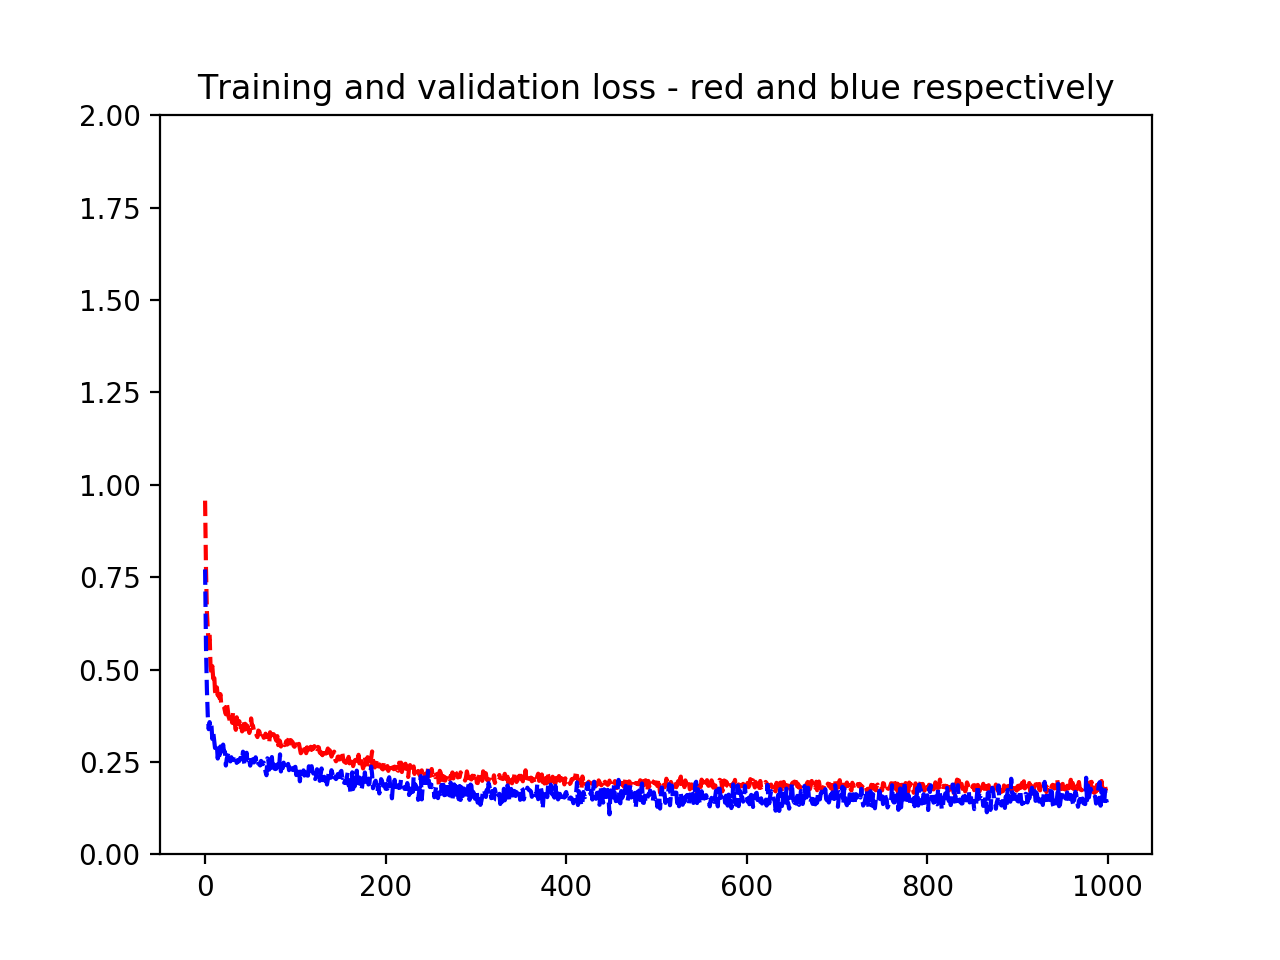

<IPython.core.display.Javascript object>


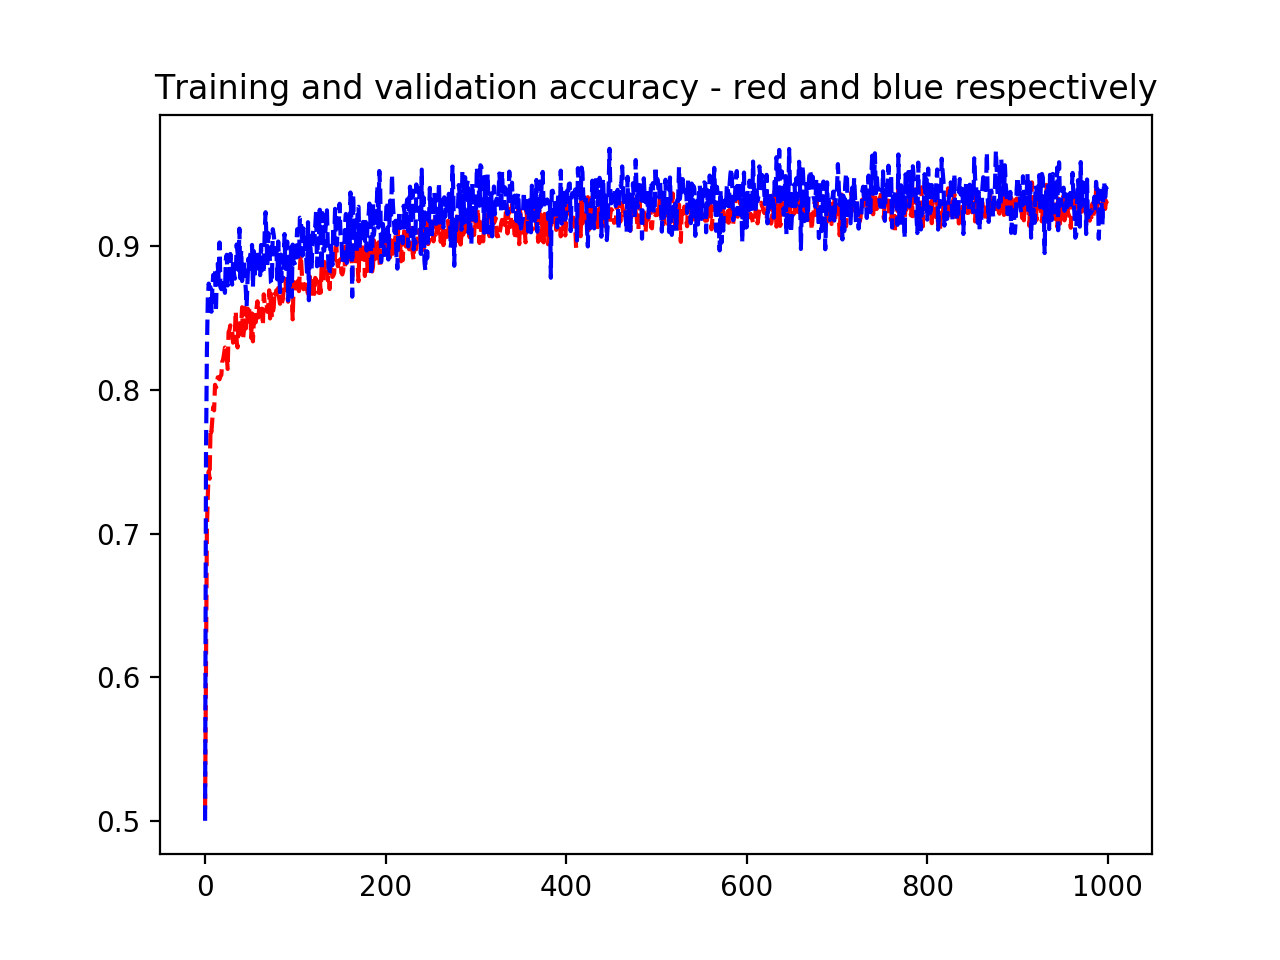

done


In [15]:
saved_dir = '../saved/IMPRS_hdf5_volume_AllDAPI_overlay/0716_181950'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils


print('done')

In [16]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    all_softmax = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                m = torch.nn.Softmax(dim=0)
                print("prediction percentages")
                print(m(output.cpu()[0]))
                print(all_true[i])
                all_softmax.extend(m(output.cpu()))
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    outputcsv = False
    if outputcsv:
        ids = data_loader.ids
        softmax = pd.DataFrame(all_softmax)
        frames = [ids, softmax]
        output_data= np.concatenate(frames, axis=1, join='outer')
        print(output_data.shape)
        
        
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [17]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/16 [00:00<?, ?it/s]

Tesla K80


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 31%|███▏      | 5/16 [00:00<00:02,  4.44it/s]

prediction percentages
tensor([0.6396, 0.3604])
0
prediction percentages
tensor([0.9989, 0.0011])
0


100%|██████████| 16/16 [00:00<00:00, 20.64it/s]

num test images = 1001
loss = 0.1587
my_metric = 0.9481
f1 = 0.9713
balanced_accuracy = 0.9502
precision = 0.9971
recall = 0.9481
My_metric is accuracy
Confusion matrix, without normalization
[[ 63   8]
 [ 44 886]]


<IPython.core.display.Javascript object>


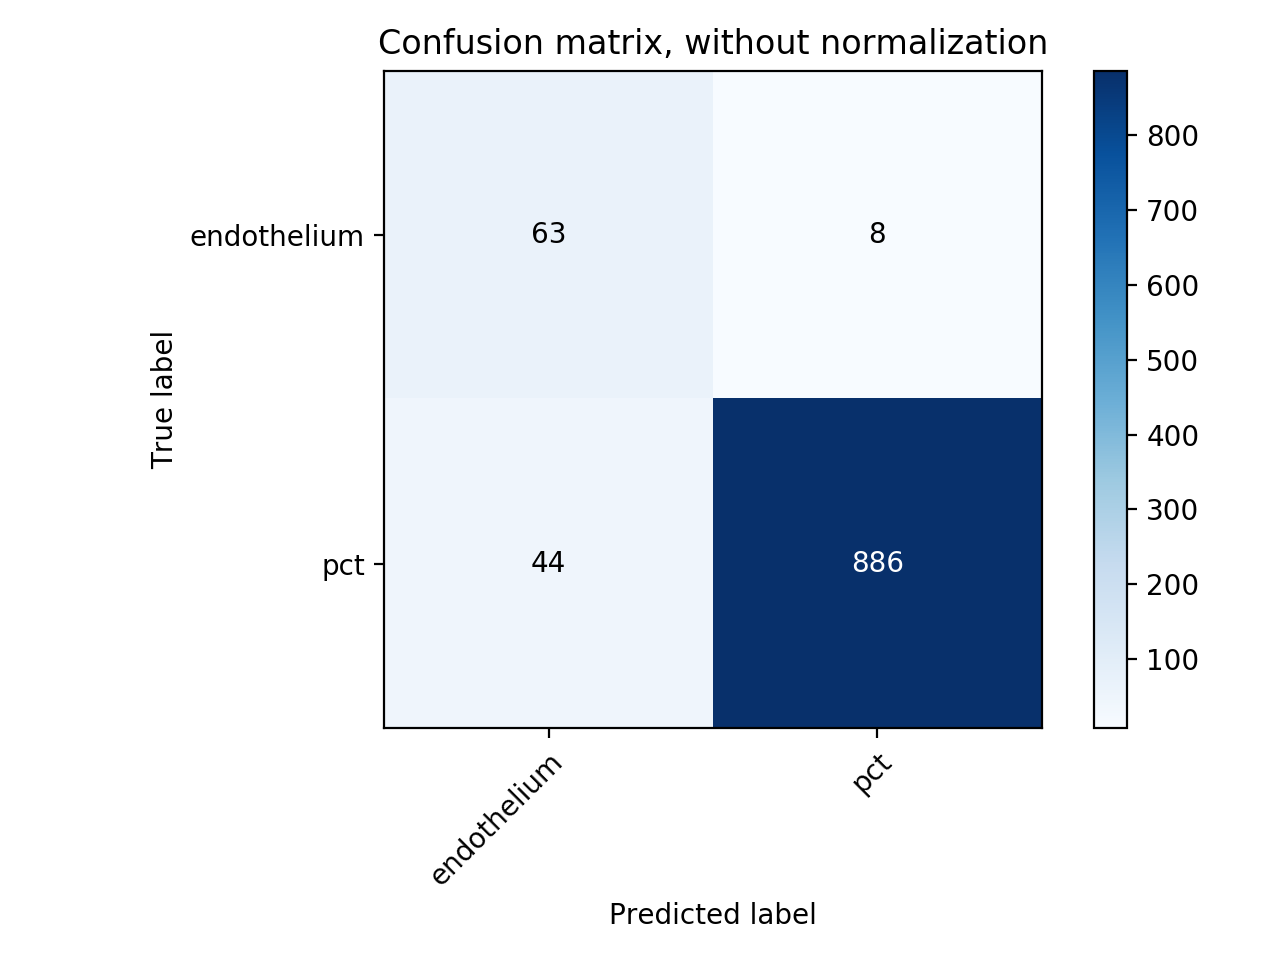

In [20]:
#Test
main2(config, resume)
